In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [292]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.modules.data_spliting import split_train_test
from src.modules.data_preprocessing import load_data
import random
from src.modules.data_partition import data_partition
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import add_missing
from src.fed_imp.sub_modules.client.client_factory import ClientsFactory
from src.fed_imp.sub_modules.strategy.strategy_imp import StrategyImputation
from src.fed_imp.sub_modules.server.load_server import load_server
from src.fed_imp.sub_modules.client.simple_client import SimpleClient
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, correlation, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario, vis_imp
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
experiment_config_template = {
  "num_clients": 20,
  "data": {
    "dataset_name": "ijcnn_balanced_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=0.01",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mary_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": False
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 20,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931467,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechw_fmm": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechw_sigmoid": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechw_fmm_sigmoid": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechw_lmm": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechw_fmm_lmm": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [4]:
trackers = {}
rets ={}

In [5]:
def vis_imp(ret):
    x = list(range(len(ret['client_imp_history'])))
    client_ids = list(ret['client_imp_history'][0][2]['metrics'].keys())

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    for client_id in client_ids:
        for idx, metric in enumerate(['imp@rmse', 'imp@w2', 'imp@sliced_ws']):
            y = [ret['client_imp_history'][i][2]['metrics'][client_id][metric] for i in x]
            ax[idx].plot(x, y, label=client_id)
            ax[idx].set_title(metric)
            if metric == 'imp@rmse':
                ax[idx].set_ylim([0, 0.2])
                ax[idx].set_xticks(x)
                ax[idx].legend()
            
    plt.show()

## MNAR LR 0.3 0.3

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3']
(11051, 21)


2023-07-22 13:57:55.835 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 13:57:55.836 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 13:58:32.519 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 13:58:32.520 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 13:59:05.867 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 13:59:05.868 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 13:59:09.285 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 74.36739300005138


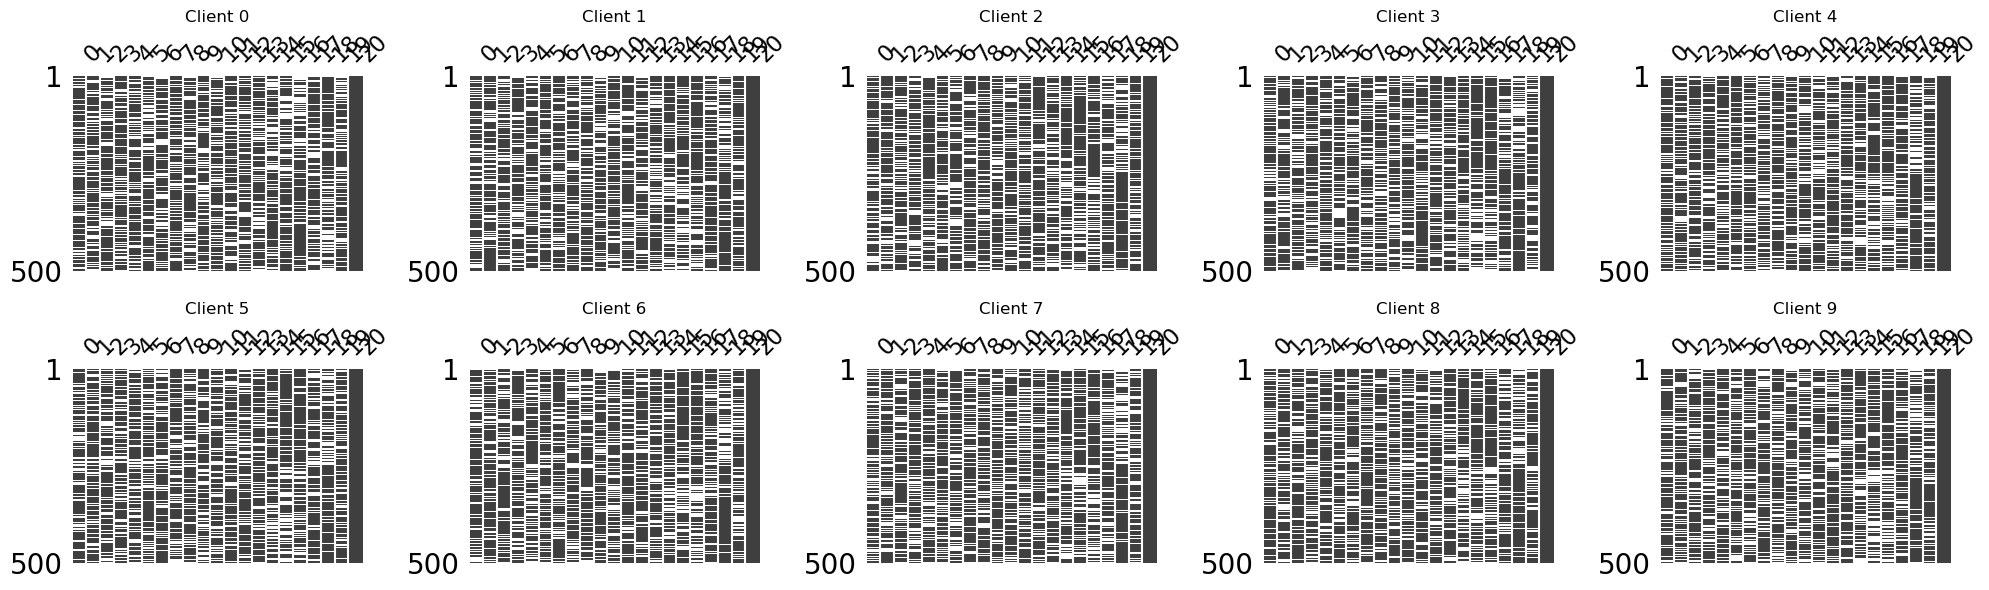

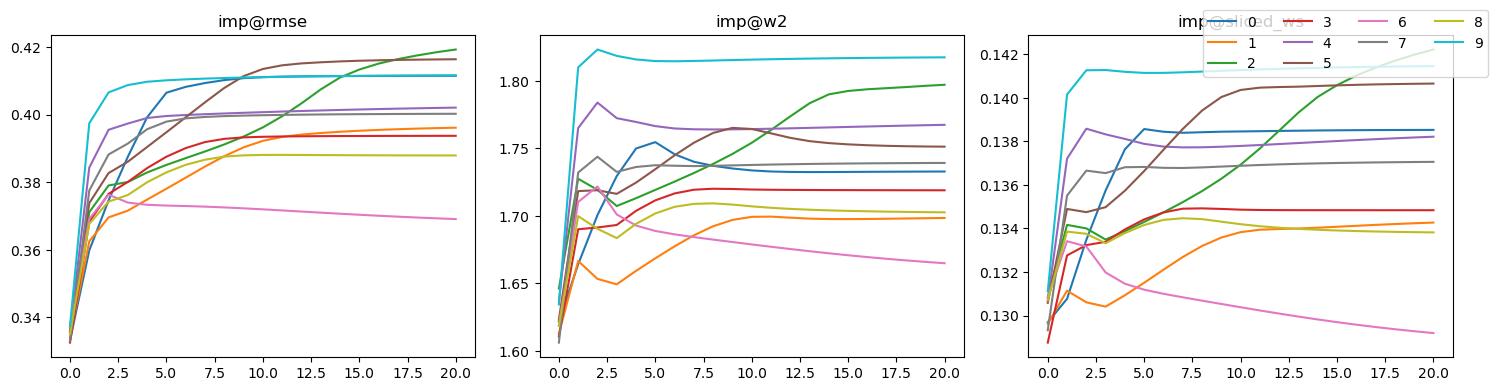

{'imp@rmse': 0.40055716734630953, 'imp@ws': 1.7389512362937962, 'imp@sliced_ws': 0.1369609694278515}


In [202]:
name = 'mnar_lr0.3_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.3'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.1'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3']
(11051, 21)


2023-07-22 13:40:02.743 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 13:40:02.744 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 13:40:34.184 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 13:40:34.185 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 13:41:08.709 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 13:41:08.710 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 13:41:12.194 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 70.36064089997672


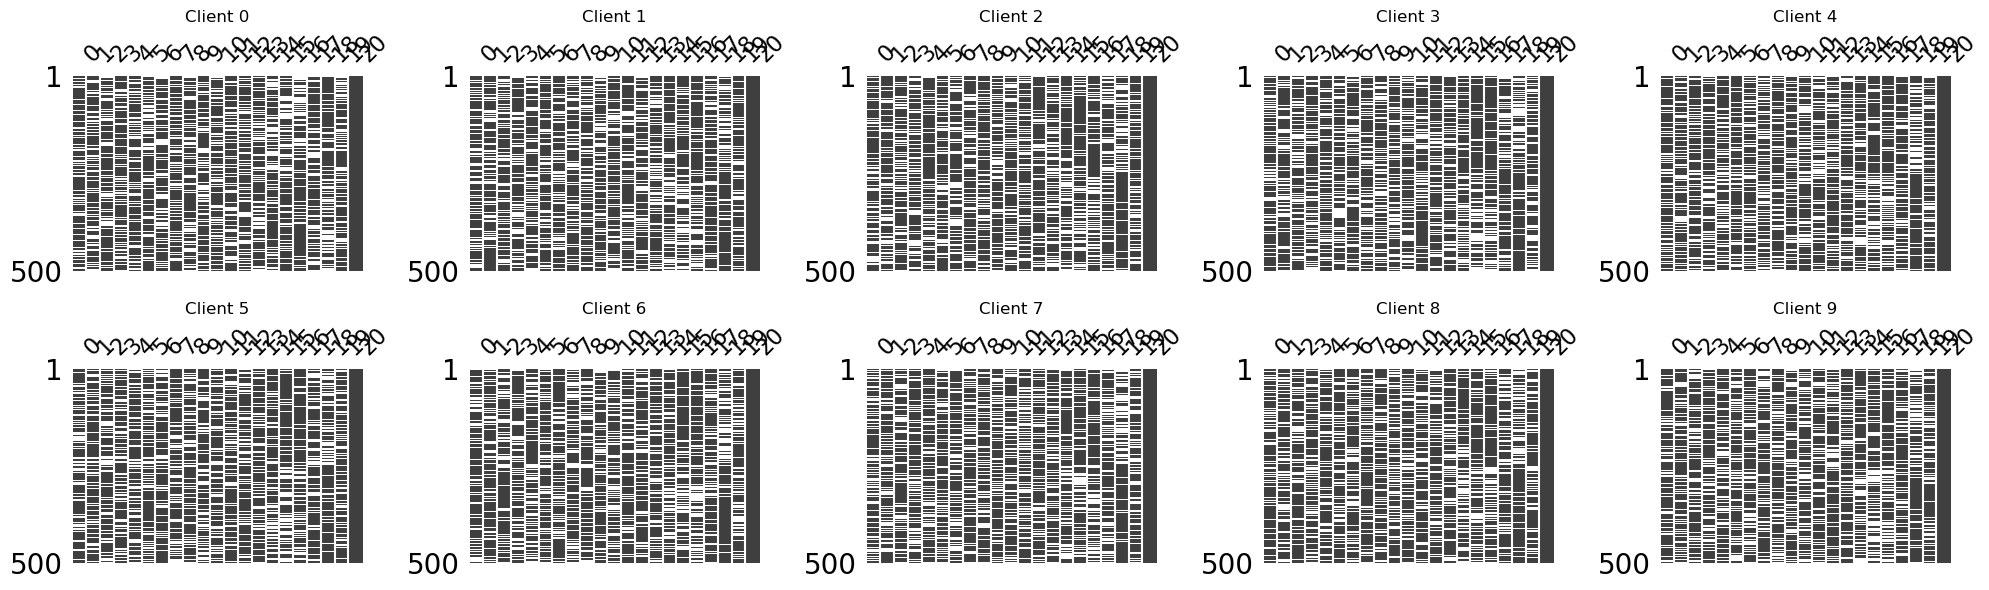

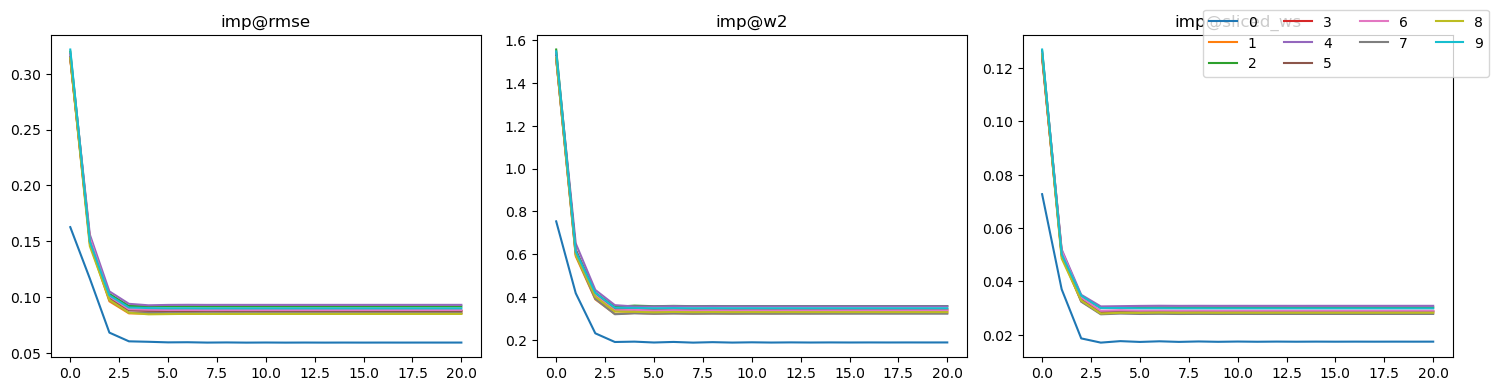

{'imp@rmse': 0.08528148320408344, 'imp@ws': 0.3263976129173962, 'imp@sliced_ws': 0.027991950515391426}


In [191]:
name = 'mnar_lr0.3_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.3'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.1'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## MNAR LR 0.7 0.7

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7']
(11051, 21)


2023-07-22 14:13:49.372 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:13:49.373 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 14:14:22.263 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:14:22.264 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 14:14:53.677 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:14:53.678 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 14:14:56.904 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 68.44313859997783


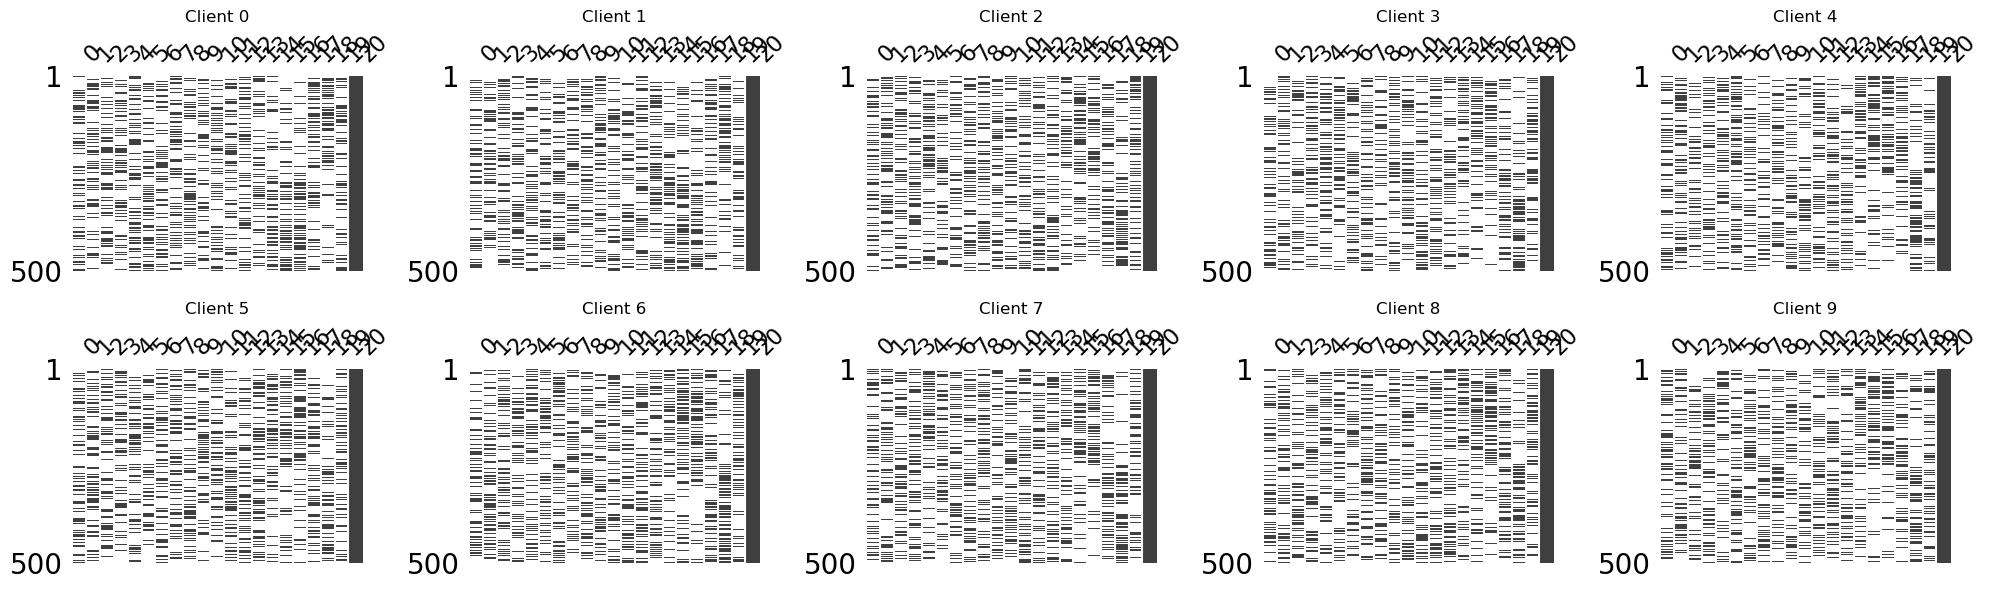

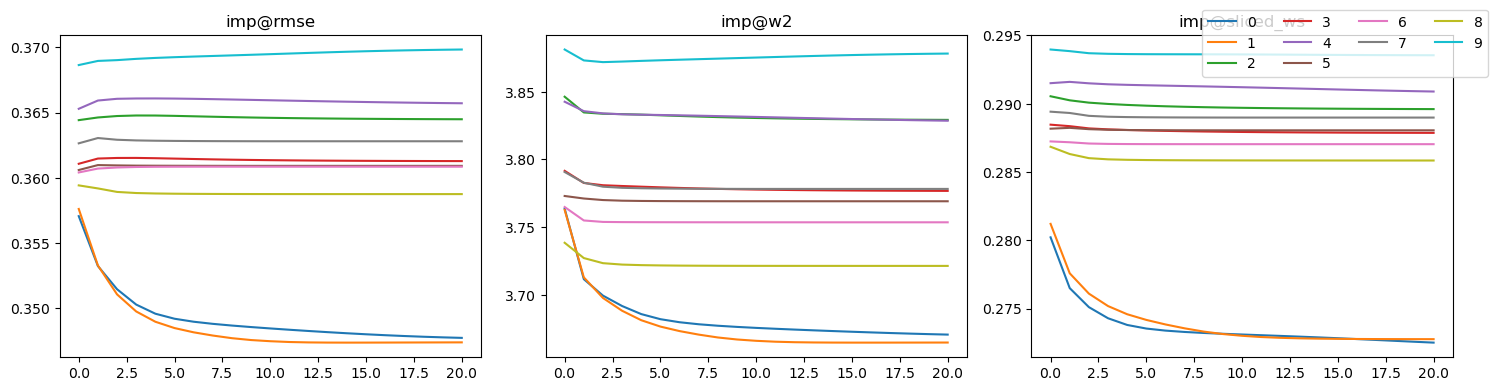

{'imp@rmse': 0.3599784345803153, 'imp@ws': 3.7671771756917867, 'imp@sliced_ws': 0.28572820392377585}


In [210]:
imp_strategy = 'local'
name = 'mnar_lr0.7_{}'.format(imp_strategy)
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.7'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.2'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = imp_strategy
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7']
(11051, 21)


2023-07-22 14:15:13.936 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:15:13.937 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 14:15:42.839 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:15:42.840 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 14:16:14.351 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:16:14.351 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 14:16:17.666 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 64.628074200009


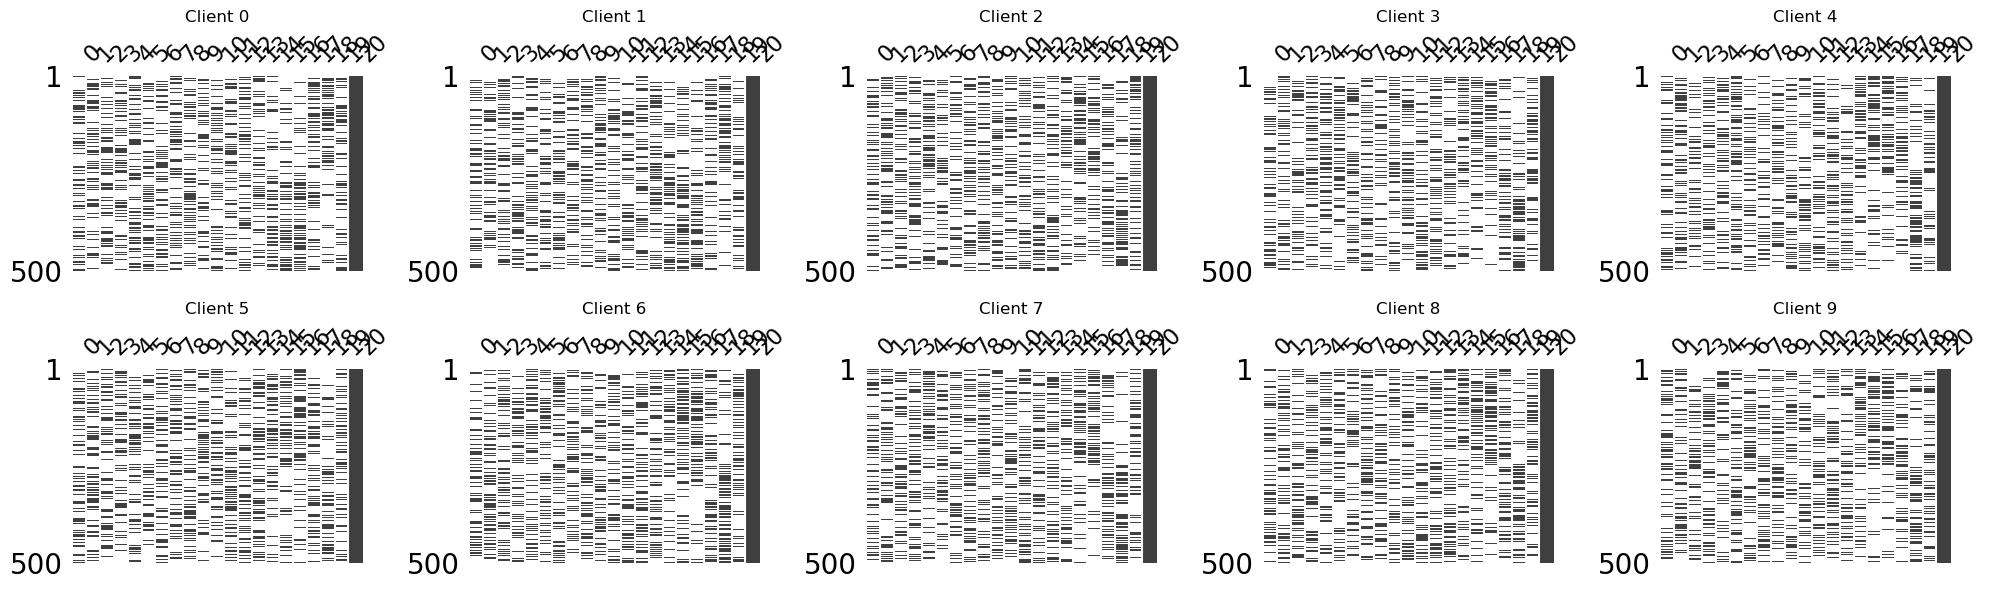

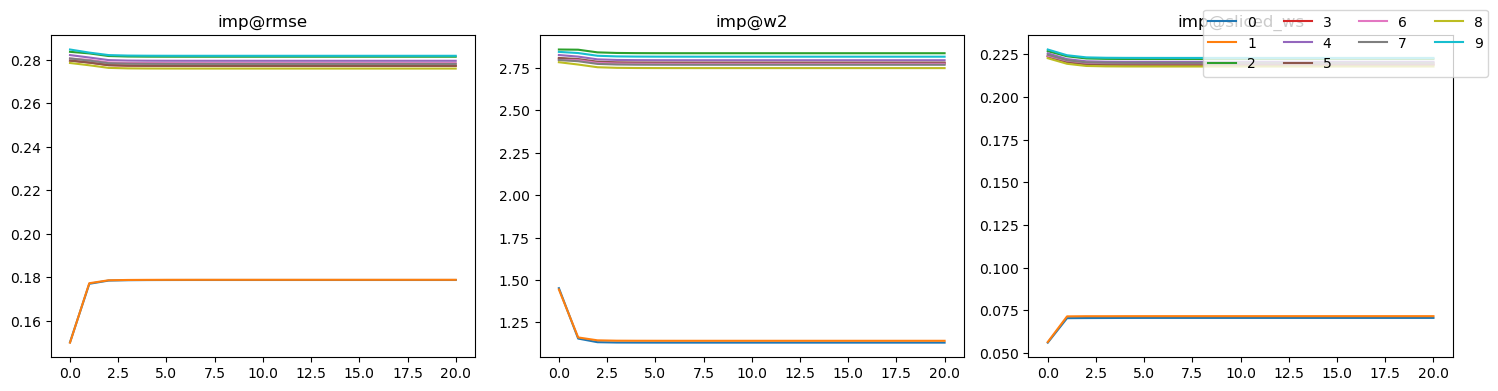

{'imp@rmse': 0.2586755646577304, 'imp@ws': 2.4574765293345426, 'imp@sliced_ws': 0.19033343062656666}


In [211]:
imp_strategy = 'fedavg-s'
name = 'mnar_lr0.7_{}'.format(imp_strategy)
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.7'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.2'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = imp_strategy
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7']
(11051, 21)


2023-07-22 14:16:35.050 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:16:35.051 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 14:17:08.853 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:17:08.854 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 14:17:45.571 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:17:45.572 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 14:17:49.198 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 75.06017770001199


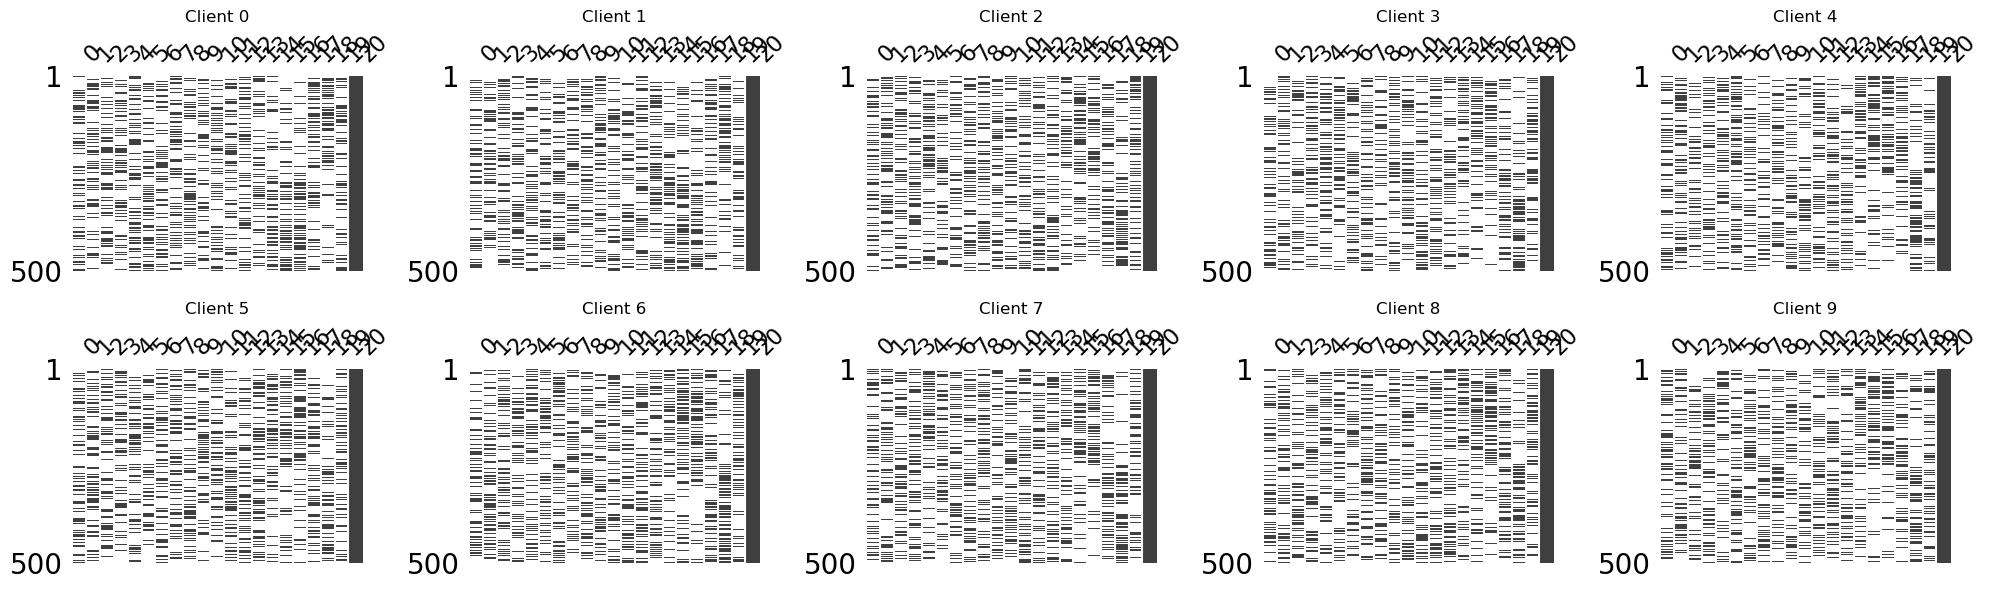

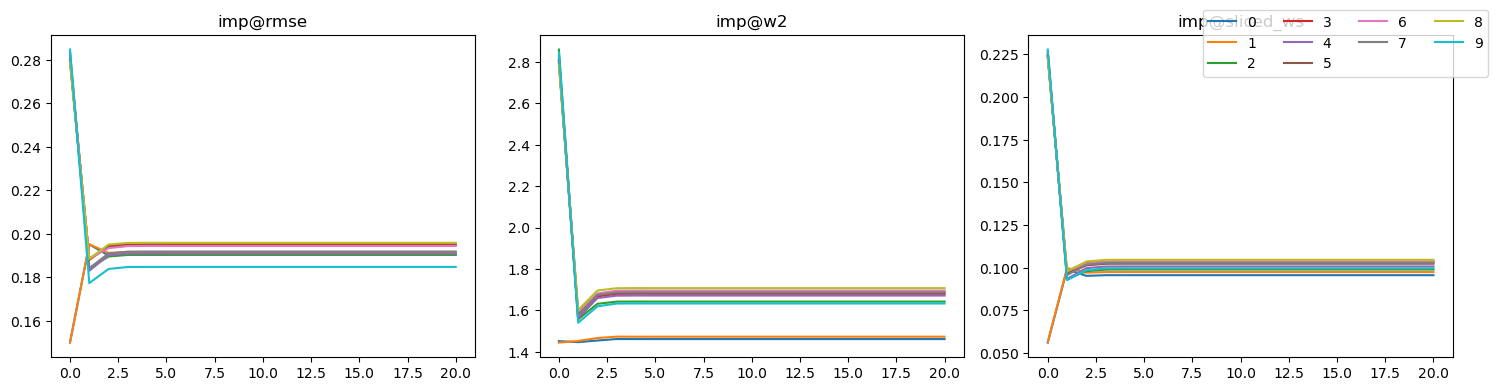

{'imp@rmse': 0.19201233892677347, 'imp@ws': 1.6342467889105945, 'imp@sliced_ws': 0.10095232035130143}


In [212]:
imp_strategy = 'fedmechw'
name = 'mnar_lr0.7_{}'.format(imp_strategy)
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.7'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.2'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = imp_strategy
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## MNAR LR 0.3 0.7

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 08:31:32.691 | INFO     | src.fed_imp.sub_modules.server.base_server:run:171 - FL finished in 60.90247079997789


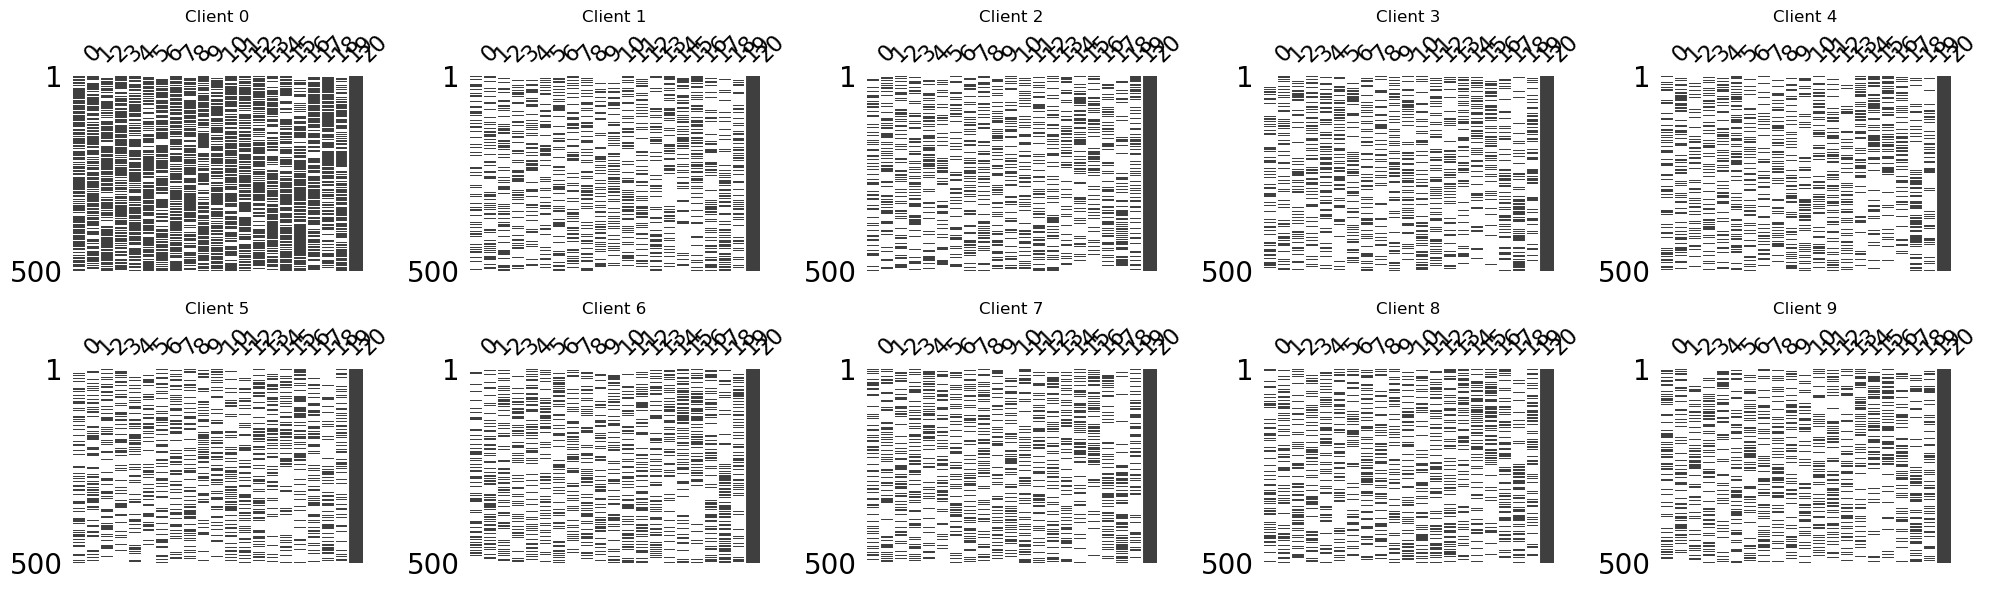

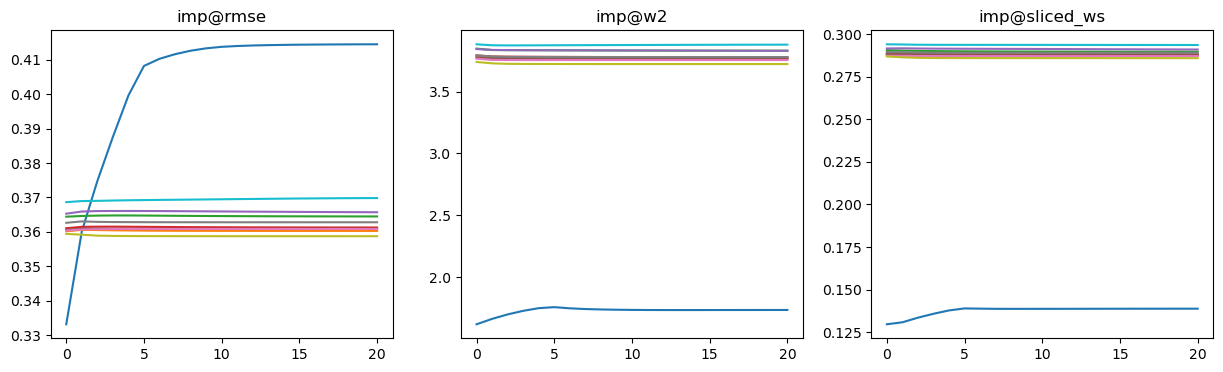

{'imp@rmse': 0.36793902753761143, 'imp@ws': 3.5835718988372, 'imp@sliced_ws': 0.2738203653411215}


In [37]:
name = 'mnar_lr0.3_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl@mr=0.3'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.1'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 08:32:53.978 | INFO     | src.fed_imp.sub_modules.server.base_server:run:171 - FL finished in 66.05719540000428


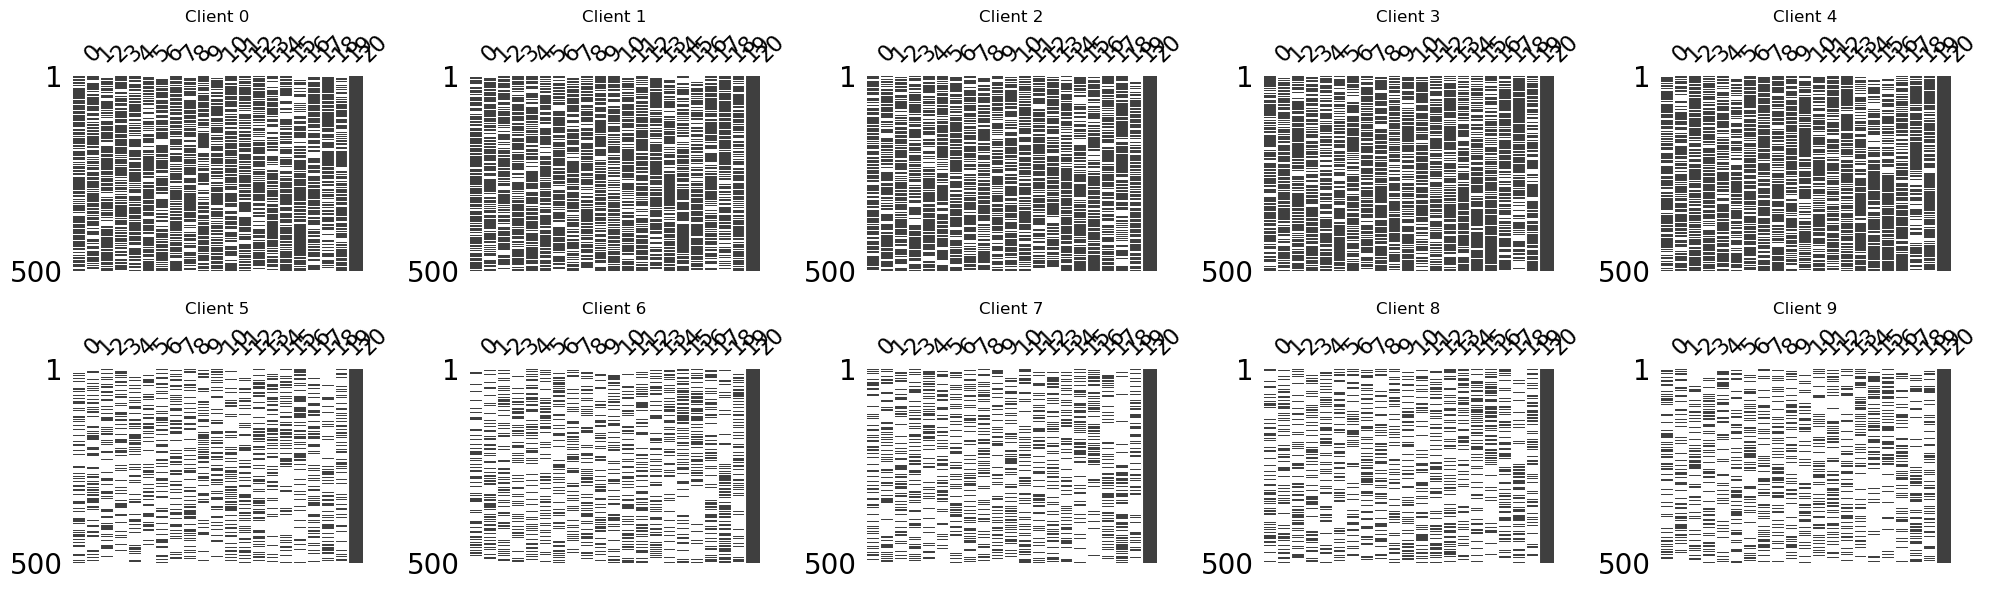

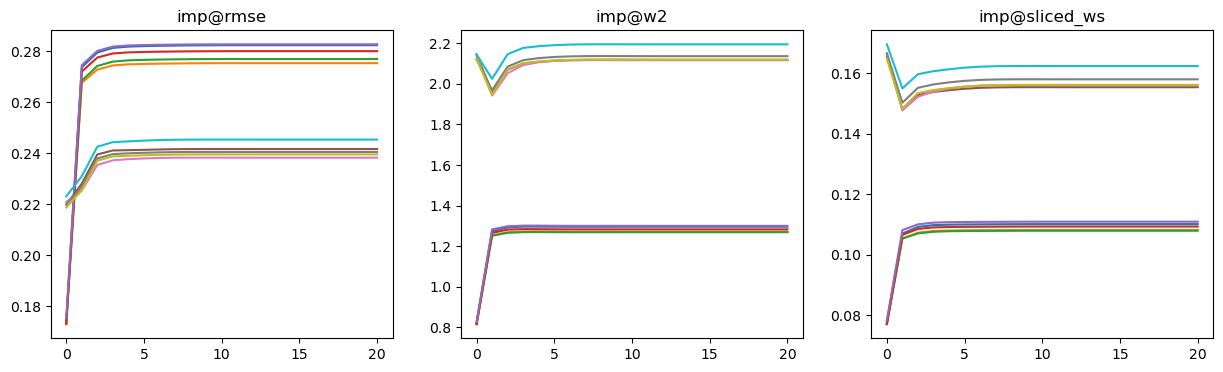

{'imp@rmse': 0.2603269840928288, 'imp@ws': 1.7103304725112296, 'imp@sliced_ws': 0.13344376333653415}


In [38]:
name = 'mnar_lr0.3_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl@mr=0.3'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['imputation']['clip'] = True
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left@0.3', 'mnar_quantile_left@0.3', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7']
(11051, 21)


2023-07-22 14:23:17.782 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:23:17.783 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 14:23:55.624 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:23:55.625 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 14:24:30.472 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:24:30.473 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 14:24:33.997 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 77.17425429995637


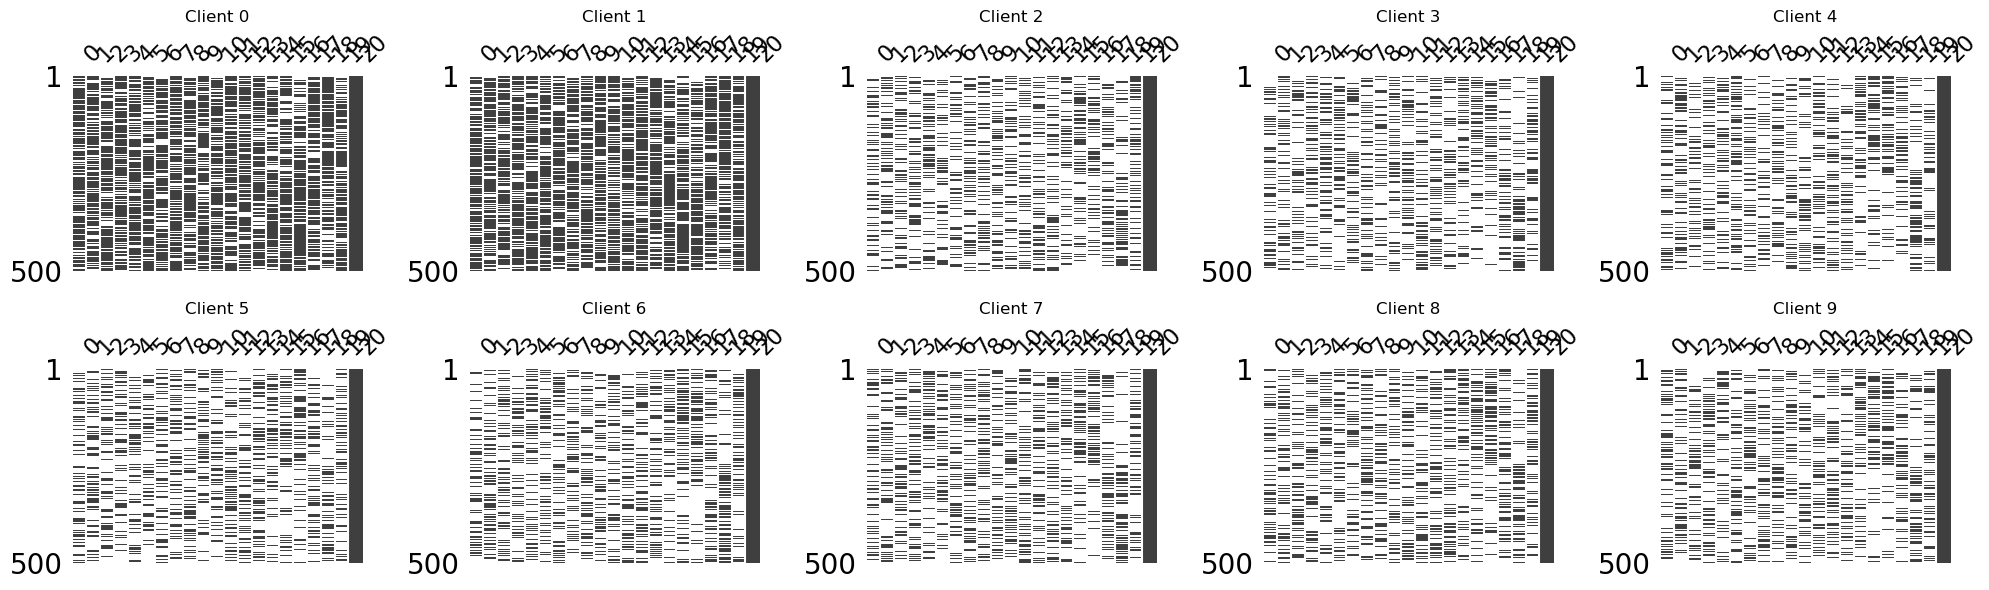

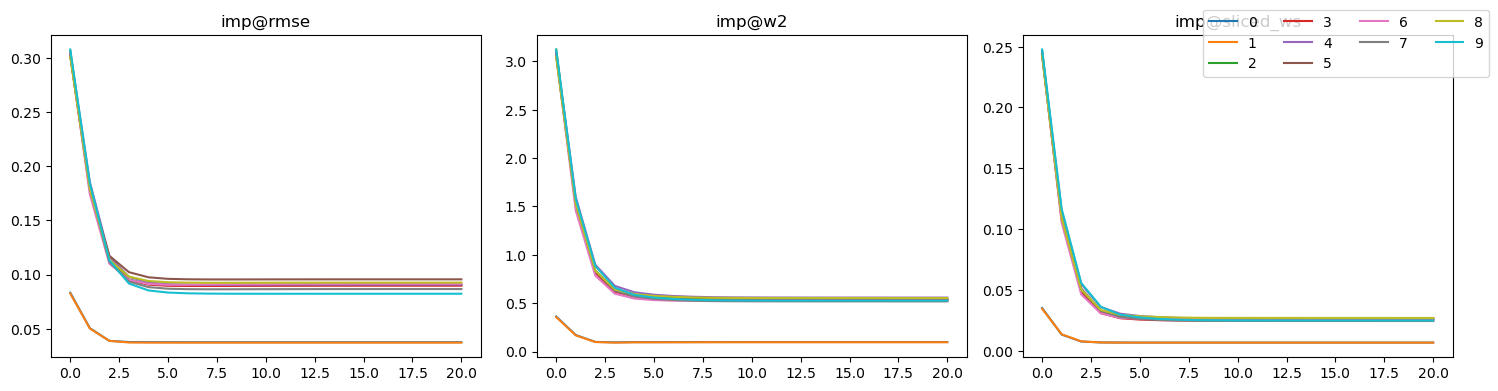

{'imp@rmse': 0.07943966812895634, 'imp@ws': 0.44800748500799675, 'imp@sliced_ws': 0.02198011555242552}


In [227]:
name = 'mnar_lr0.37_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl@mr=0.3'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.2'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['imputation']['clip'] = True
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 08:30:16.581 | INFO     | src.fed_imp.sub_modules.server.base_server:run:171 - FL finished in 73.05389280000236


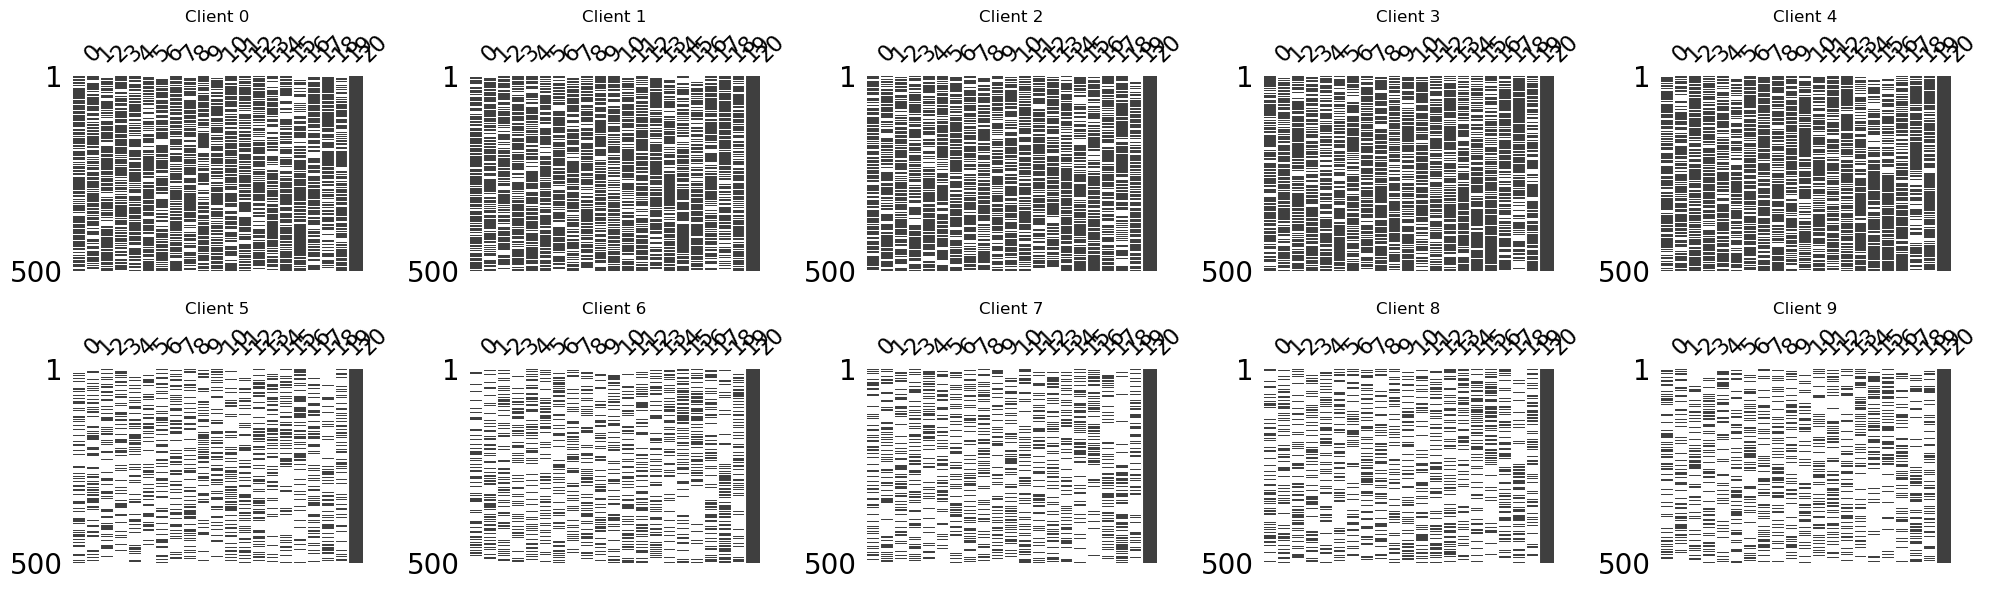

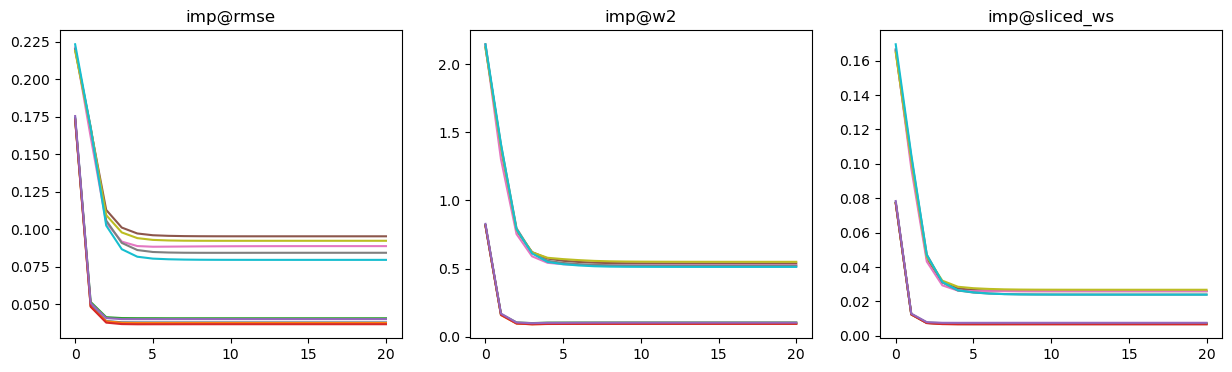

{'imp@rmse': 0.06335636838113365, 'imp@ws': 0.313415030809708, 'imp@sliced_ws': 0.016204064943634335}


In [36]:
name = 'mnar_lr0.3_fedmechw1'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl@mr=0.3'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['imputation']['clip'] = False
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## MNAR R 0.left Tail 0.6

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6']
tail 0.4588646089973422 0.5142964546372593 299 300 500 2 1
(11051, 21)


2023-07-22 14:55:32.305 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:55:32.307 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 14:56:09.611 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:56:09.612 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 14:56:45.970 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:56:45.971 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 14:56:49.622 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 78.23896230000537


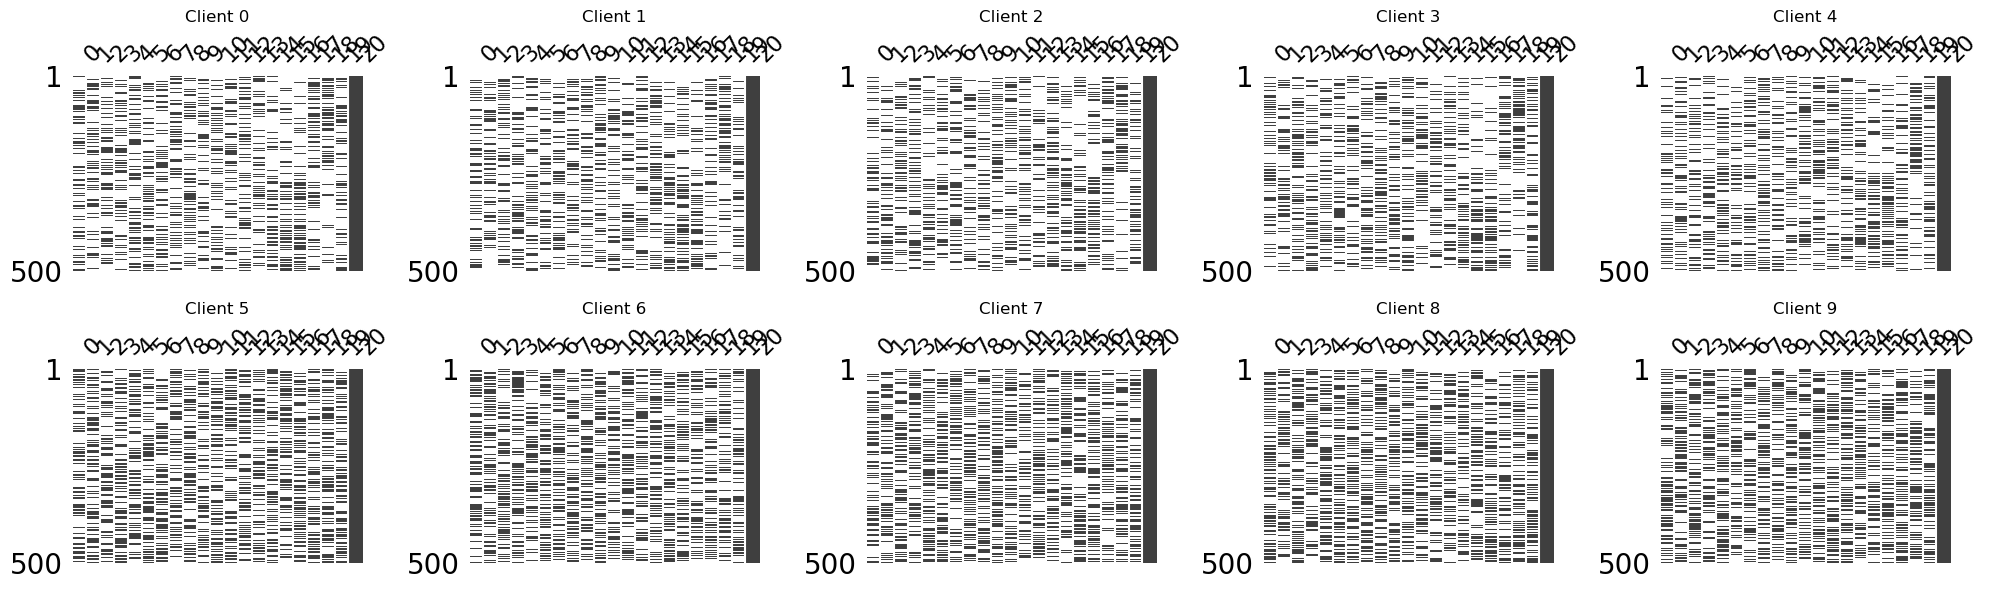

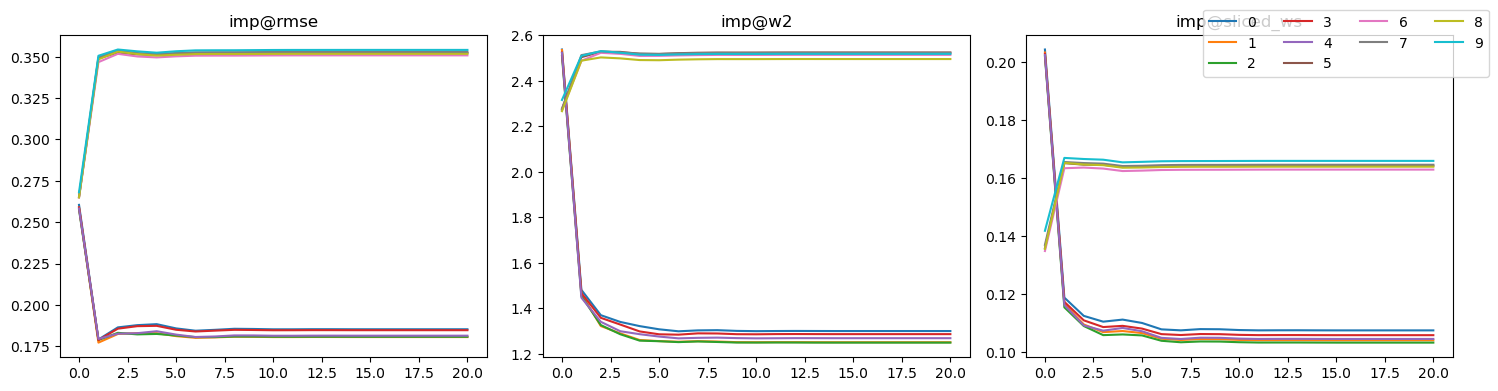

{'imp@rmse': 0.26741812231456463, 'imp@ws': 1.8919881875748144, 'imp@sliced_ws': 0.13461559593402428}


In [249]:
imp_strategy = 'fedmechw'
name = 'test_{}'.format(imp_strategy)
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'test'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'test'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = imp_strategy
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6']
tail 0.4588646089973422 0.5142964546372593 299 300 500 2 1
(11051, 21)


2023-07-22 14:57:18.736 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:57:18.736 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 14:57:51.221 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:57:51.222 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 14:58:25.288 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:58:25.289 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 14:58:28.773 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 70.95858730003238


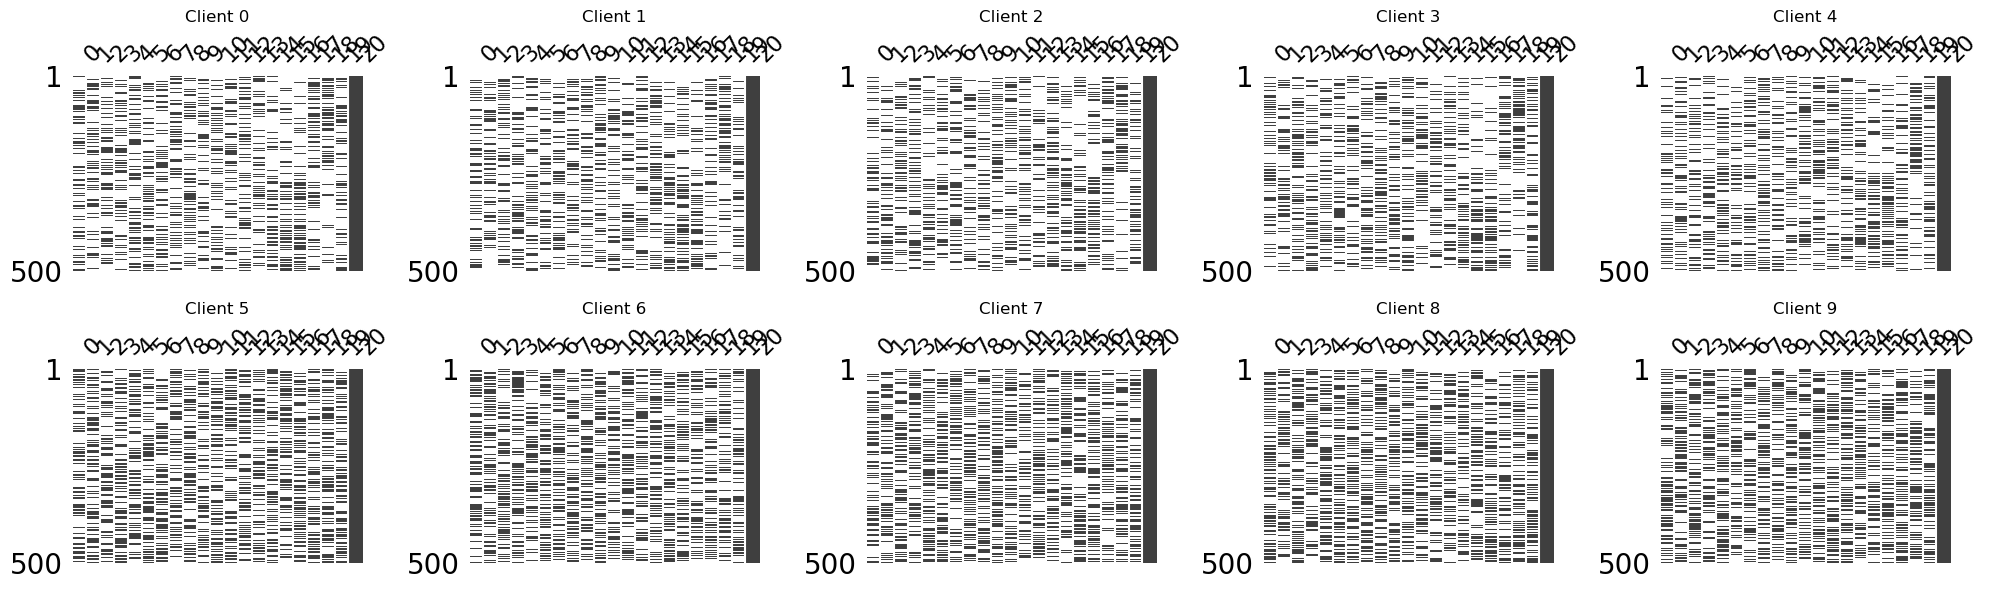

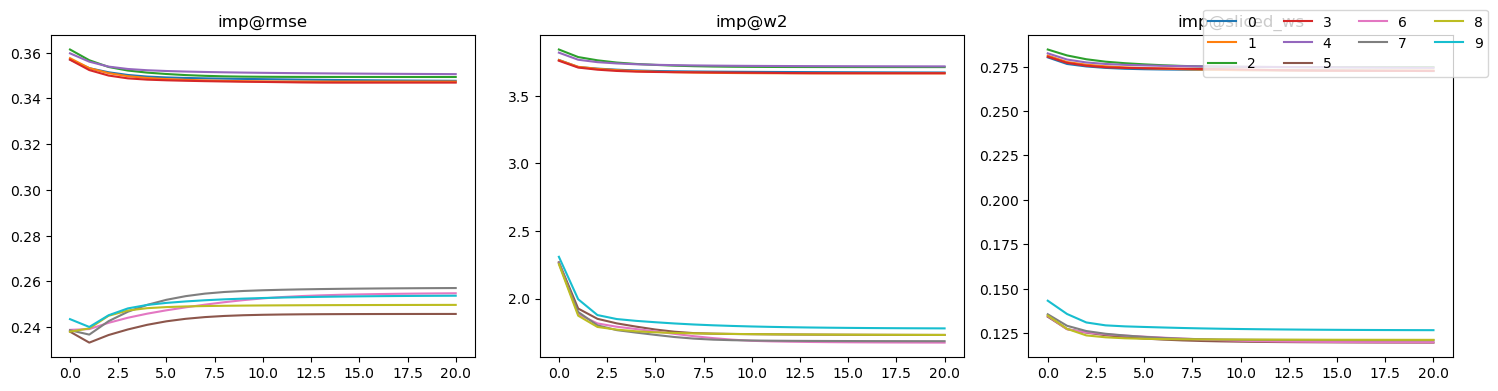

{'imp@rmse': 0.30031534832460366, 'imp@ws': 2.7031858393578614, 'imp@sliced_ws': 0.1976034904653786}


In [250]:
imp_strategy = 'local'
name = 'test_{}'.format(imp_strategy)
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'test'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'test'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = imp_strategy
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6']
tail 0.4588646089973422 0.5142964546372593 299 300 500 2 1
(11051, 21)


2023-07-22 14:59:07.580 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:59:07.581 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 14:59:38.675 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 14:59:38.676 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 15:00:13.085 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 15:00:13.086 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 15:00:16.606 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 69.96469129994512


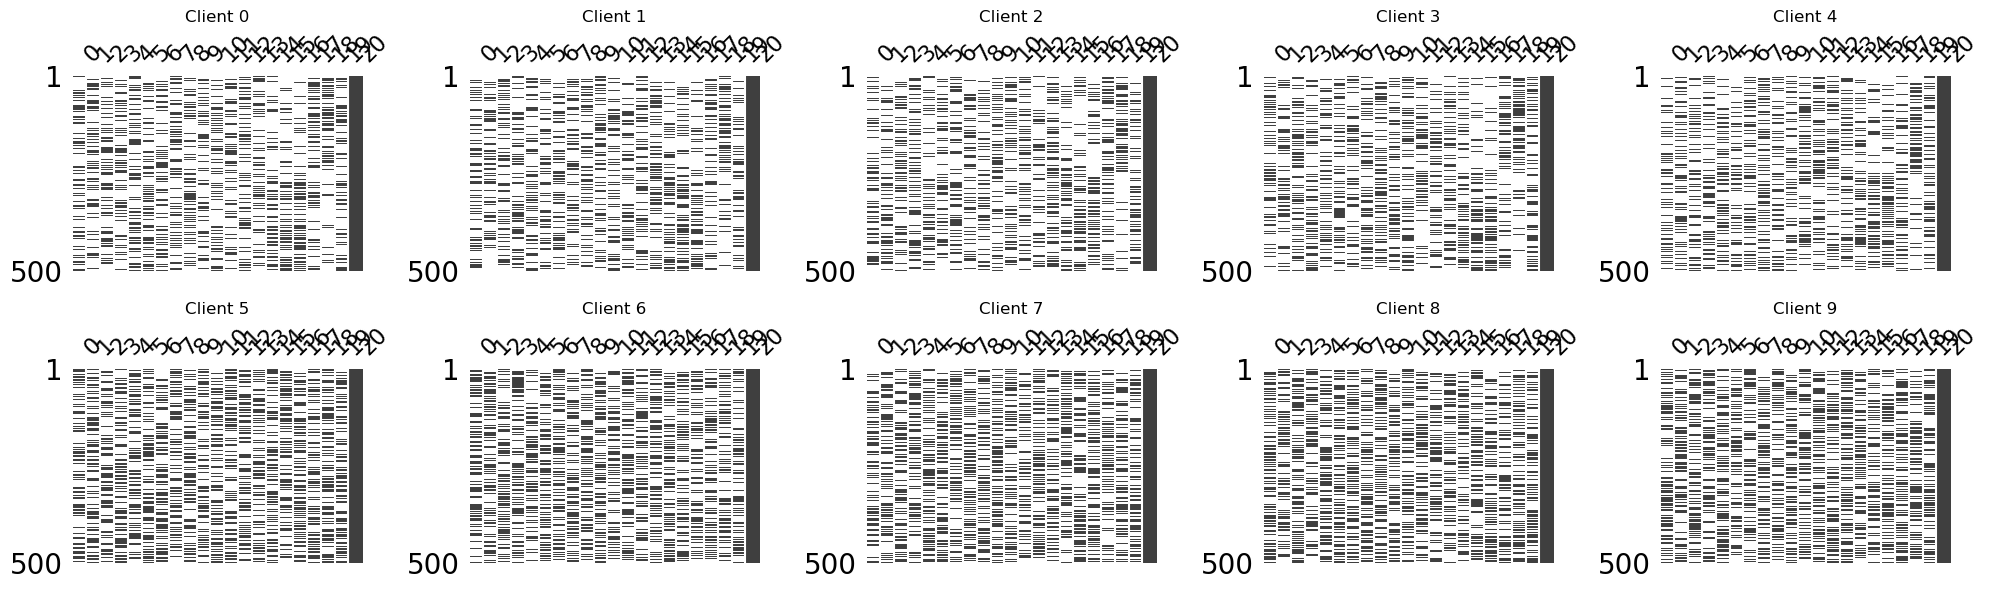

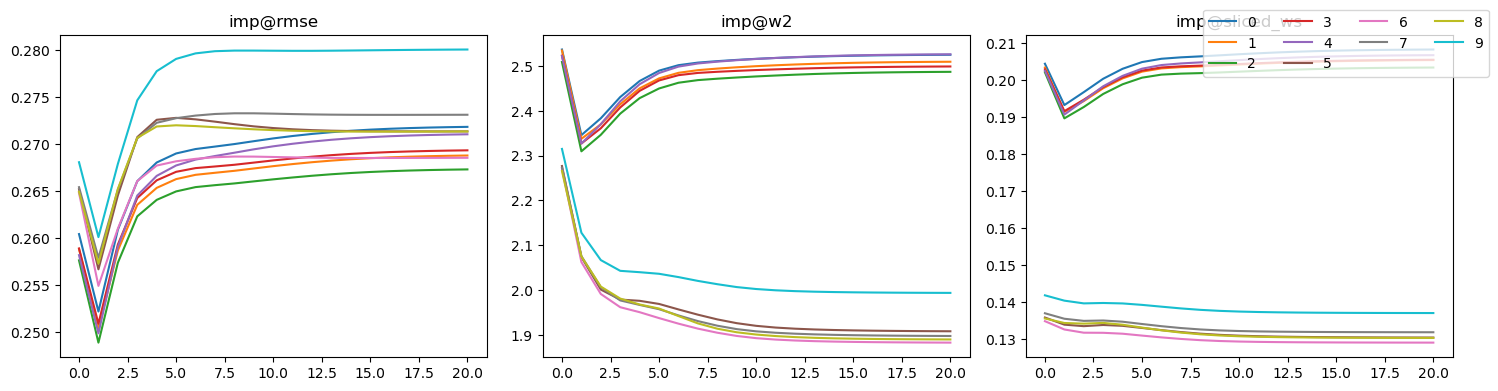

{'imp@rmse': 0.27122776375748153, 'imp@ws': 2.2116309943565713, 'imp@sliced_ws': 0.16868158731492314}


In [251]:
imp_strategy = 'fedavg-s'
name = 'test_{}'.format(imp_strategy)
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'test'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'test'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = imp_strategy
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## MNAR Mid 0.6 Tail 0.6

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_mid@0.6', 'mnar_quantile_mid@0.6', 'mnar_quantile_mid@0.6', 'mnar_quantile_mid@0.6', 'mnar_quantile_mid@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6']
tail 0.4588646089973422 0.5142964546372593 299 300 500 2 1
(11051, 21)


2023-07-22 15:08:05.693 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 15:08:05.694 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 15:08:41.918 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 15:08:41.919 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 15:09:17.035 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 15:09:17.036 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 15:09:20.649 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 75.92111370002385


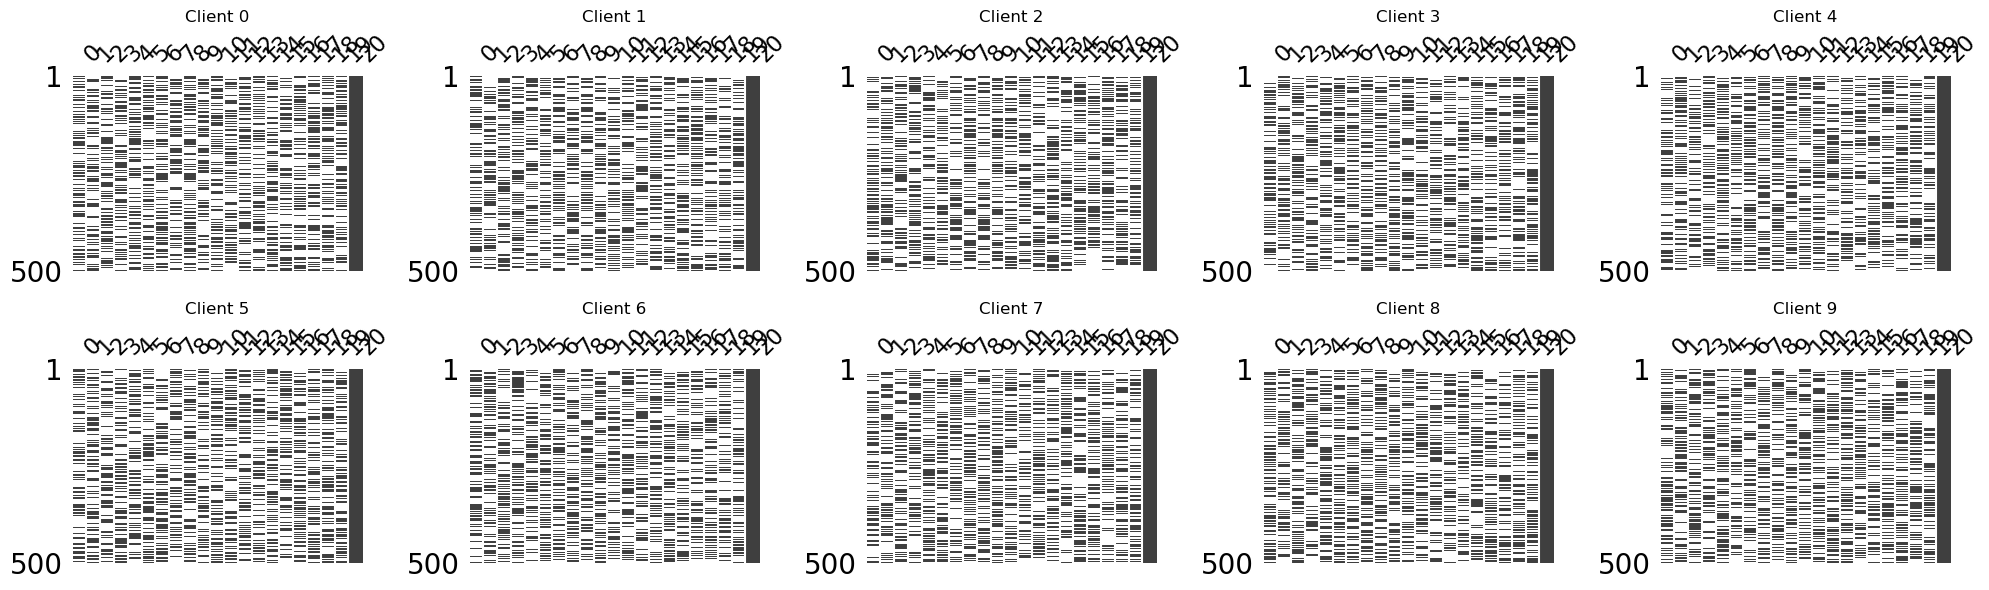

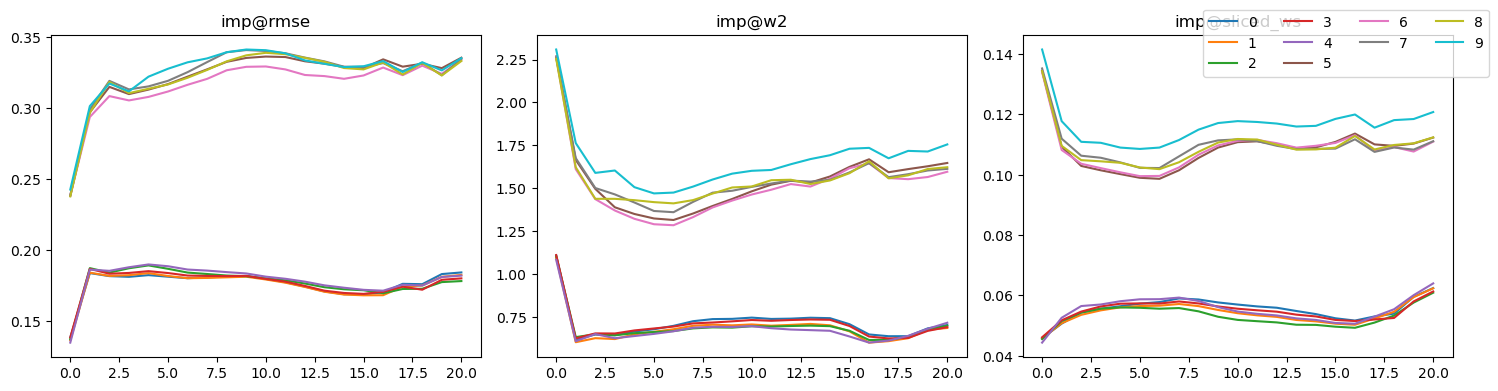

{'imp@rmse': 0.2527441190938203, 'imp@ws': 1.139385347334343, 'imp@sliced_ws': 0.08375978712525017}


In [262]:
imp_strategy = 'fedmechw'
name = 'test_{}'.format(imp_strategy)
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'test'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'test'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = imp_strategy
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_mid@0.6', 'mnar_quantile_mid@0.6', 'mnar_quantile_mid@0.6', 'mnar_quantile_mid@0.6', 'mnar_quantile_mid@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6']
tail 0.4588646089973422 0.5142964546372593 299 300 500 2 1
(11051, 21)
testavg


2023-07-22 15:37:37.798 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 15:37:37.799 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 15:38:19.658 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 15:38:19.659 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 15:38:54.765 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 15:38:54.766 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 15:38:58.314 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 81.42766120005399


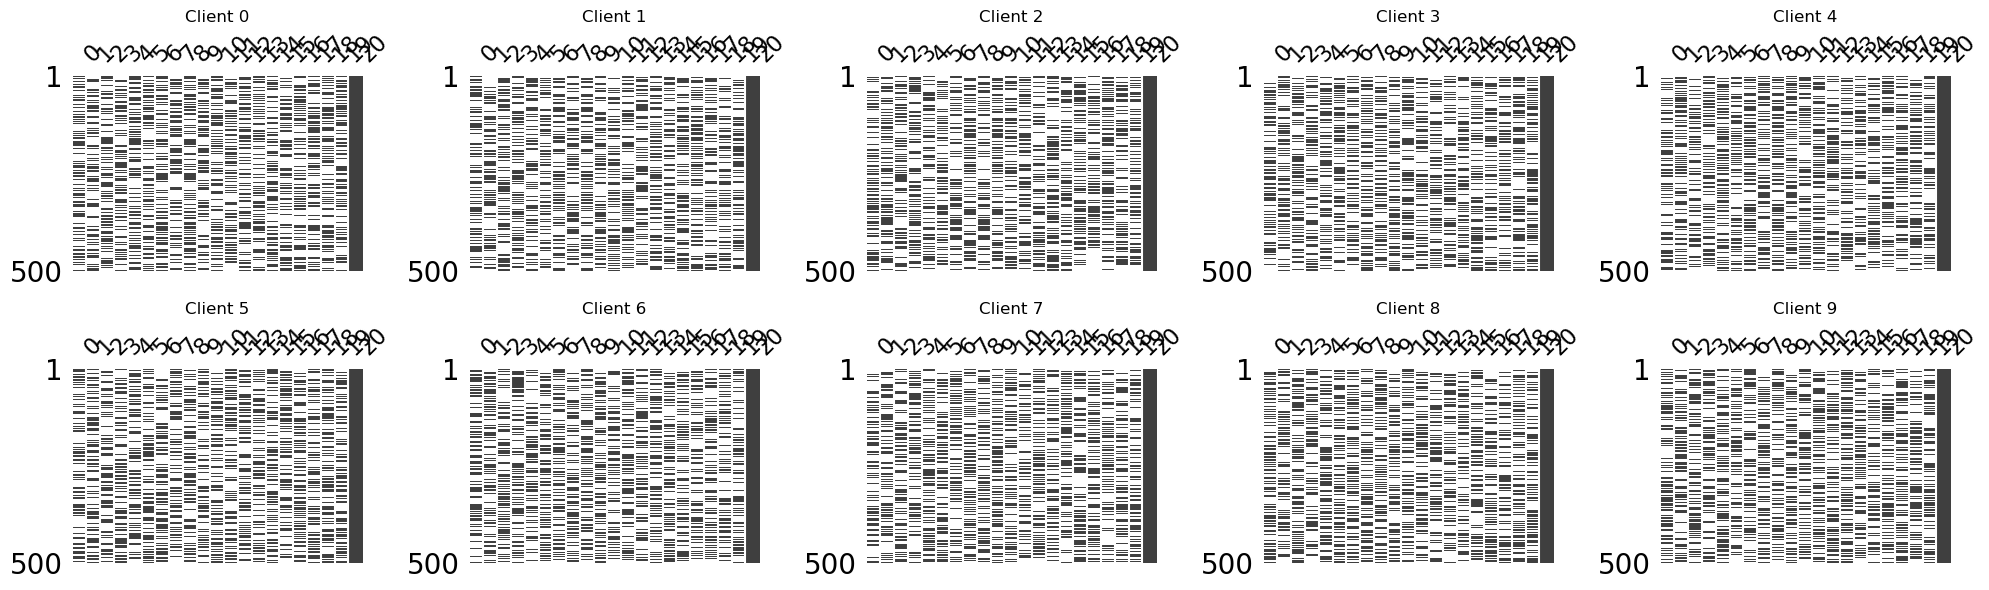

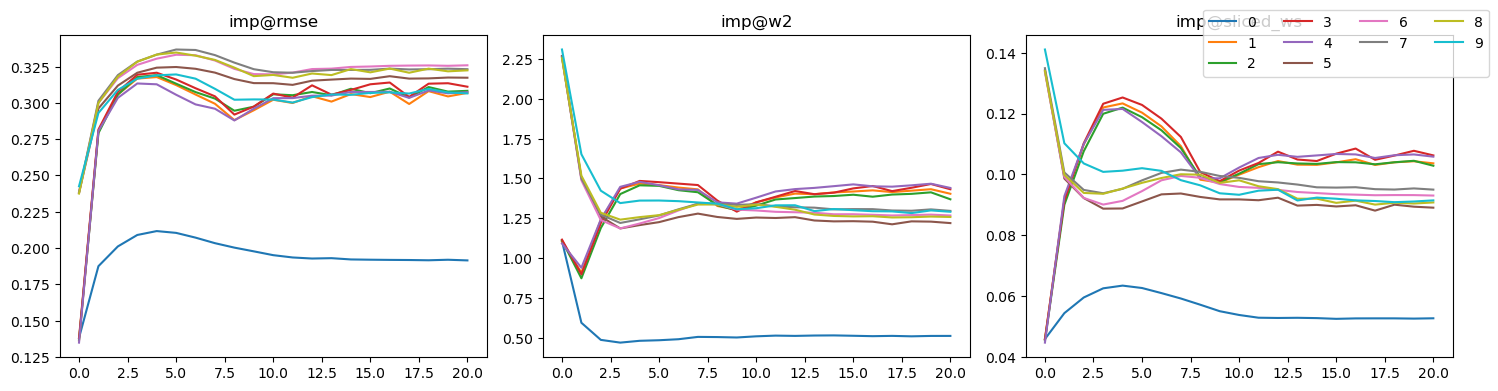

{'imp@rmse': 0.30190925901980387, 'imp@ws': 1.2569396309600682, 'imp@sliced_ws': 0.09326391807245717}


In [293]:
imp_strategy = 'testavg'
name = 'test_{}'.format(imp_strategy)
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'test'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'test'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = imp_strategy
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_mid@0.6', 'mnar_quantile_mid@0.6', 'mnar_quantile_mid@0.6', 'mnar_quantile_mid@0.6', 'mnar_quantile_mid@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6', 'mnar_quantile_tail@0.6']
tail 0.4588646089973422 0.5142964546372593 299 300 500 2 1
(11051, 21)


2023-07-22 15:09:37.801 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 15:09:37.802 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 15:10:08.069 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 15:10:08.070 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 15:10:42.425 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 15:10:42.426 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 15:10:45.971 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 69.08811230002902


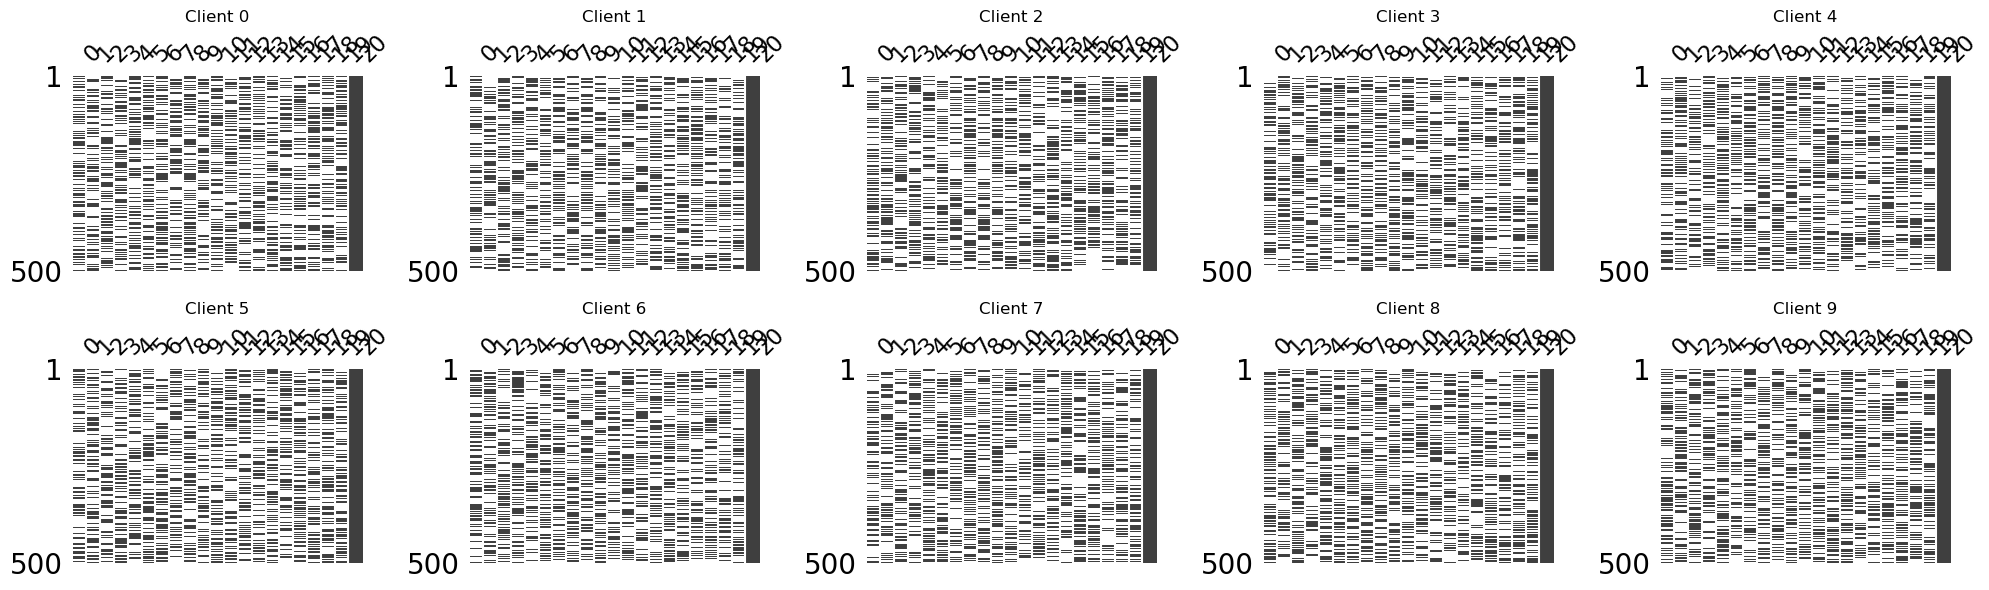

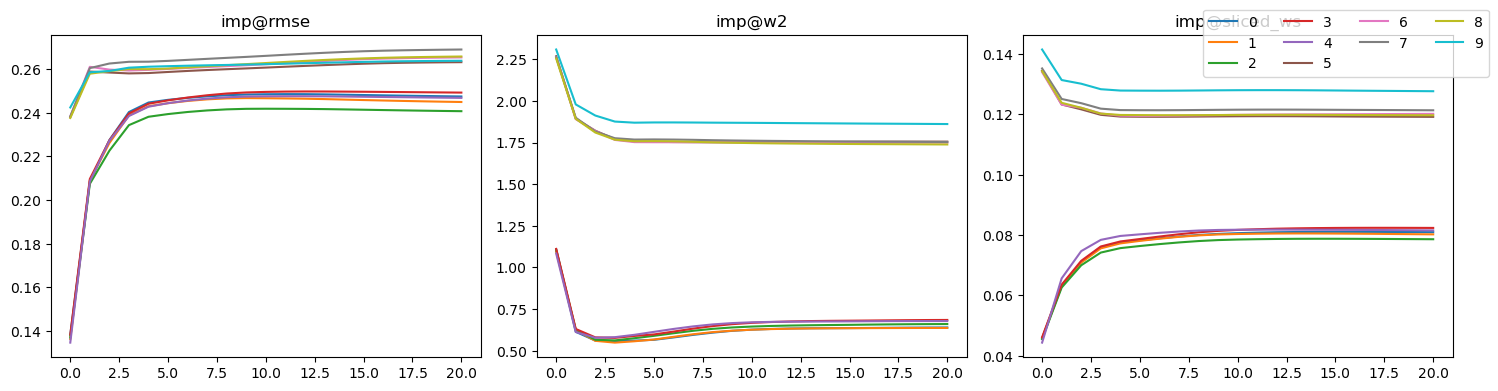

{'imp@rmse': 0.25571422343520683, 'imp@ws': 1.215519762658814, 'imp@sliced_ws': 0.1012161328807845}


In [263]:
imp_strategy = 'fedavg-s'
name = 'test_{}'.format(imp_strategy)
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'test'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'test'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = imp_strategy
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## MNAR LR 0.1 0.1

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 10:00:05.851 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 10:00:05.852 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 10:00:36.273 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 10:00:36.273 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 10:01:10.597 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 10:01:10.598 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 10:01:14.134 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 69.16222559998278


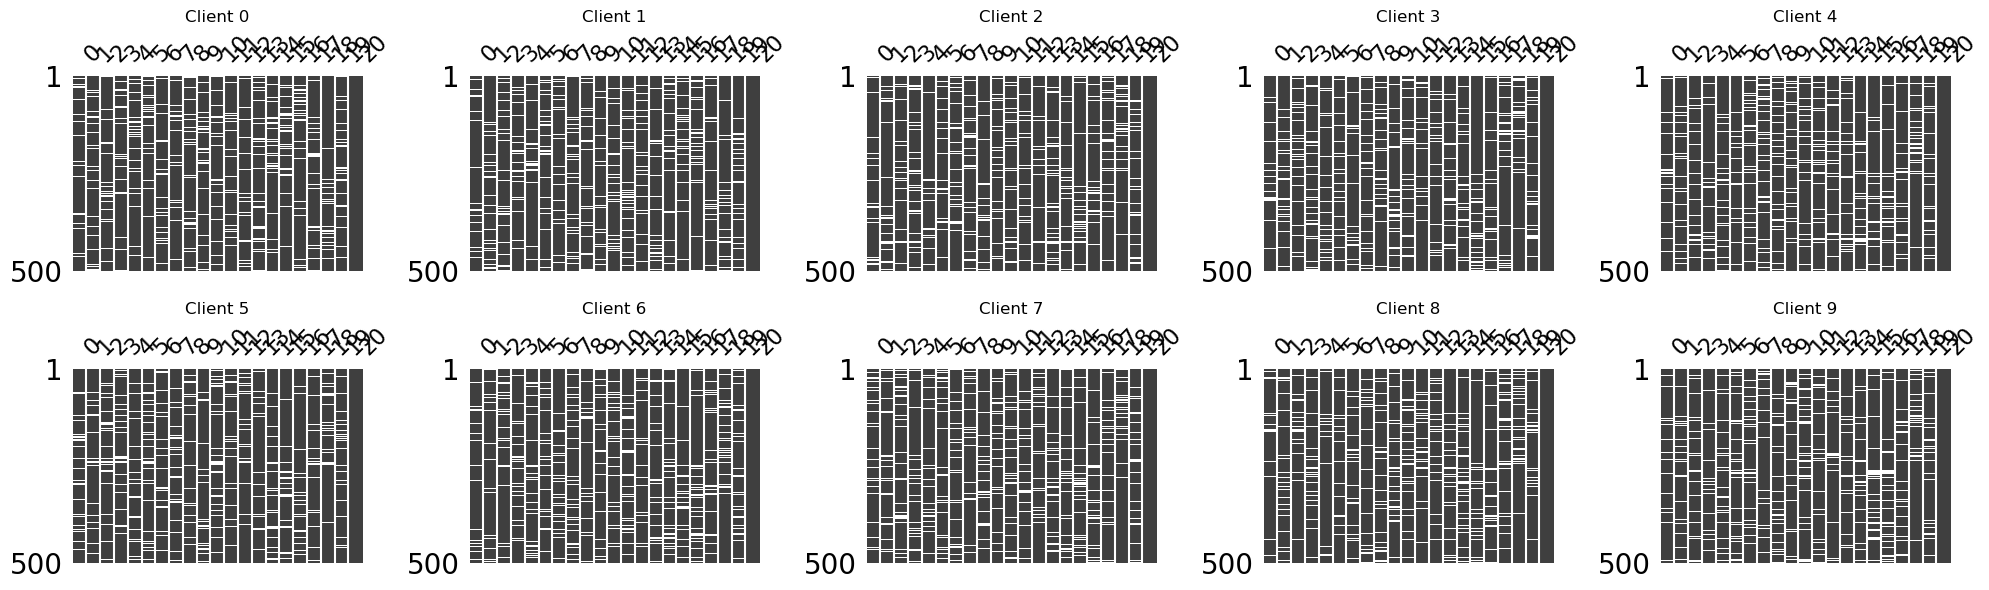

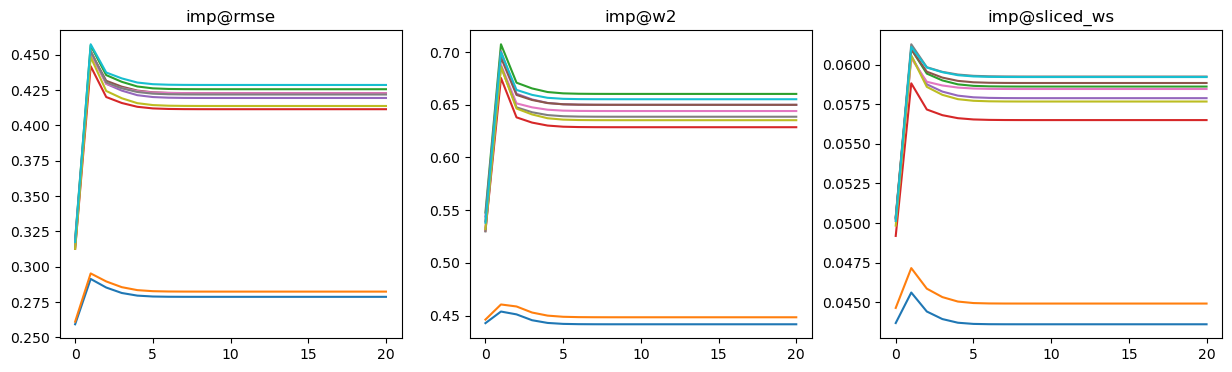

{'imp@rmse': 0.3927636943034839, 'imp@ws': 0.6052232944695161, 'imp@sliced_ws': 0.05550417432942159}


In [64]:
name = 'mnar_lr0.1_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.1'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.2'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['imputation']['clip'] = False
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 10:05:57.220 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 10:05:57.221 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 10:06:27.918 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 10:06:27.919 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 10:07:01.606 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 10:07:01.607 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 10:07:05.042 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 68.6932652000105


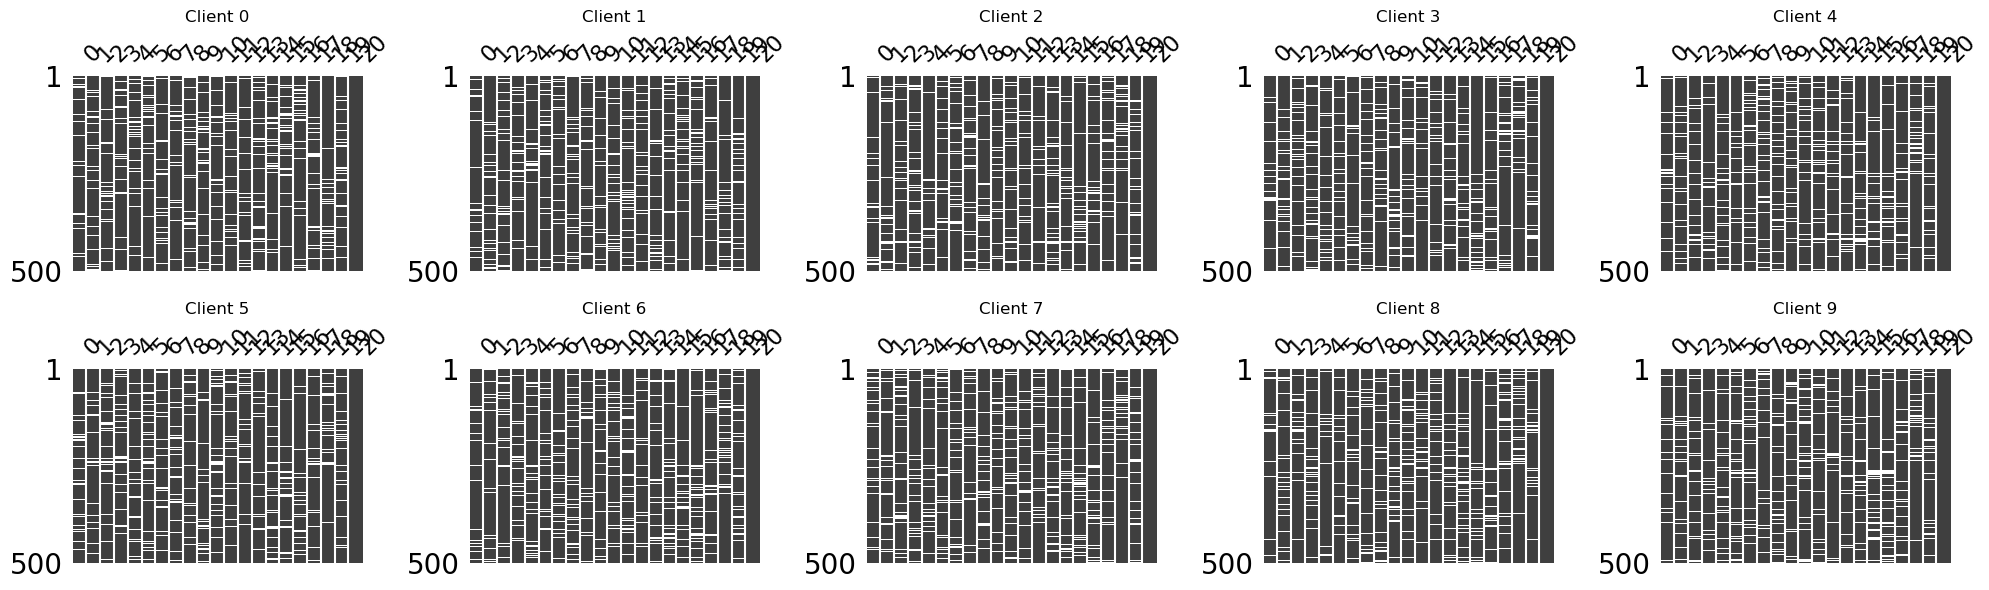

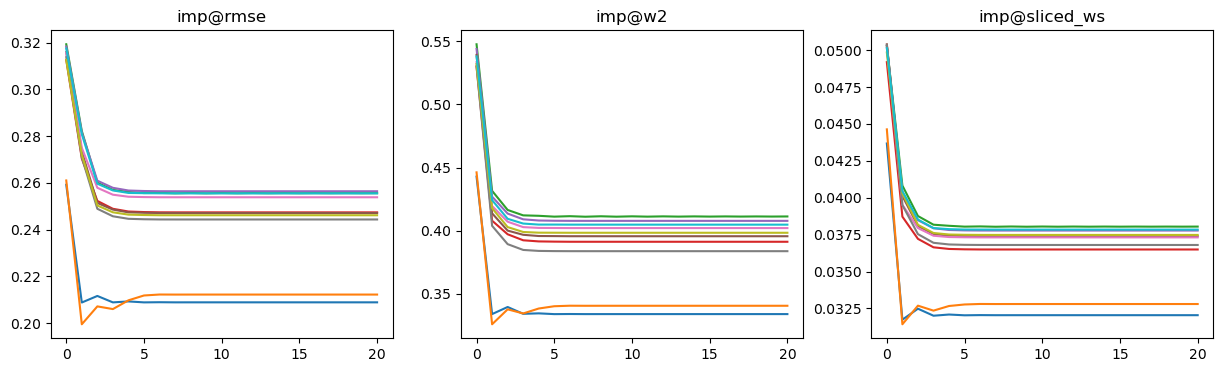

{'imp@rmse': 0.2427559588171611, 'imp@ws': 0.3868748158286545, 'imp@sliced_ws': 0.03639629192073633}


In [72]:
name = 'mnar_lr0.1_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.1'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.2'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['imputation']['clip'] = False
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## MNAR LR 0.1 0.9

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 10:37:12.531 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 10:37:12.532 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 10:37:43.815 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 10:37:43.816 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 10:38:17.533 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 10:38:17.534 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 10:38:20.940 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 69.33273879997432


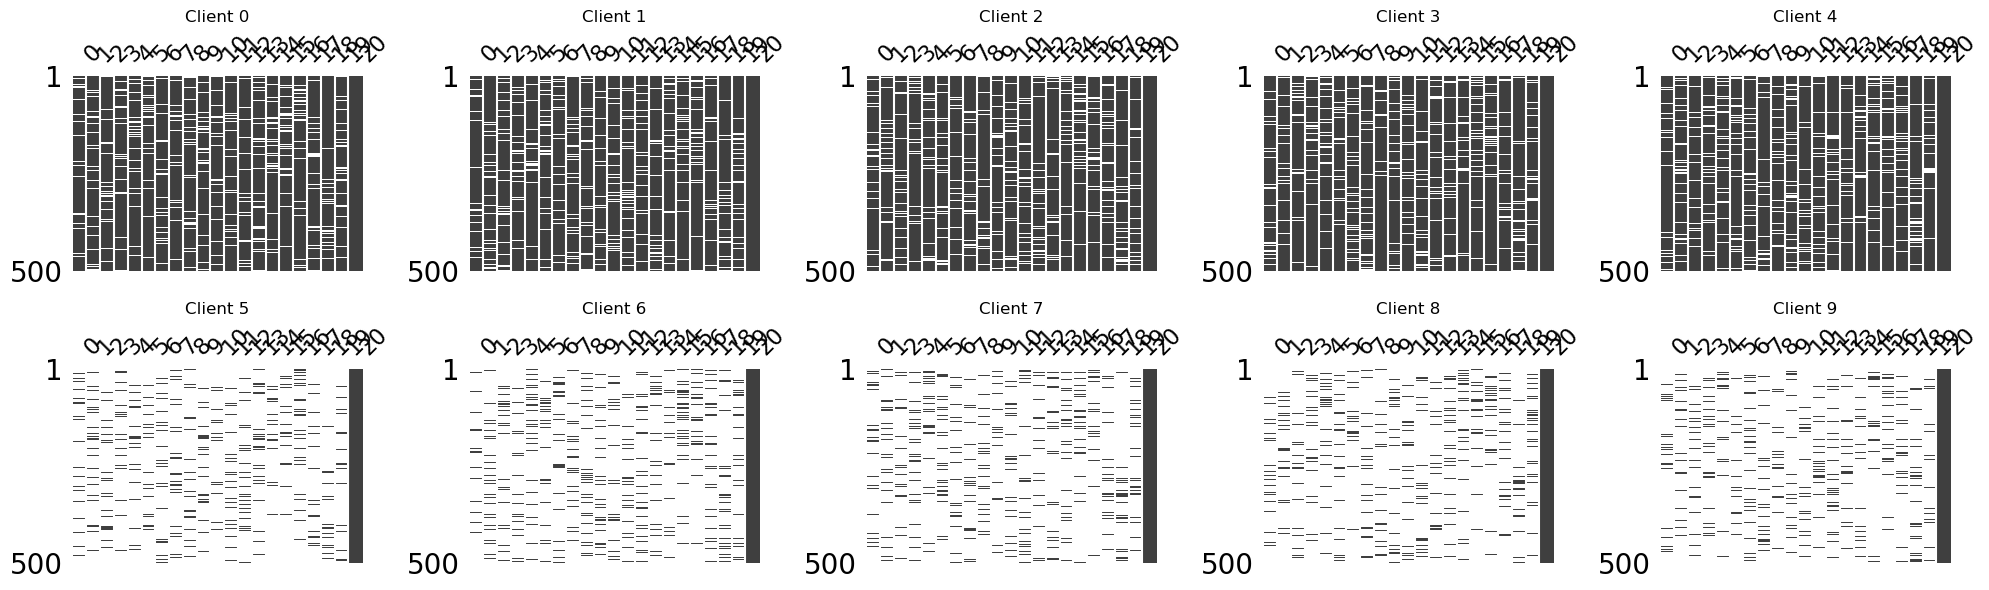

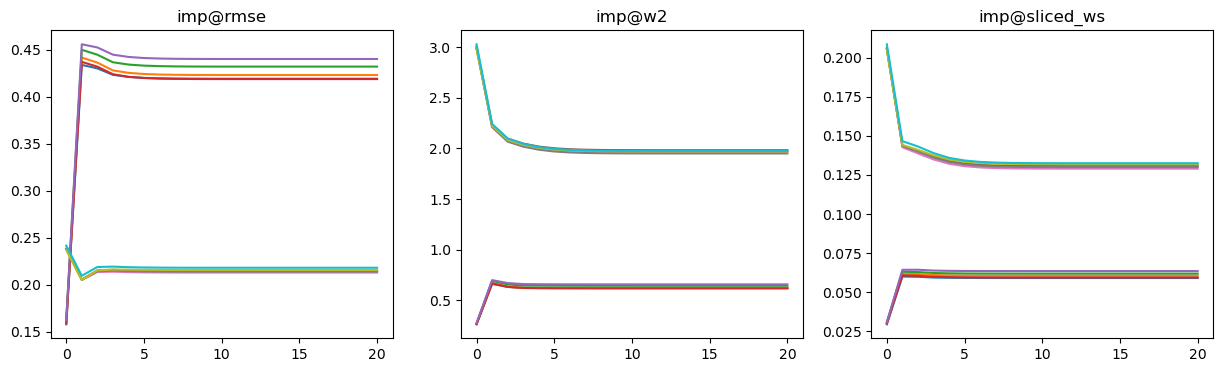

{'imp@rmse': 0.32095735456431557, 'imp@ws': 1.3009867596639768, 'imp@sliced_ws': 0.0958727837266464}


In [130]:
imp_strategy = 'fedavg-s'
name = 'mnar_lr0.19_{}'.format(imp_strategy)
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl@mr=0.1'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = imp_strategy
config2['imputation']['clip'] = False
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 10:38:37.859 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 10:38:37.860 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 10:39:09.216 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 10:39:09.217 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 10:39:43.925 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 10:39:43.926 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 10:39:47.446 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 70.46872970007826


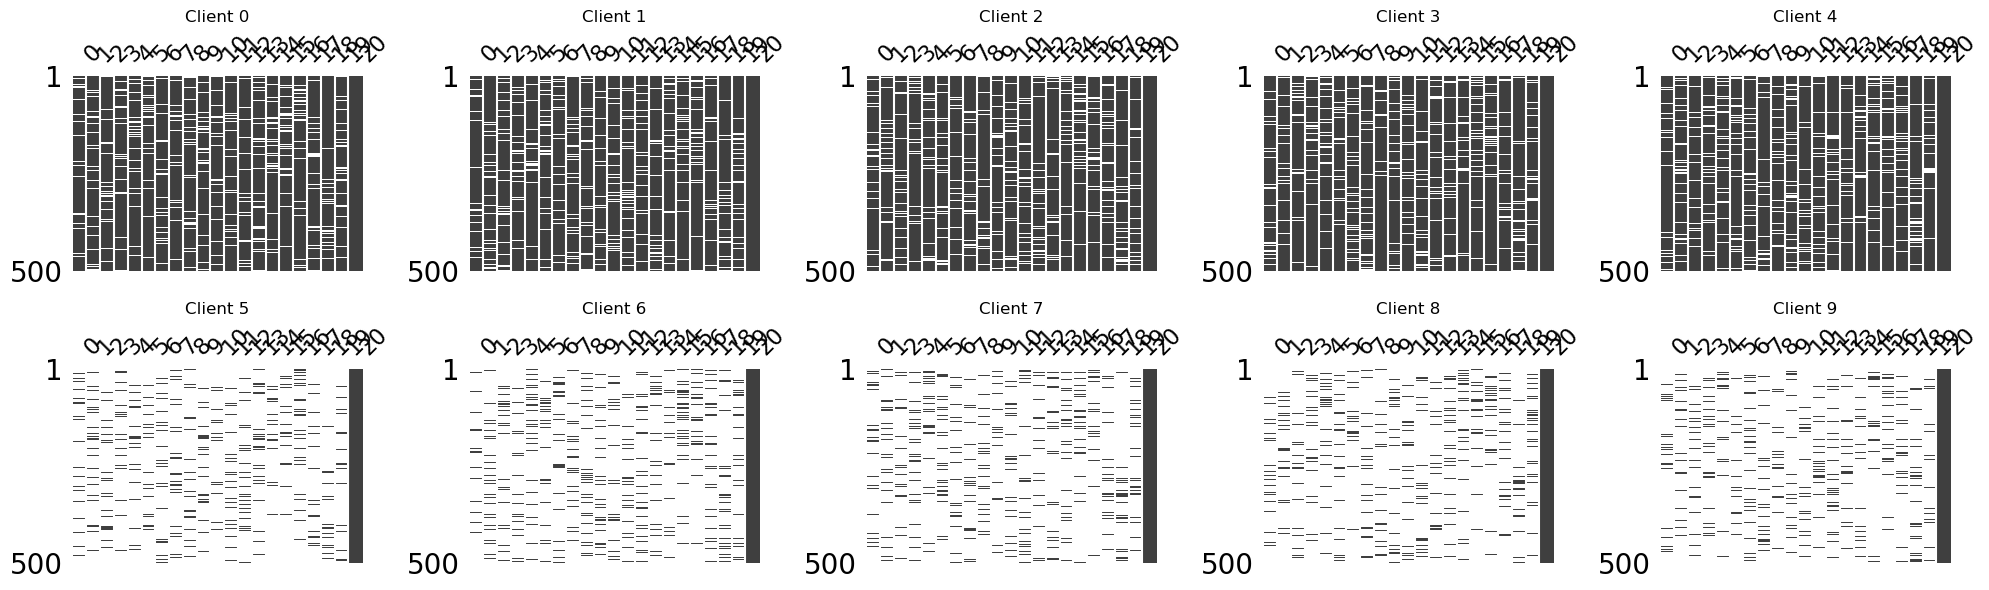

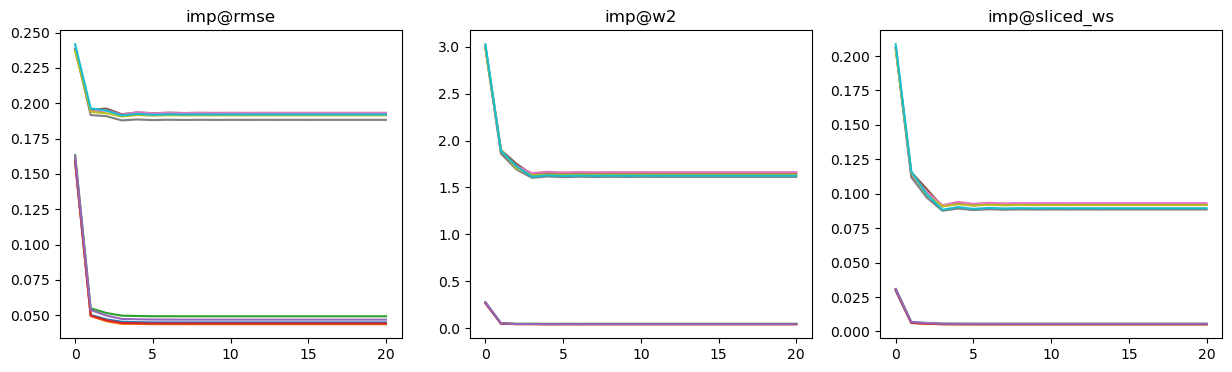

{'imp@rmse': 0.11868503362614248, 'imp@ws': 0.8393907078716368, 'imp@sliced_ws': 0.048200855383204226}


In [131]:
name = 'mnar_lr0.19_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl@mr=0.1'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['imputation']['clip'] = False
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## MNAR L 0.3 R 0.3 0.7

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left@0.3', 'mnar_quantile_left@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7']
(11051, 21)


2023-07-22 12:05:13.011 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 12:05:13.012 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 12:05:47.818 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 12:05:47.818 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 12:06:21.071 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 12:06:21.072 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 12:06:24.438 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 72.35005600005388


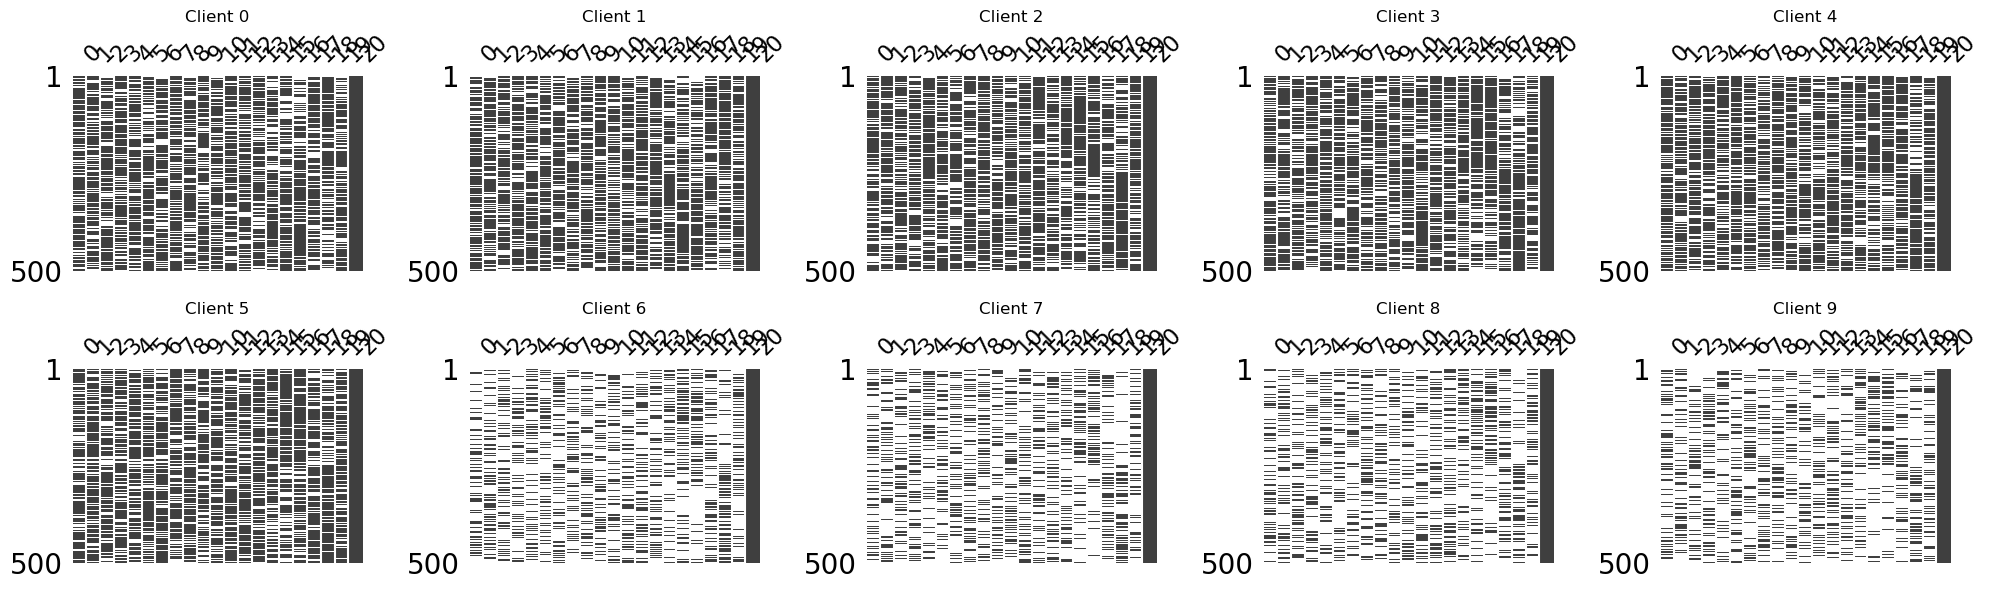

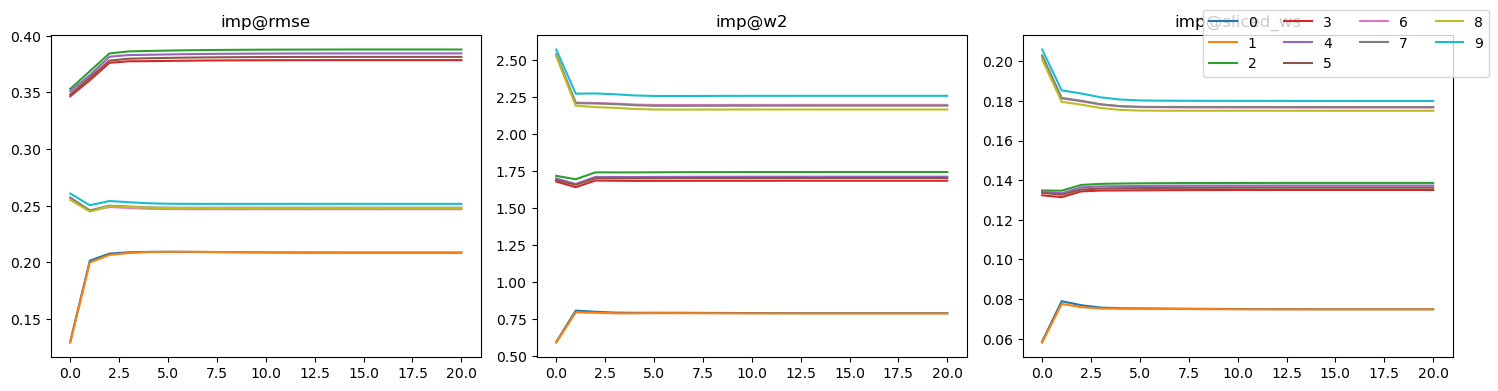

{'imp@rmse': 0.29441236993505315, 'imp@ws': 1.7243039417254198, 'imp@sliced_ws': 0.14052745381005627}


In [180]:
imp_strategy = 'fedavg-s'
name = 'mnar_lrr0.3_'.format(imp_strategy)
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl2@mr=0.3_m=nnc'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme3_r1=0.2_r2=0.4_m=lrr'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = imp_strategy
config2['imputation']['clip'] = False
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left@0.3', 'mnar_quantile_left@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.3', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7']
(11051, 21)


2023-07-22 12:06:41.300 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 12:06:41.301 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 12:07:12.143 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 12:07:12.144 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 12:07:46.140 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 12:07:46.141 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 12:07:49.587 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 69.20418489992153


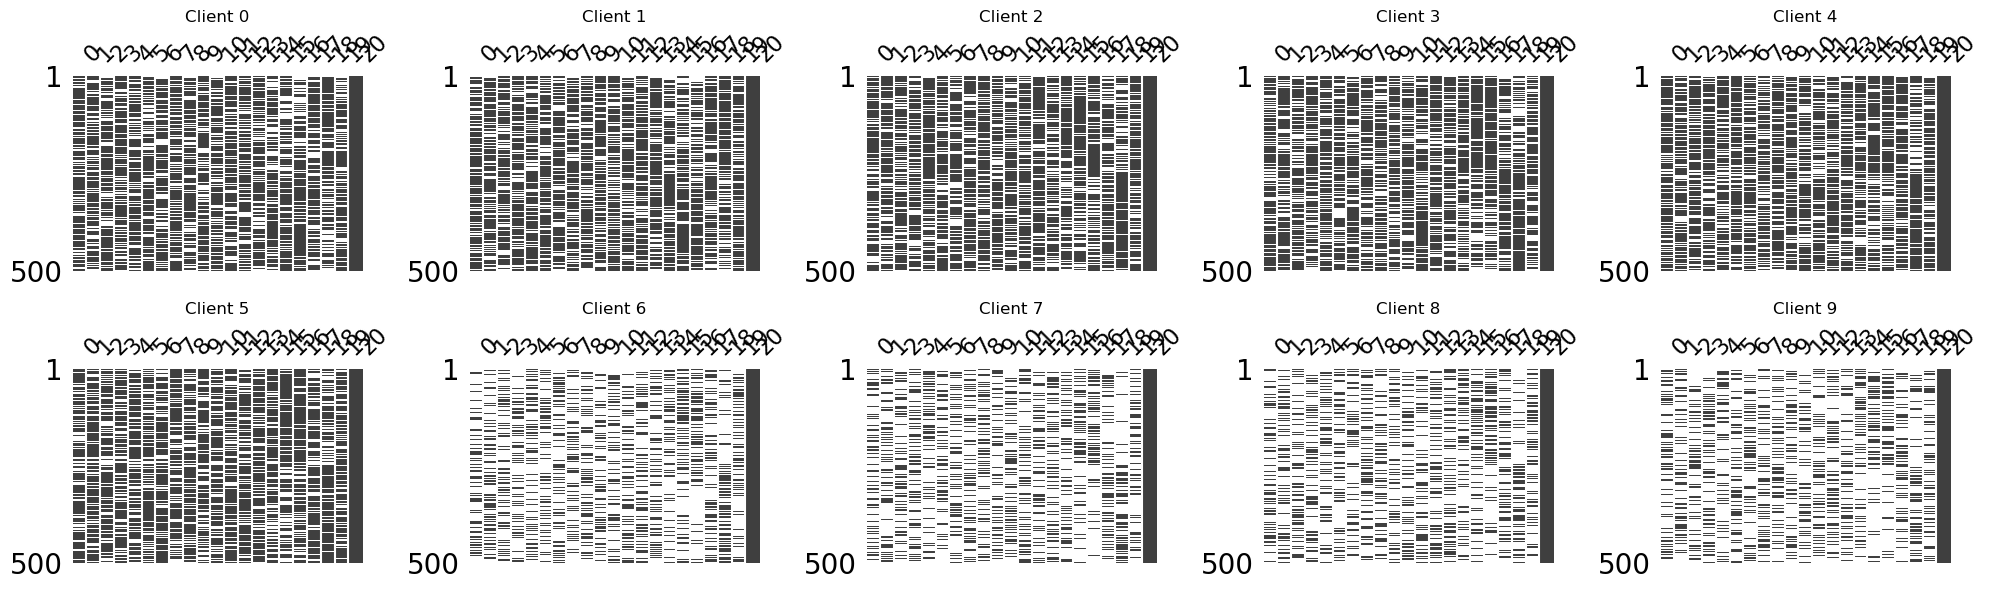

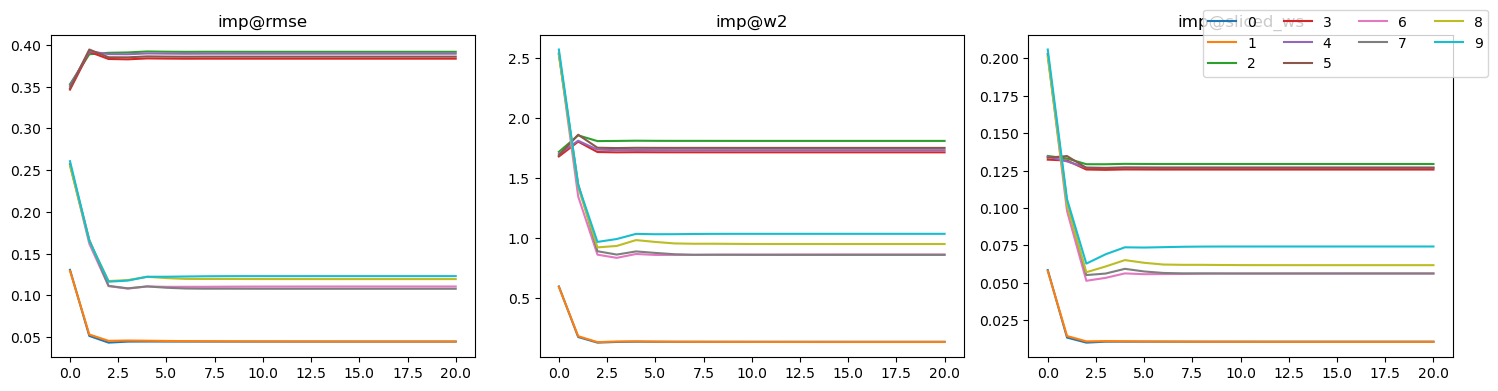

{'imp@rmse': 0.2101152227281812, 'imp@ws': 1.0973382987276523, 'imp@sliced_ws': 0.07792656388361703}


In [181]:
imp_strategy = 'fedmechw'
name = 'mnar_lrr0.3_'.format(imp_strategy)
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl2@mr=0.3_m=nnc'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme3_r1=0.2_r2=0.4_m=lrr'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = imp_strategy
config2['imputation']['clip'] = False
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## MNAR L 0.3 0.7 R 0.7

In [179]:
name = 'mnar_llr0.3_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl2@mr=0.3_m=ncc'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme3_r1=0.2_r2=0.4_m=llr'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['imputation']['clip'] = False
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

KeyboardInterrupt: 

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left@0.3', 'mnar_quantile_left@0.3', 'mnar_quantile_left@0.7', 'mnar_quantile_left@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7']
(11051, 21)


2023-07-22 11:55:33.458 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 11:55:33.459 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 11:56:04.486 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 11:56:04.486 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 11:56:40.382 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 11:56:40.383 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 11:56:43.928 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 71.3764819999924


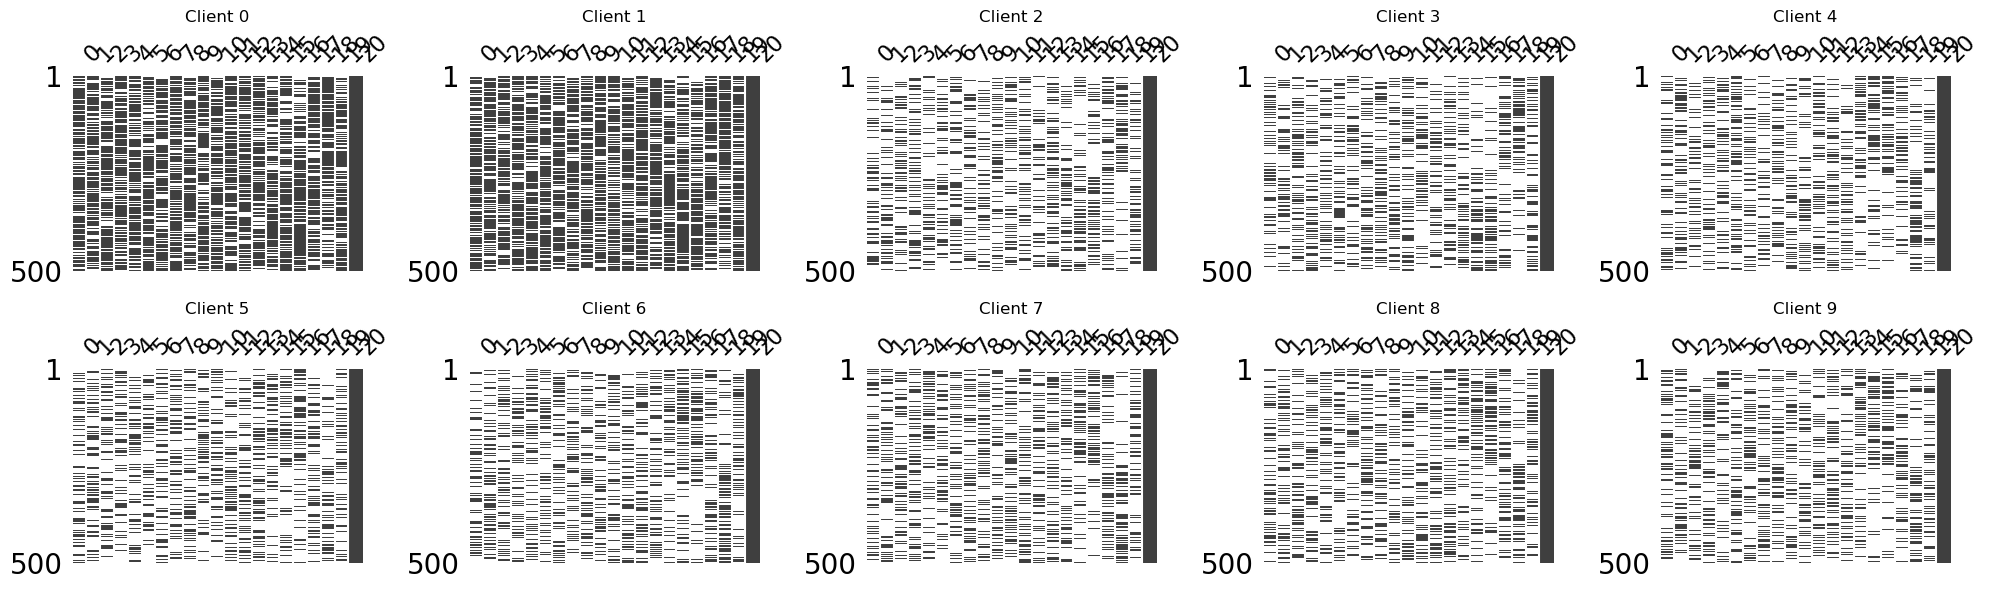

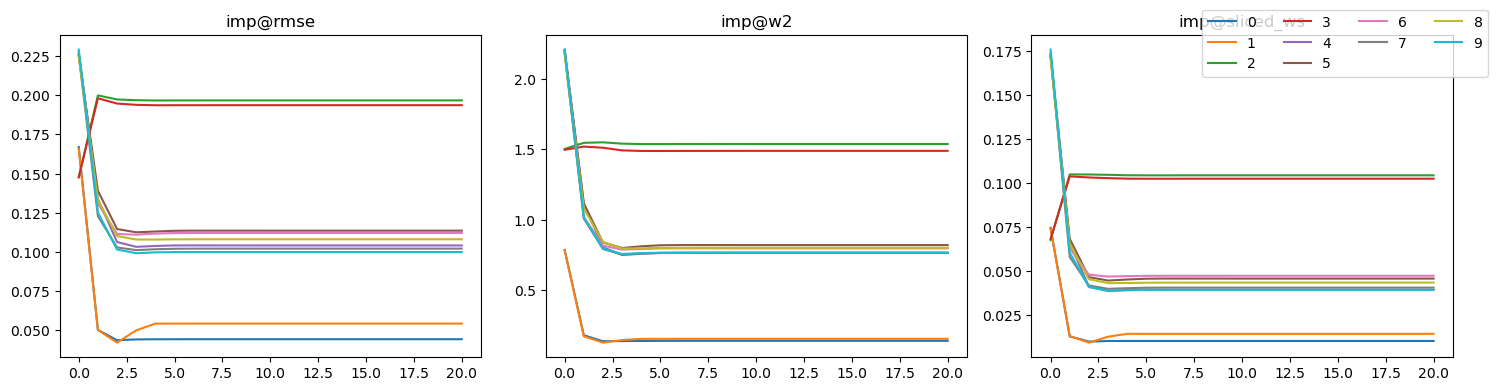

{'imp@rmse': 0.11296170509587512, 'imp@ws': 0.8027313613481016, 'imp@sliced_ws': 0.0488054654847535}


In [172]:
name = 'mnar_llr0.3_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl2@mr=0.3_m=ncc'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme3_r1=0.2_r2=0.4_m=llr'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['imputation']['clip'] = False
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## Training Models

In [149]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def vis_local_model_sim_lr(tracker1, tracker2, iteration, model = 'local', metric = 'mm'):
    n_cols = 4
    n_rows = 5

    ret1, ret2 = [], []
    for feature_idx in range(n_rows * n_cols):
        clients_records1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx]
        clients_records2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx]

        if model == 'local':
            X1 = clients_records1[0].local_imp_model_params
            X2 = clients_records2[0].local_imp_model_params
            ret1.append(X1)
            ret2.append(X2)
        elif model == 'mm':
            X1 = clients_records1[0].local_mm_model_params
            X2 = clients_records2[0].local_mm_model_params
            ret1.append(X1)
            ret2.append(X2)
        else:
            raise NotImplementedError
    
    ret1 = np.array(ret1)
    ret2 = np.array(ret2)

    for client_idx in range(n_rows * n_cols):
        print("========================================================")
        X1 = ret1[:, client_idx, :]
        X2 = ret2[:, client_idx, :]
        avg = []
        for feature_idx in range(X1.shape[0]):
            x1 = X1[feature_idx]
            x2 = X2[feature_idx]
            cos_sim = cosine_similarity(x1.reshape(1, -1), x2.reshape(1, -1))[0][0]
            print(
                "client {} feature {} - cos_sim between mary left and right local model {:4f}".
                format(client_idx, feature_idx, cos_sim)
            )
            avg.append(cos_sim)
        print("Avg cos sim all features local imputation model {:.4f}".format(np.mean(avg)))

def vis_local_model_sim(tracker, iteration, model = 'local', metric = 'cos'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        if metric == 'cos':
            cosine_sim = 1 - (cosine_similarity(X) + 1)/2
            print(cosine_sim.max(), cosine_sim.min())
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        elif metric == 'l2':
            cosine_sim = euclidean_distances(X)
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax)
        else:
            raise NotImplementedError
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def vis_local_model_sim_t(tracker, iteration, model = 'local'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        cosine_sim = 1 - (cosine_similarity(X) + 1)/2
        cosine_sim = np.where(cosine_sim > 0.4, 1, 0)
        sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def vis_local_model(tracker, iteration, model = 'local', decomp = 'PCA'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        if decomp == 'PCA':
            pca = PCA(n_components=2)
            decomp_results = pca.fit_transform(X)
        else:
            raise NotImplementedError
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        sns.scatterplot(
            x=decomp_results[:,0], y=decomp_results[:,1],
            palette=sns.color_palette("hls", 10),
            legend="full",
            ax=ax
        )
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def calculate_dis(iteration, tracker1, tracker2, what = 'data_imp'):
    n = 20
    if what == 'data_imp':
        for i in range(n):
            print(np.linalg.norm(tracker1.client_infos[i].data_imp[iteration] - tracker2.client_infos[i].data_imp[iteration]))
    elif what == 'local_model':
        for feature_idx in range(20):
            record1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            record2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            print(np.linalg.norm(record1.local_imp_model_params - record2.local_imp_model_params))

def vis_local_model_sim(tracker, iteration, model = 'local', metric = 'cos'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        if metric == 'cos':
            cosine_sim = 1 - (cosine_similarity(X) + 1)/2
            print(cosine_sim.max(), cosine_sim.min())
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        elif metric == 'l2':
            cosine_sim = euclidean_distances(X)
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax)
        else:
            raise NotImplementedError
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def vis_local_model_sim_t(tracker, iteration, model = 'local'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        cosine_sim = 1 - (cosine_similarity(X) + 1)/2
        cosine_sim = np.where(cosine_sim > 0.4, 1, 0)
        sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def vis_local_model(tracker, iteration, model = 'local', decomp = 'PCA'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        if decomp == 'PCA':
            pca = PCA(n_components=2)
            decomp_results = pca.fit_transform(X)
        else:
            raise NotImplementedError
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        sns.scatterplot(
            x=decomp_results[:,0], y=decomp_results[:,1],
            palette=sns.color_palette("hls", 10),
            legend="full",
            ax=ax
        )
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def calculate_dis(iteration, tracker1, tracker2, what = 'data_imp'):
    n = 20
    if what == 'data_imp':
        for i in range(n):
            print(np.linalg.norm(tracker1.client_infos[i].data_imp[iteration] - tracker2.client_infos[i].data_imp[iteration]))
    elif what == 'local_model':
        for feature_idx in range(20):
            record1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            record2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            print(np.linalg.norm(record1.local_imp_model_params - record2.local_imp_model_params))

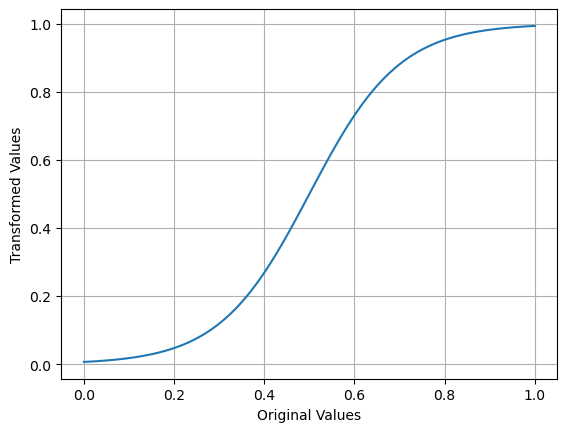

In [150]:
import numpy as np
import matplotlib.pyplot as plt

def transform_values(values):
    return 1 - 1 / (1 + np.exp(10 * (values - 0.5)))

# Generate a sequence of values between 0 and 1
values = np.linspace(0, 1, 100)

# Apply the transformation function
transformed_values = transform_values(values)

# Plot the transformation
plt.plot(values, transformed_values)
plt.xlabel('Original Values')
plt.ylabel('Transformed Values')
plt.grid(True)
plt.show()

### Debug

In [ ]:
# fetch data inside 1.5 quantile
def fetch_data(data, feature_idx, q = 0.95):
    ret = []
    feature_data = data[:, feature_idx]
    feature_data = feature_data[(feature_data > np.quantile(feature_data, 1-q)) & (feature_data < np.quantile(feature_data, q))]

    ret.append(feature_data)
    return np.array(ret).T

In [213]:
client_id = 0
client5_origin_data = rets['mnar_lr0.7_fedmechw']['data']['origin_data'][client_id, ...]
client5_imp_data = rets['mnar_lr0.7_fedmechw']['data']['imputed_data'][client_id, ...]
client5_msk = rets['mnar_lr0.7_fedmechw']['data']['missing_mask'][client_id, ...]
client5_imp_data_local = rets['mnar_lr0.7_local']['data']['imputed_data'][client_id, ...]
clients_imp_data_savg = rets['mnar_lr0.7_fedavg-s']['data']['imputed_data'][client_id,...]

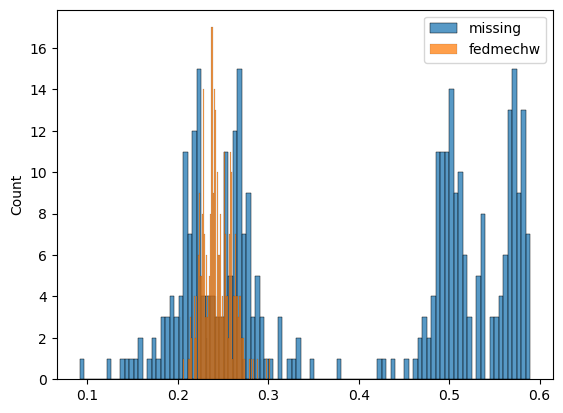

In [214]:
client_id = 0
client5_origin_data = rets['mnar_lr0.7_fedmechw']['data']['origin_data'][client_id, ...]
client5_imp_data = rets['mnar_lr0.7_fedmechw']['data']['imputed_data'][client_id, ...]
client5_msk = rets['mnar_lr0.7_fedmechw']['data']['missing_mask'][client_id, ...]
client5_imp_data_local = rets['mnar_lr0.7_local']['data']['imputed_data'][client_id, ...]
clients_imp_data_savg = rets['mnar_lr0.7_fedavg-s']['data']['imputed_data'][client_id,...]

feature_idx = 4
#sns.histplot(client5_origin_data[:, feature_idx][~client5_msk[:, feature_idx]], bins = 100, label = 'non-missing')
sns.histplot(client5_origin_data[:, feature_idx][client5_msk[:, feature_idx]], bins = 100, label = 'missing')
sns.histplot(client5_imp_data[:, feature_idx][client5_msk[:, feature_idx]], bins = 100, label = 'fedmechw')
#sns.histplot(client5_imp_data_local[:, feature_idx], bins = 100, label = 'local')
#sns.histplot(client5_imp_data_local[:, feature_idx][client5_msk[:, feature_idx]], bins = 100, label = 'local')
plt.legend()
#client5_imp_data1 = fetch_data(client5_imp_data, feature_idx, q = 0.99)
#sns.histplot(client5_imp_data1, bins = 200)

In [215]:
client_id = 6
client5_origin_data1 = rets['mnar_lr0.7_fedmechw']['data']['origin_data'][client_id, ...]
client5_imp_data1 = rets['mnar_lr0.7_fedmechw']['data']['imputed_data'][client_id, ...]
client5_msk1 = rets['mnar_lr0.7_fedmechw']['data']['missing_mask'][client_id, ...]
client5_imp_data_local1 = rets['mnar_lr0.7_local']['data']['imputed_data'][client_id, ...]
clients_imp_data_savg1 = rets['mnar_lr0.7_fedavg-s']['data']['imputed_data'][client_id,...]

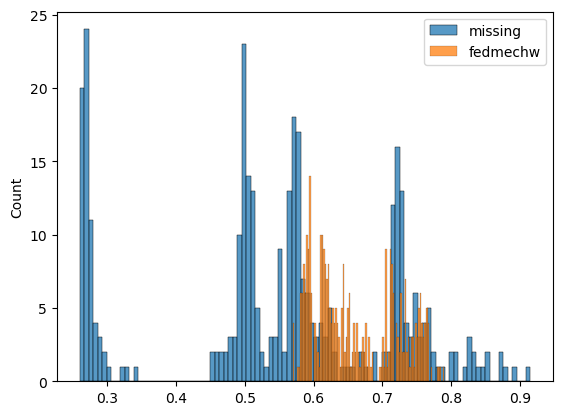

In [218]:
feature_idx = 4
#sns.histplot(client5_origin_data1[:, feature_idx][~client5_msk1[:, feature_idx]], bins = 100, label = 'non-missing')
sns.histplot(client5_origin_data1[:, feature_idx][client5_msk1[:, feature_idx]], bins = 100, label = 'missing')
sns.histplot(client5_imp_data1[:, feature_idx][client5_msk1[:, feature_idx]], bins = 100, label = 'fedmechw')
#sns.histplot(client5_imp_data_local[:, feature_idx], bins = 100, label = 'local')
#sns.histplot(client5_imp_data_local1[:, feature_idx][client5_msk1[:, feature_idx]], bins = 100, label = 'local')
plt.legend()
#client5_imp_data1 = fetch_data(client5_imp_data, feature_idx, q = 0.99)
#sns.histplot(client5_imp_data1, bins = 200)

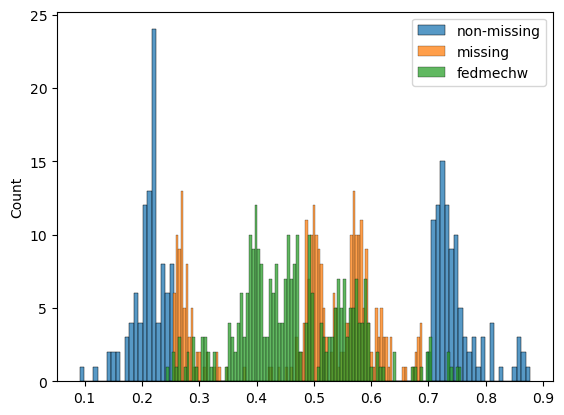

In [266]:
client_id = 0
client5_origin_data = rets['test_fedmechw']['data']['origin_data'][client_id, ...]
client5_imp_data = rets['test_fedmechw']['data']['imputed_data'][client_id, ...]
client5_msk = rets['test_fedmechw']['data']['missing_mask'][client_id, ...]
client5_imp_data_local = rets['test_local']['data']['imputed_data'][client_id, ...]
clients_imp_data_savg = rets['test_fedavg-s']['data']['imputed_data'][client_id,...]

feature_idx = 4
sns.histplot(client5_origin_data[:, feature_idx][~client5_msk[:, feature_idx]], bins = 100, label = 'non-missing')
sns.histplot(client5_origin_data[:, feature_idx][client5_msk[:, feature_idx]], bins = 100, label = 'missing')
sns.histplot(client5_imp_data[:, feature_idx][client5_msk[:, feature_idx]], bins = 100, label = 'fedmechw')
#sns.histplot(client5_imp_data_local[:, feature_idx], bins = 100, label = 'local')
#sns.histplot(client5_imp_data_local[:, feature_idx][client5_msk[:, feature_idx]], bins = 100, label = 'local')
plt.legend()
#client5_imp_data1 = fetch_data(client5_imp_data, feature_idx, q = 0.99)
#sns.histplot(client5_imp_data1, bins = 200)

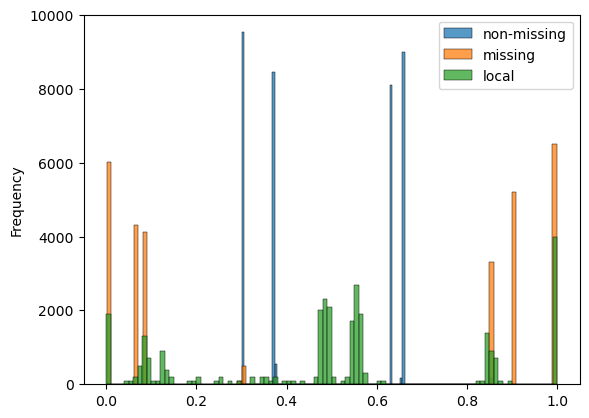

In [356]:
client_id = 9
client5_origin_data = rets['test_fedmechw']['data']['origin_data'][client_id, ...]
client5_imp_data = rets['test_fedmechw']['data']['imputed_data'][client_id, ...]
client5_msk = rets['test_fedmechw']['data']['missing_mask'][client_id, ...]
client5_imp_data_local = rets['test_local']['data']['imputed_data'][client_id, ...]
client5_imp_data_savg = rets['test_fedavg-s']['data']['imputed_data'][client_id,...]
client5_imp_data_testavg = rets['test_testavg']['data']['imputed_data'][client_id,...]

feature_idx = 9
sns.histplot(client5_origin_data[:, feature_idx][~client5_msk[:, feature_idx]], bins = 100, label = 'non-missing', stat = 'frequency')
sns.histplot(client5_origin_data[:, feature_idx][client5_msk[:, feature_idx]], bins = 100, label = 'missing', stat = 'frequency')
#sns.histplot(client5_imp_data[:, feature_idx][client5_msk[:, feature_idx]], bins = 100, label = 'fedmechw', stat = 'frequency')
#sns.histplot(client5_imp_data_local[:, feature_idx], bins = 100, label = 'local')
sns.histplot(client5_imp_data_testavg[:, feature_idx][client5_msk[:, feature_idx]], bins = 100, label = 'local', stat = 'frequency')
plt.legend()
#client5_imp_data1 = fetch_data(client5_imp_data, feature_idx, q = 0.99)
#sns.histplot(client5_imp_data1, bins = 200)

In [347]:
client5_origin_data[:, feature_idx][~client5_msk[:, feature_idx]].shape
client5_imp_data_testavg.shape

(500, 21)

### Local Models

In [219]:
trackers.keys()

dict_keys(['mnar_lr0.3_fedmechw', 'mnar_lr0.3_fedmechw1', 'mnar_lr0.3_local', 'mnar_lr0.3_savg', 'mnar_lr0.1_fedmechw', 'mnar_lr0.1_savg', 'mnar_lr0.19_fedmechw', 'mnar_lr0.19_fedavg-s', 'mnar_llr0.3_fedmechw', 'mnar_llr0.3_savg', 'mnar_lrr0.3_', 'mnar_lr0.7_fedavg-s', 'mnar_lr0.7_fedmechw', 'mnar_lr0.7_local'])

In [264]:
tracker0 = trackers['mnar_lr0.7_fedmechw']
tracker2 = trackers['mnar_lr0.7_fedavg-s']
tracker3 = trackers['mnar_lr0.37_fedmechw']
tracker4 = trackers['test_fedmechw']
tracker5 = trackers['test_local']

0.37225979502894746 0.0
0.3993801201926539 -2.220446049250313e-16
0.4275155589540357 0.0
0.3277297036856812 0.0
0.5330311188850895 0.0
0.36277979314078246 0.0
0.41755369485175 -2.220446049250313e-16
0.5661796911296796 -2.220446049250313e-16
0.2586390344943664 0.0
0.32529194487761126 0.0
0.0787064280757026 -2.220446049250313e-16
0.4700596208881904 0.0
0.5026688389565706 0.0
0.3911020431097515 -2.220446049250313e-16
0.13564545698056119 0.0
0.7056949435784824 0.0
0.003435922242981171 0.0
0.19763184301417414 0.0
0.049703431508444806 0.0
0.04313313026408716 0.0


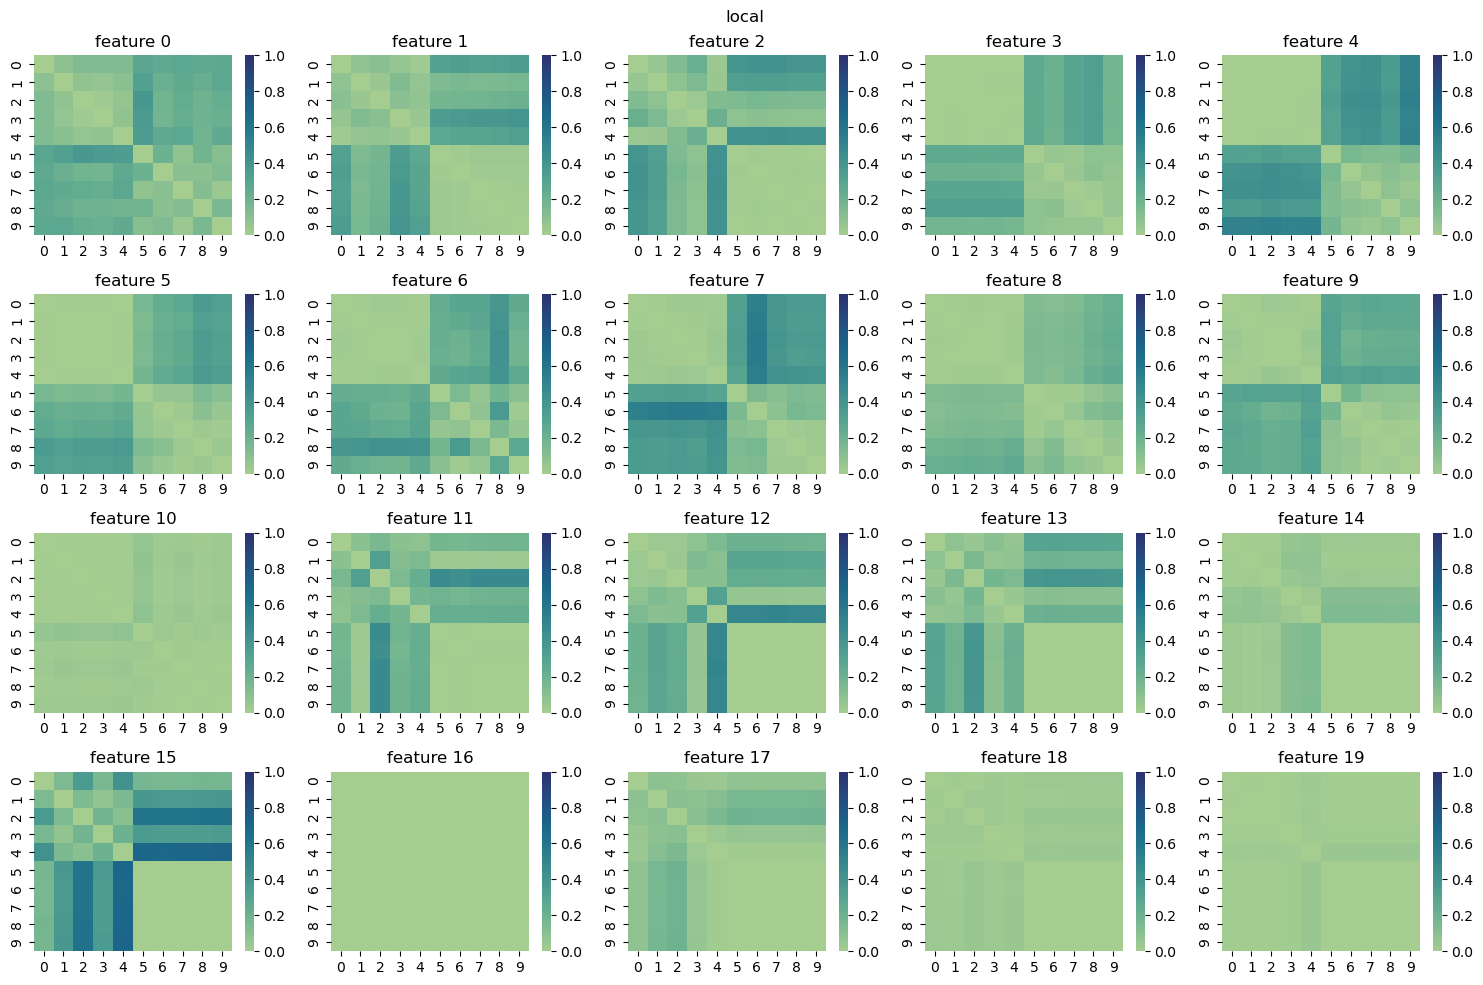

In [254]:
vis_local_model_sim(tracker5, iteration = 20, model='local')

0.7615585739772424 -2.220446049250313e-16
0.7671134296924889 0.0
0.6044569101886237 0.0
0.46552495703709806 0.0
0.42187968026150446 0.0
0.7194522041586606 -2.220446049250313e-16
0.6350150073101899 0.0
0.7082281772050052 0.0
0.44163034661369716 0.0
0.4964164476907371 0.0
0.742974950395487 -2.220446049250313e-16
0.695077576425104 -2.220446049250313e-16
0.6849192565227821 0.0
0.8966509619429921 0.0
0.4405460375470045 0.0
0.5198359184470652 -2.220446049250313e-16
0.6725760954409166 0.0
0.8407837579567519 0.0
0.8131426419531238 0.0
0.8876803617442339 -2.220446049250313e-16


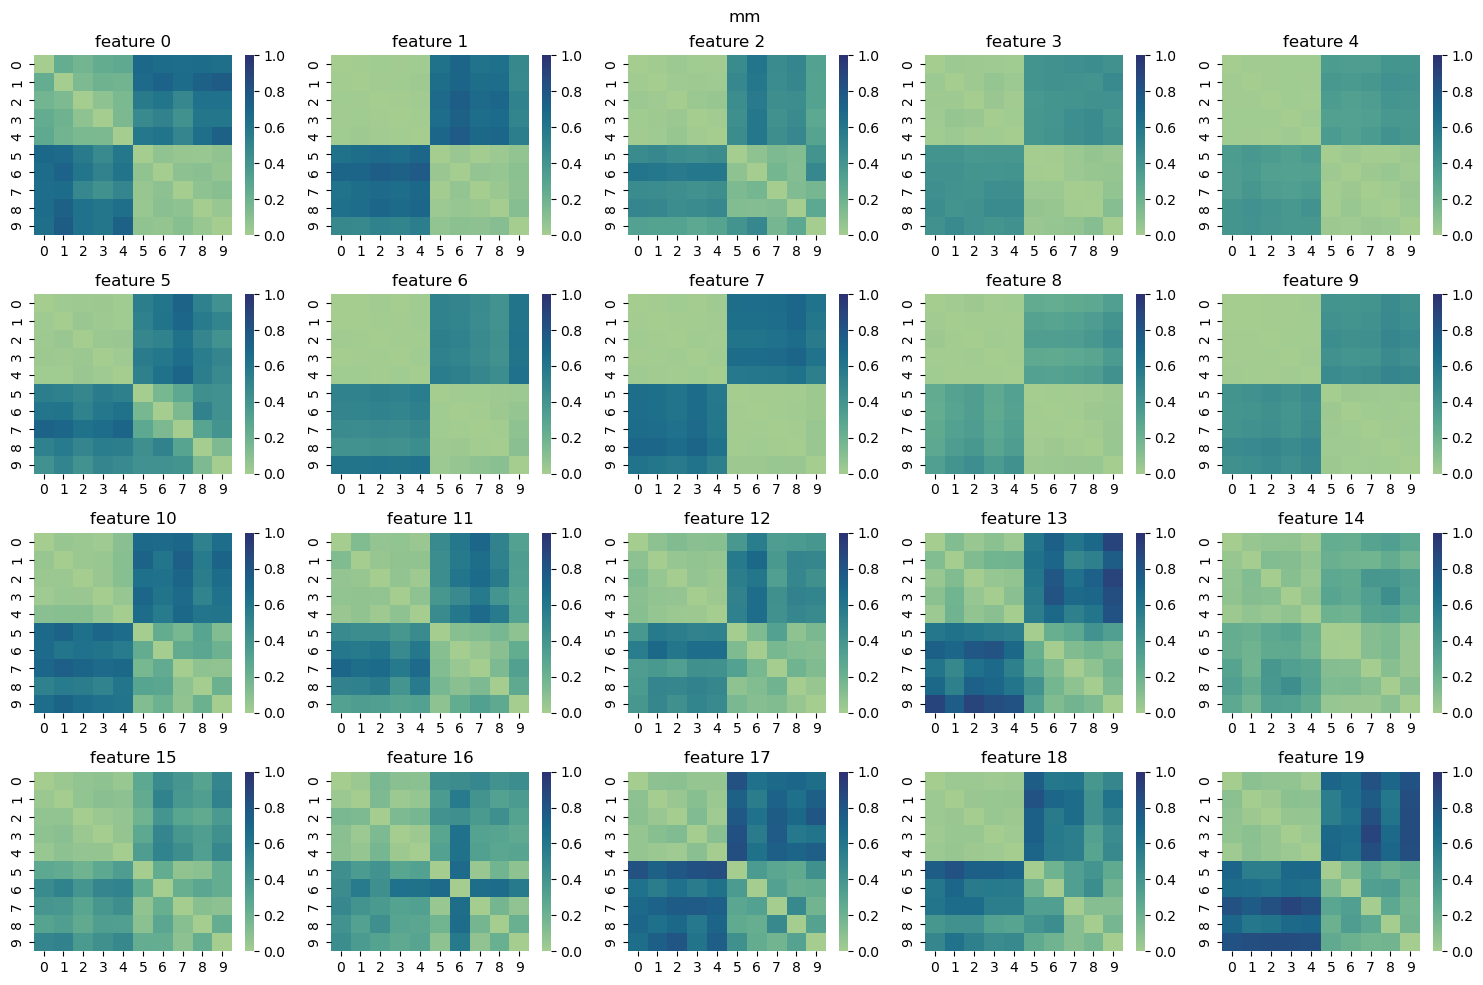

In [265]:
vis_local_model_sim(tracker4, iteration = 20, model='mm')

0.8341636594992248 -2.220446049250313e-16
0.8337529837727746 0.0
0.8462321237385313 0.0
0.8782764121809638 -2.220446049250313e-16
0.6934945569379949 0.0
0.8943597944168544 -2.220446049250313e-16
0.8283960099957498 0.0
0.8591079396592387 0.0
0.9516994538245351 0.0
0.9328913137292356 0.0
0.8230520610375596 0.0
0.898824809916646 0.0
0.8989176722901637 0.0
0.8491148366302661 0.0
0.812037441393114 -2.220446049250313e-16
0.7547772385701308 0.0
0.8352474011995228 -2.220446049250313e-16
0.8441433831206278 -2.220446049250313e-16
0.9414574993519546 0.0
0.8101778739015144 0.0


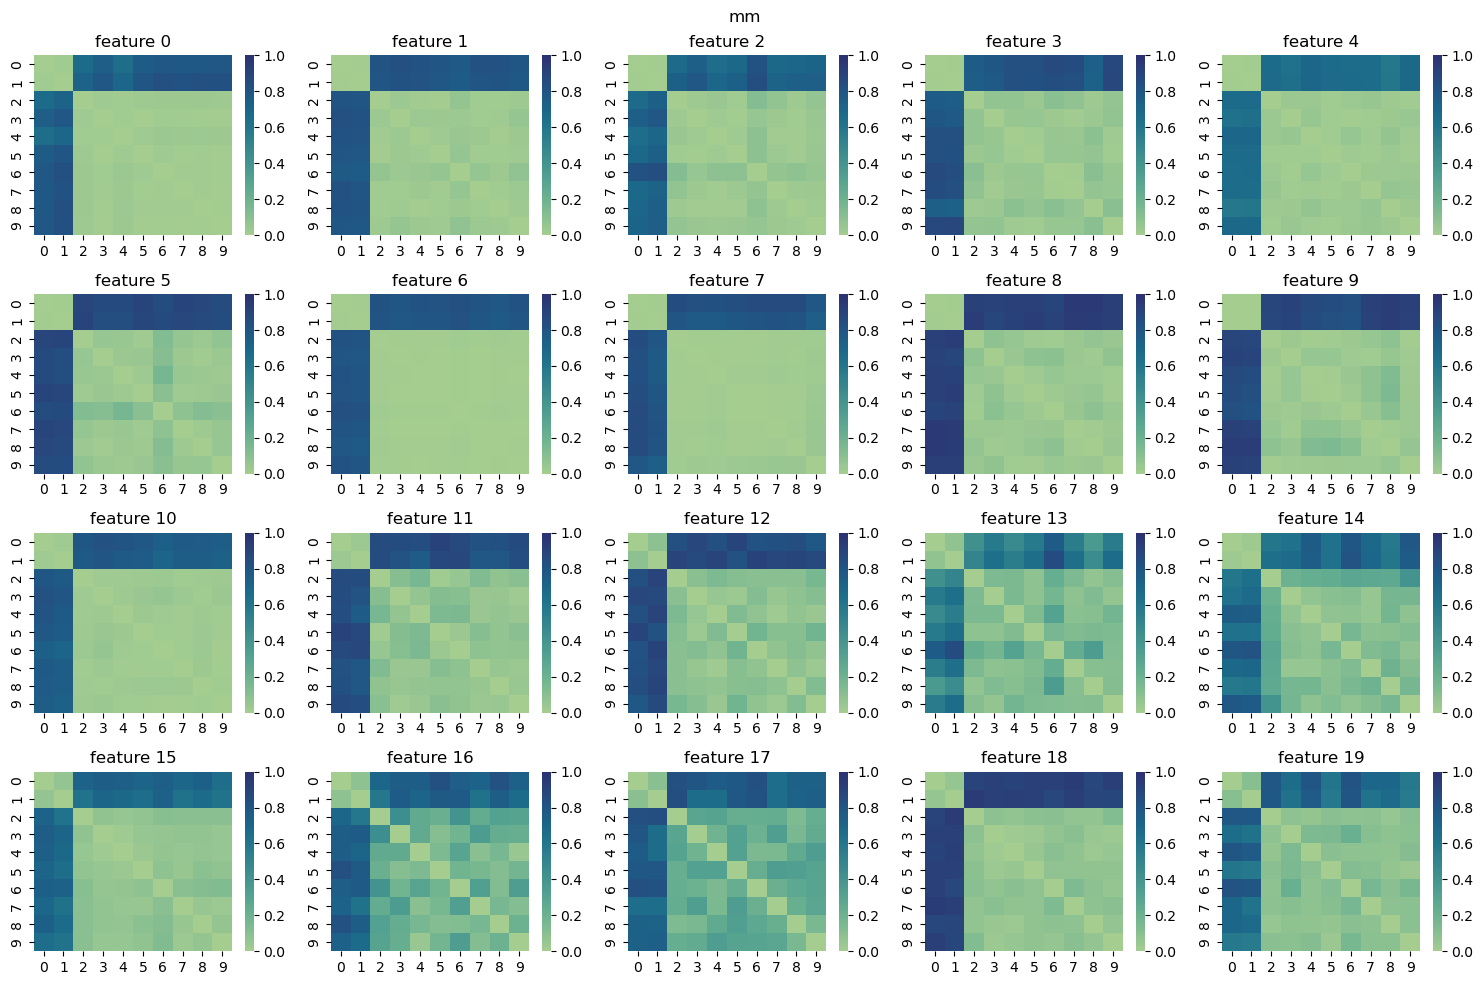

In [231]:
vis_local_model_sim(tracker3, iteration = 1, model='mm')

0.9860250890313507 -2.220446049250313e-16
0.8730773259672683 -2.220446049250313e-16
0.9265685920708249 -2.220446049250313e-16
0.9311889068508427 0.0
0.9129252875438366 0.0
0.9745641778735181 -2.220446049250313e-16
0.9284712027111016 -2.220446049250313e-16
0.9778171711326659 0.0
0.9785880261781894 0.0
0.9560707745624883 0.0
0.9572656352201749 0.0
0.9049823107421626 -2.220446049250313e-16
0.9139365861982452 0.0
0.8959577736171447 -2.220446049250313e-16
0.8626928813035472 -2.220446049250313e-16
0.9209896648285752 -2.220446049250313e-16
0.8722084421079817 -2.220446049250313e-16
0.962053889713494 0.0
0.8681042479182081 0.0
0.901106186532246 0.0


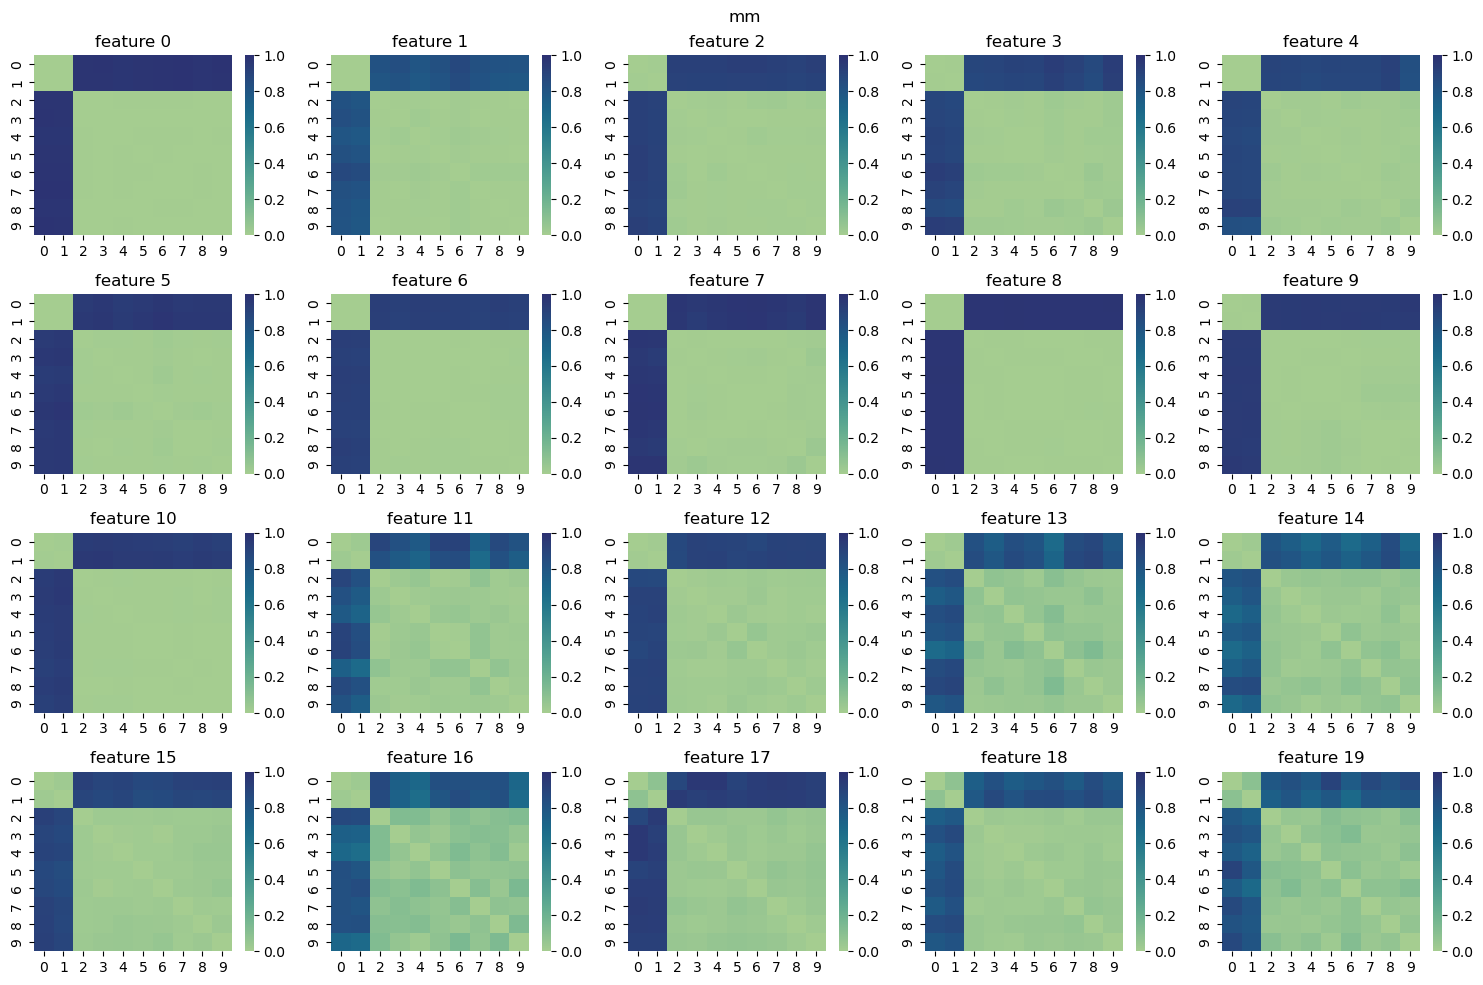

In [225]:
vis_local_model_sim(tracker0, iteration = 20, model='mm')

In [221]:
def calculate_dis(iteration, tracker1, tracker2, what = 'data_imp'):
    n = 20
    if what == 'data_imp':
        for i in range(n):
            print(np.linalg.norm(tracker1.client_infos[i].data_imp[iteration] - tracker2.client_infos[i].data_imp[iteration]))
    elif what == 'local_model':
        for feature_idx in range(20):
            record1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            record2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            print(np.linalg.norm(record1.local_imp_model_params - record2.local_imp_model_params))

In [218]:
calculate_dis(0, tracker, tracker2)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [224]:
calculate_dis(1, tracker, tracker2, what = 'local_model')

0.0
1.6337764897152576
1.5702846497335994
0.5004458163916409
1.3448007010580283
1.9703069642747753
7.092822298471598
4.107754167615582
2.3113705599253667
2.6584593576326214
3.5720236606869196
0.6173539228937241
0.8044787428567401
0.5814388400454863
0.5877724712278766
1.1204952547227718
0.7345322421861542
1.1153722099686756
2.1486559810471793
0.793473354314416


### Mechanism Model

##### Local

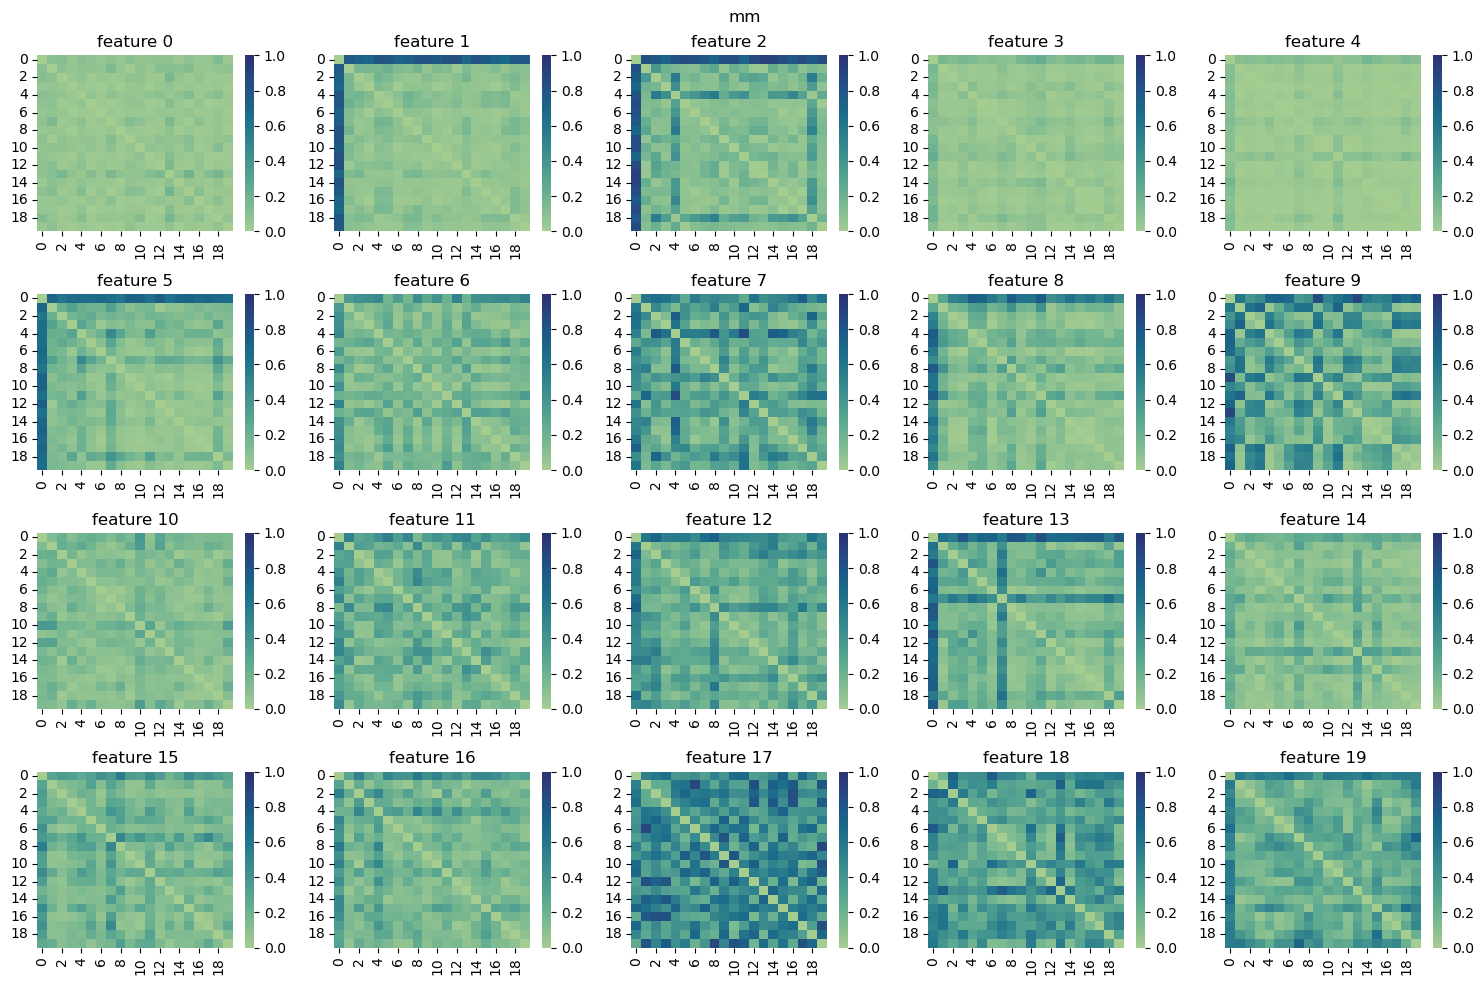

In [810]:
vis_local_model_sim(tracker0, iteration = 1, model = 'mm')

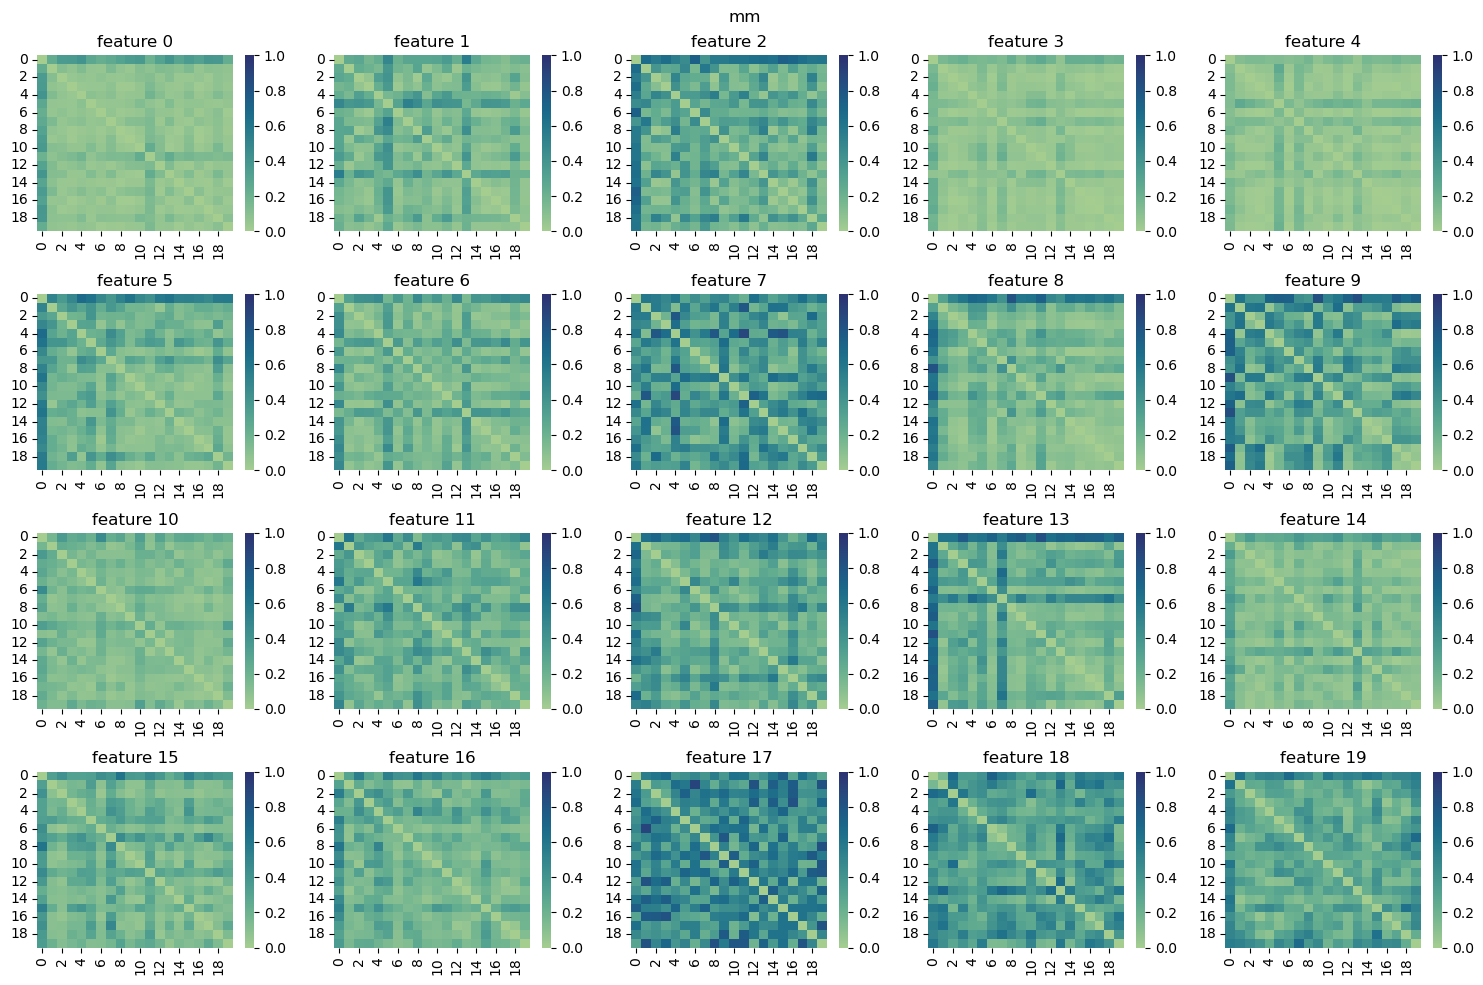

In [811]:
vis_local_model_sim(tracker0, iteration = 4, model = 'mm')

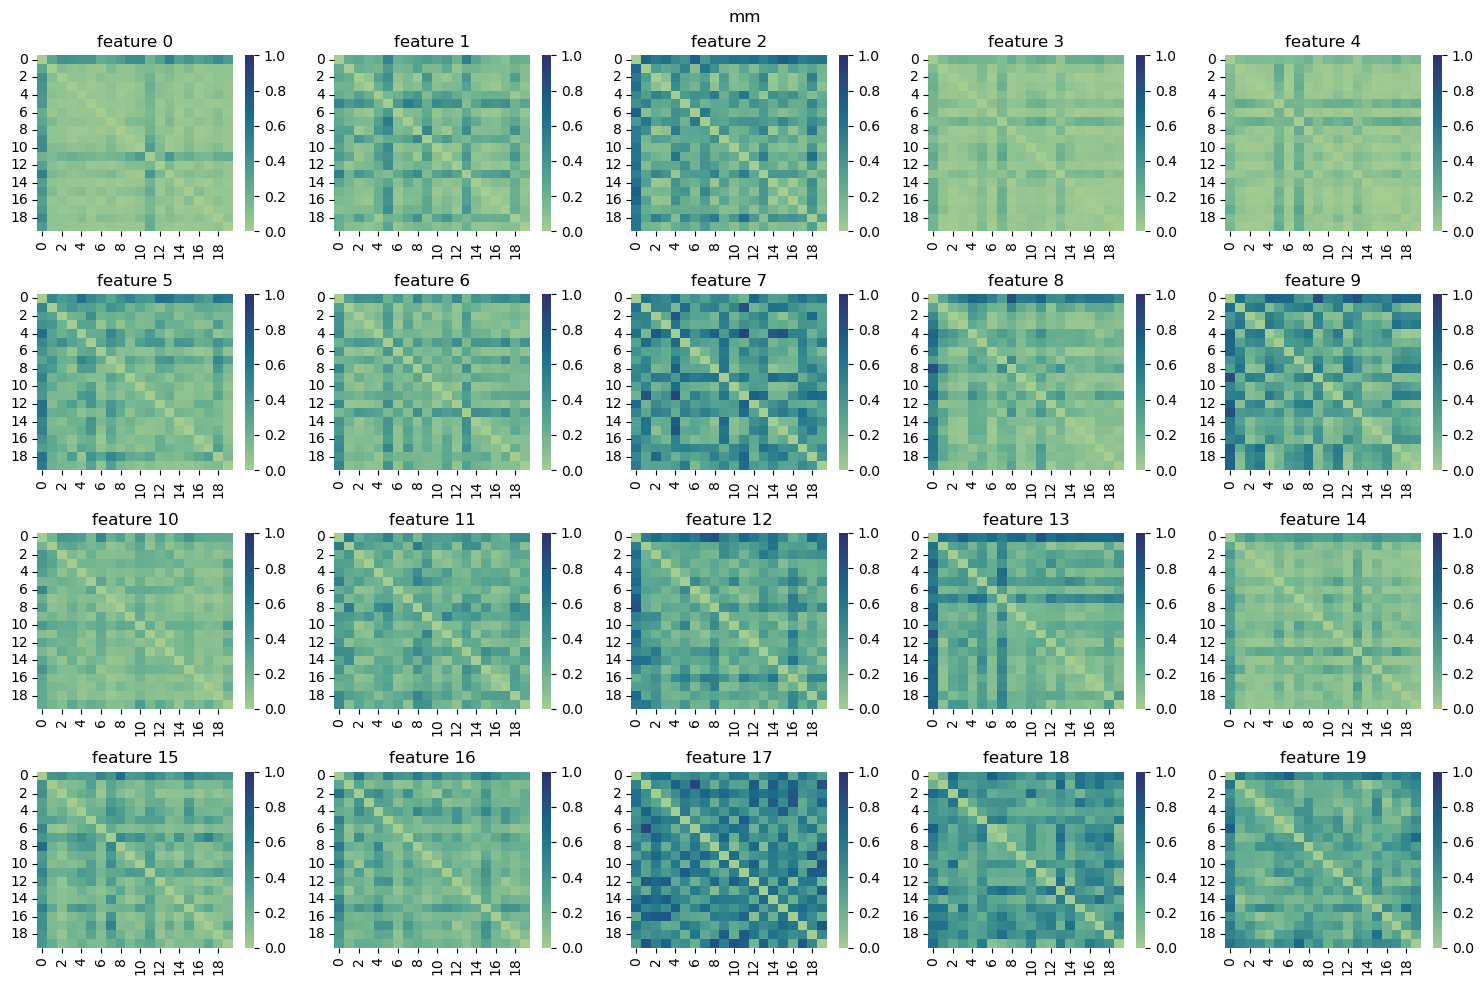

In [812]:
vis_local_model_sim(tracker0, iteration = 20, model='mm')

##### SimpleAVG

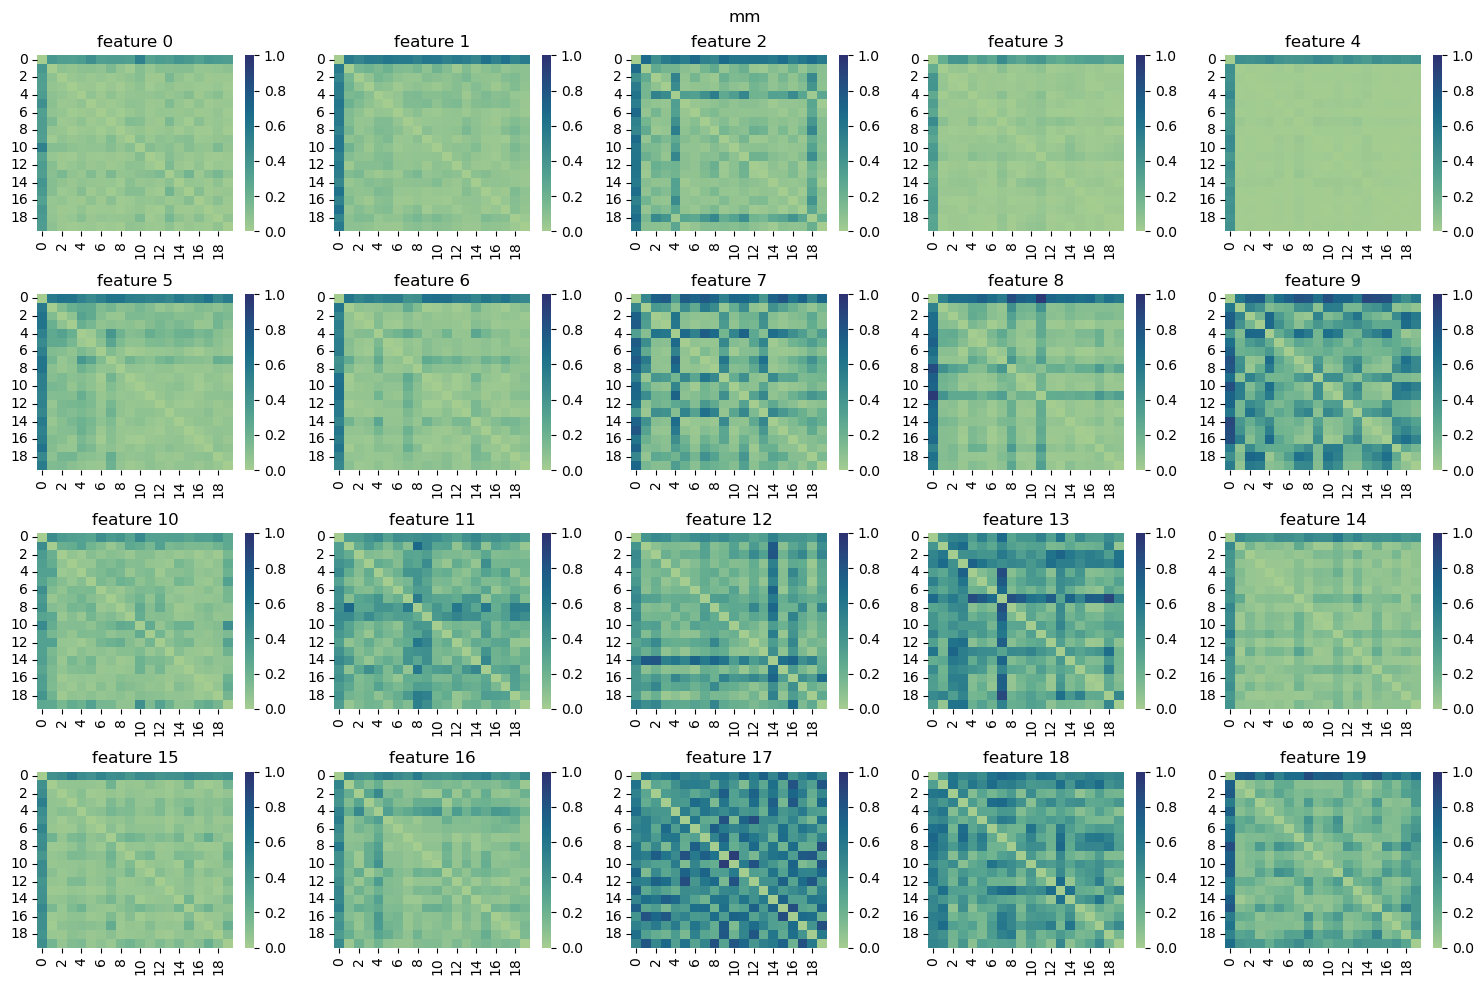

In [813]:
vis_local_model_sim(tracker, iteration = 1, model='mm')

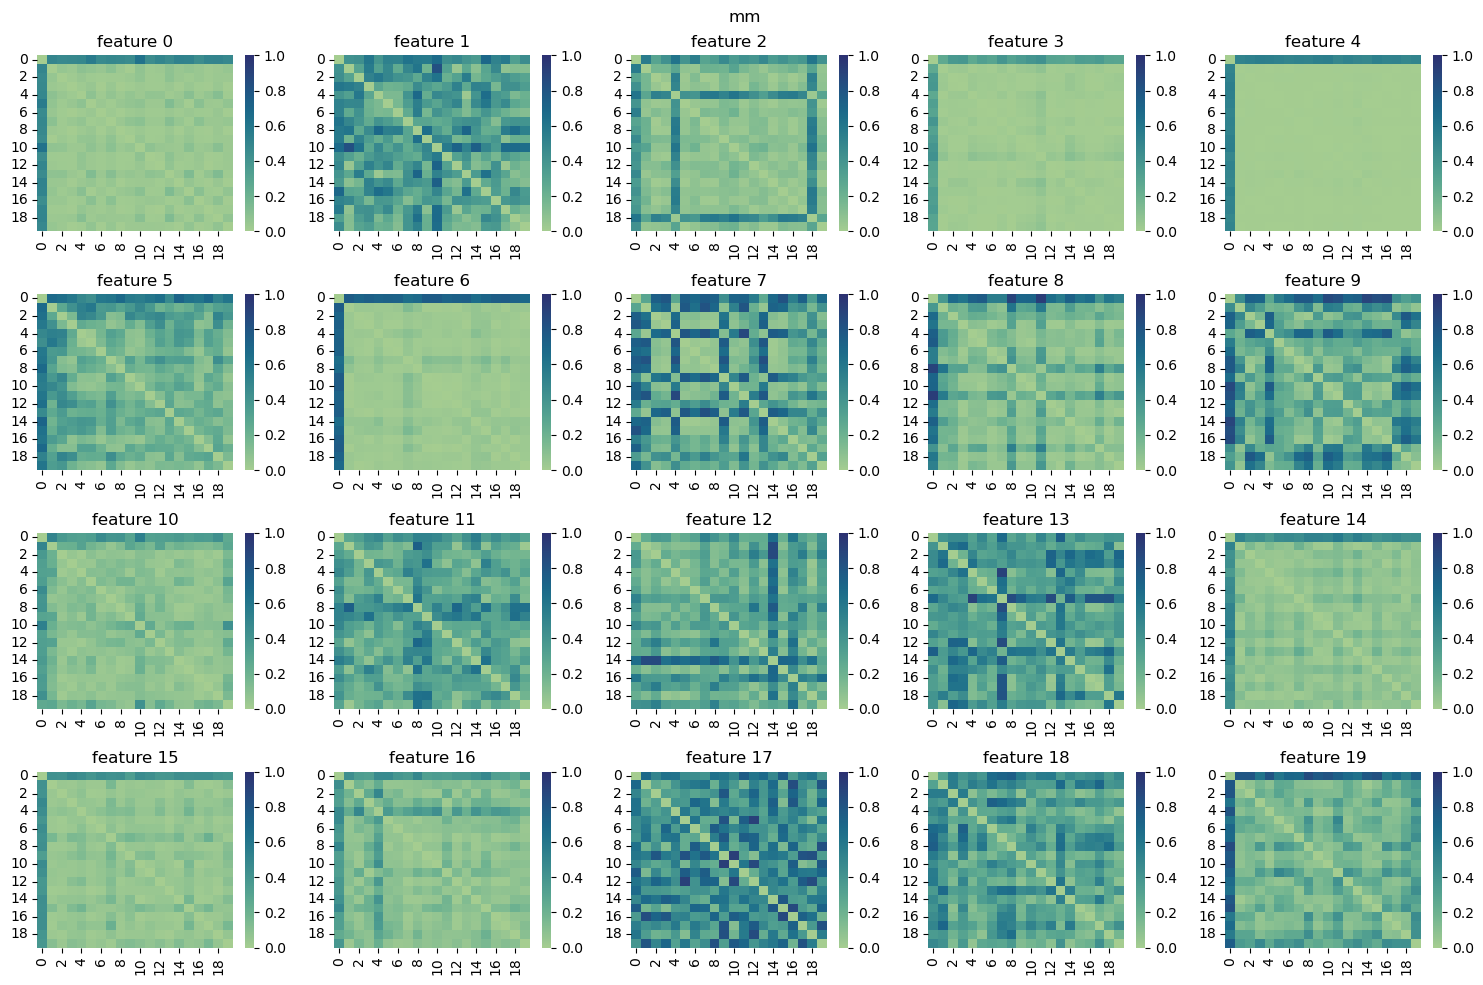

In [814]:
vis_local_model_sim(tracker, iteration = 3, model='mm')

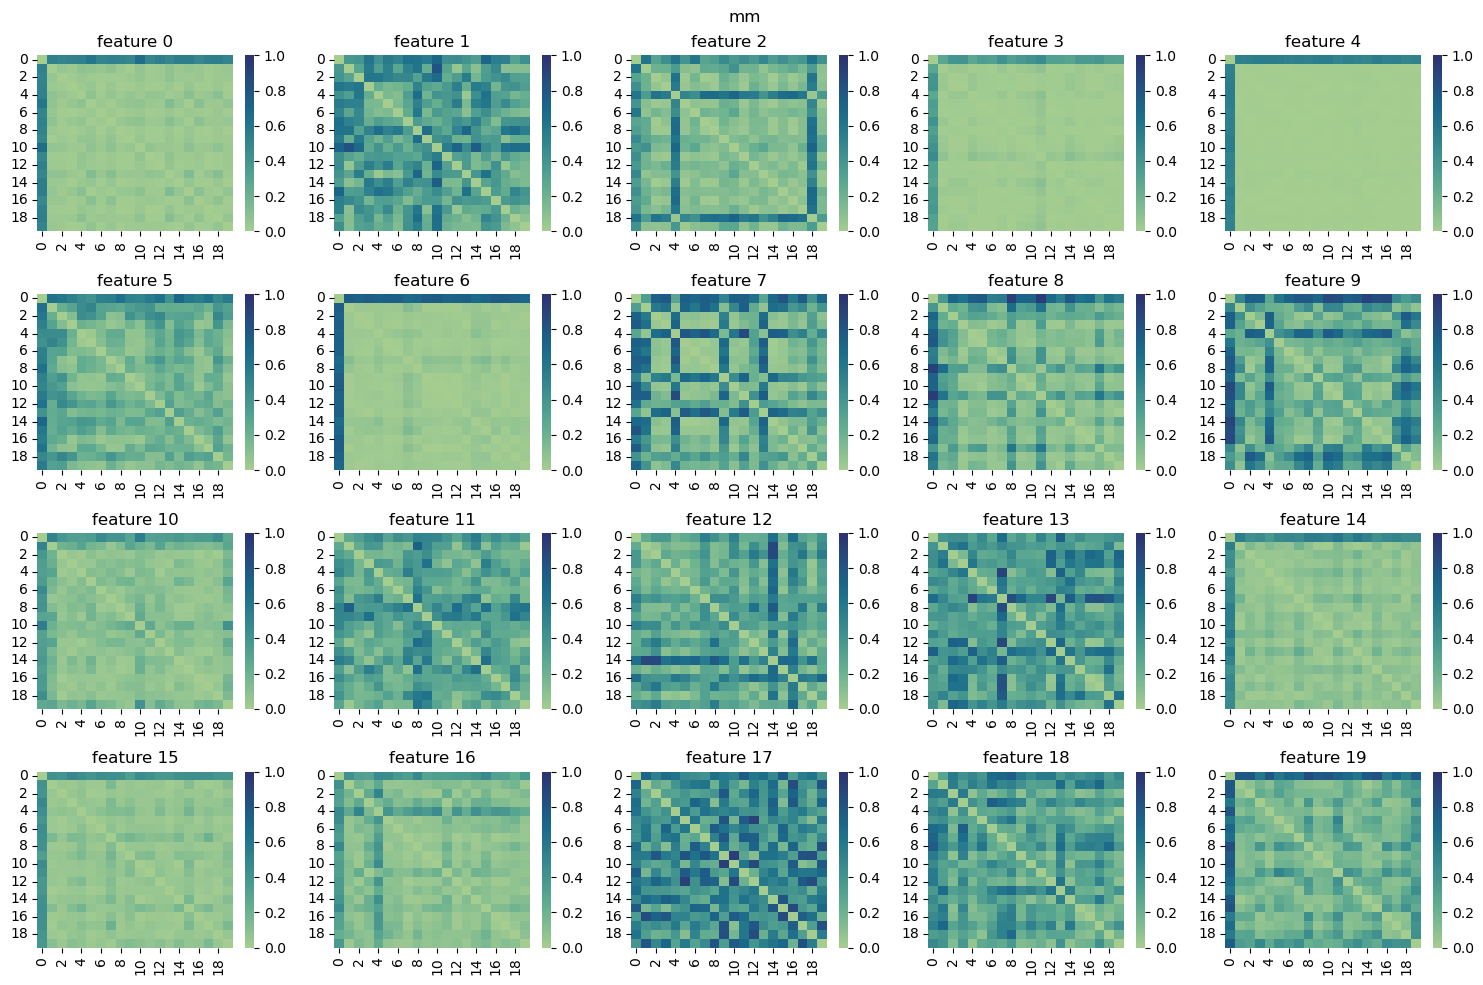

In [815]:
vis_local_model_sim(tracker, iteration = 5, model='mm')

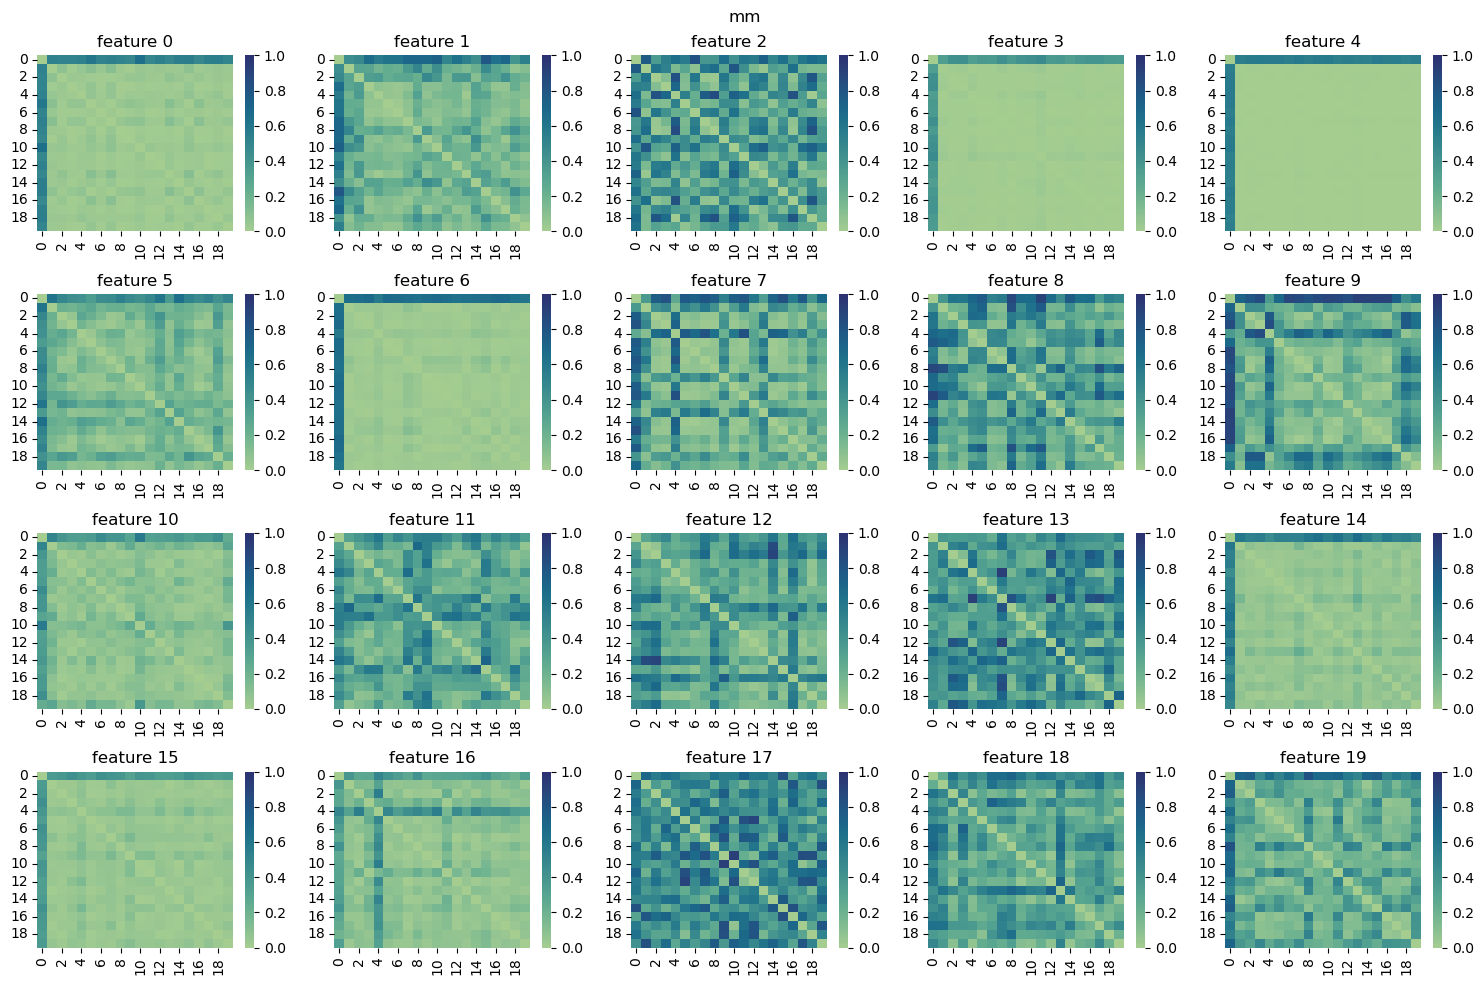

In [816]:
vis_local_model_sim(tracker, iteration = 20, model='mm')

##### Complementary

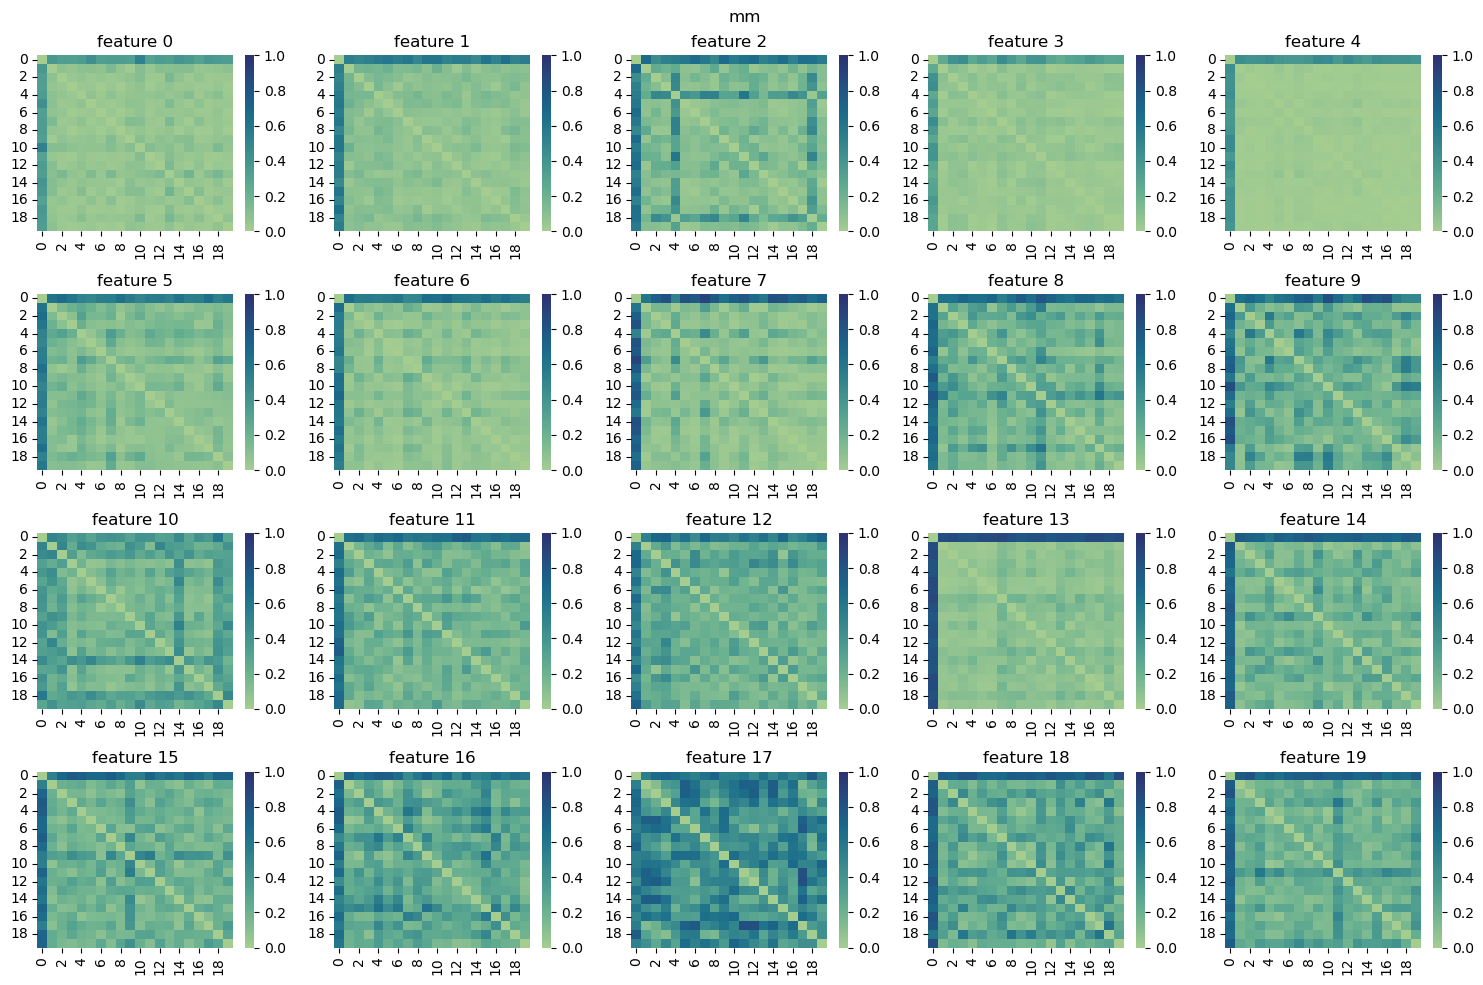

In [817]:
vis_local_model_sim(tracker2, iteration = 1, model='mm')

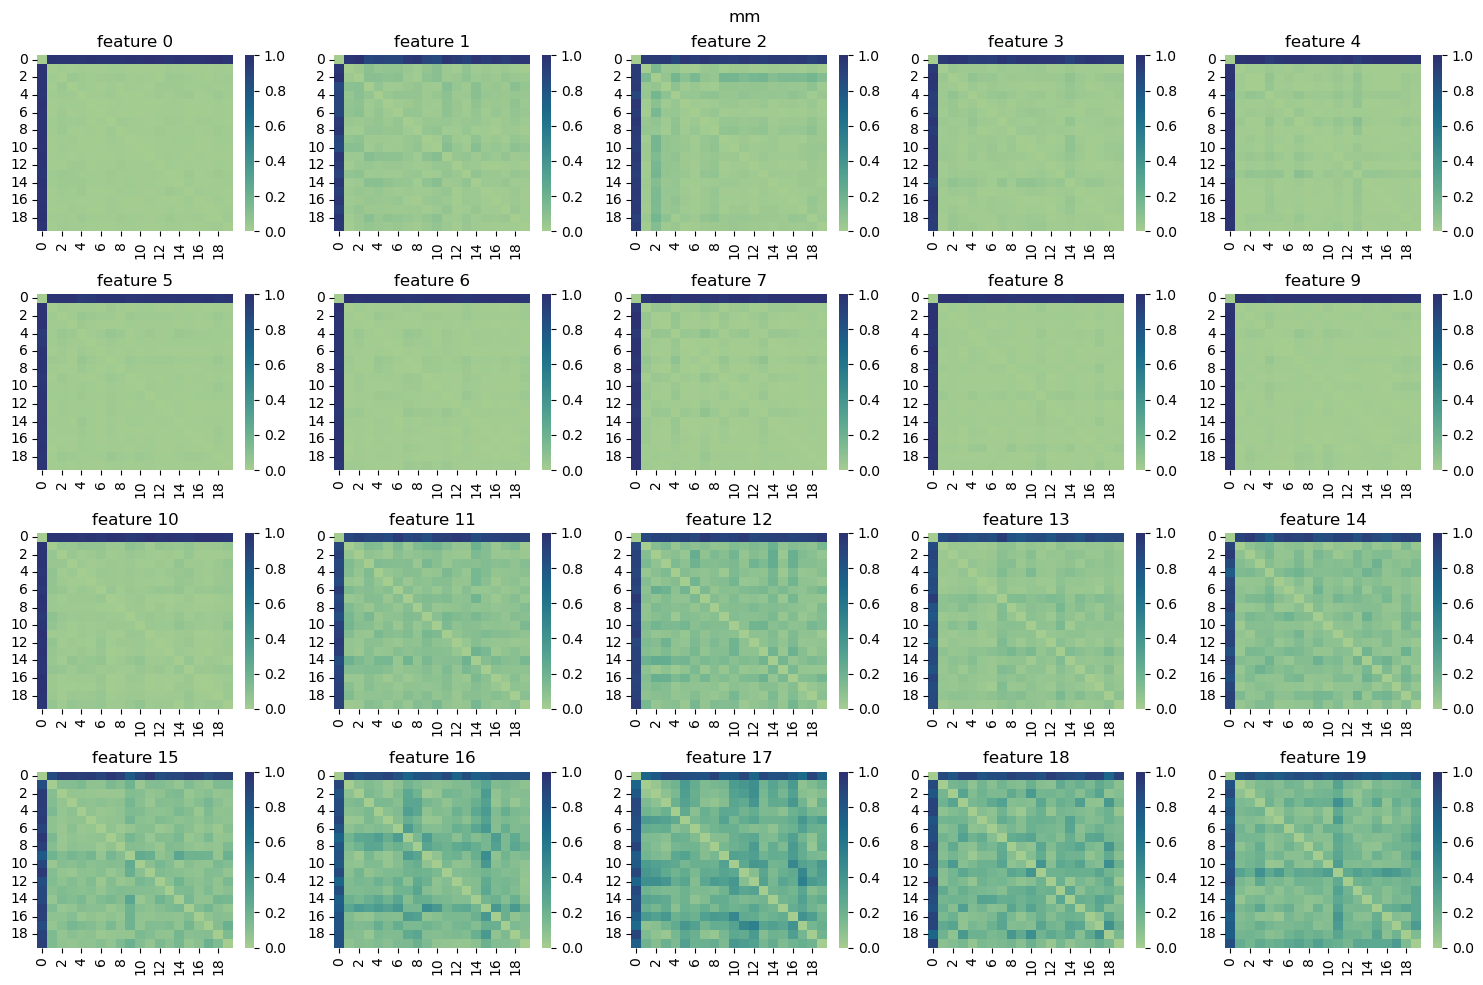

In [818]:
vis_local_model_sim(tracker2, iteration = 5, model='mm')

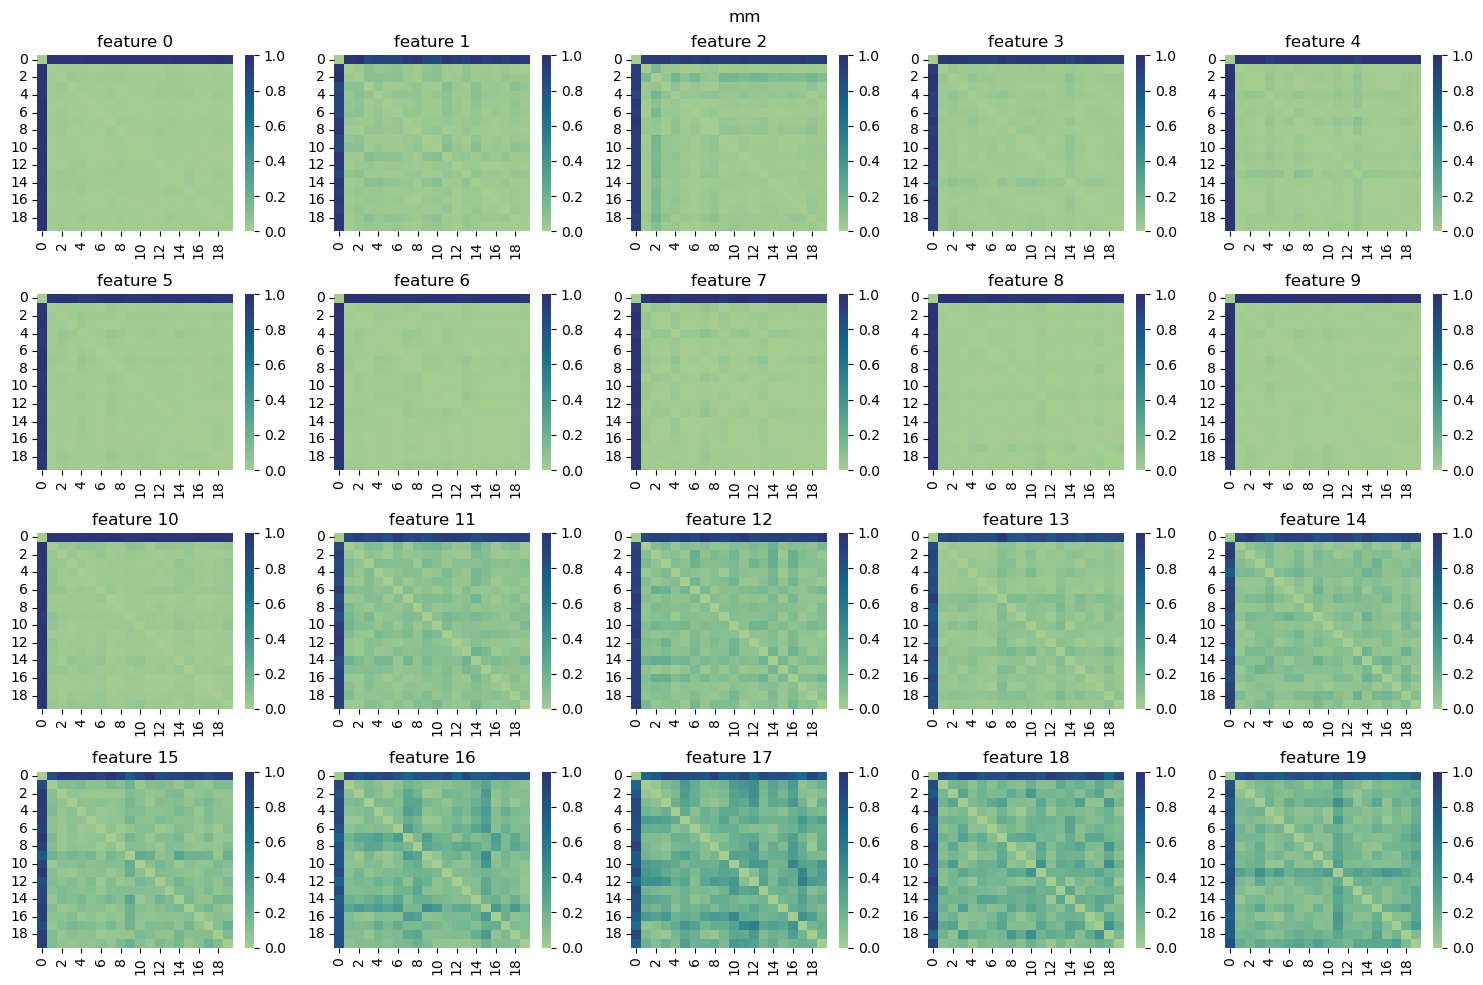

In [819]:
vis_local_model_sim(tracker2, iteration = 20, model='mm')

##### Ours

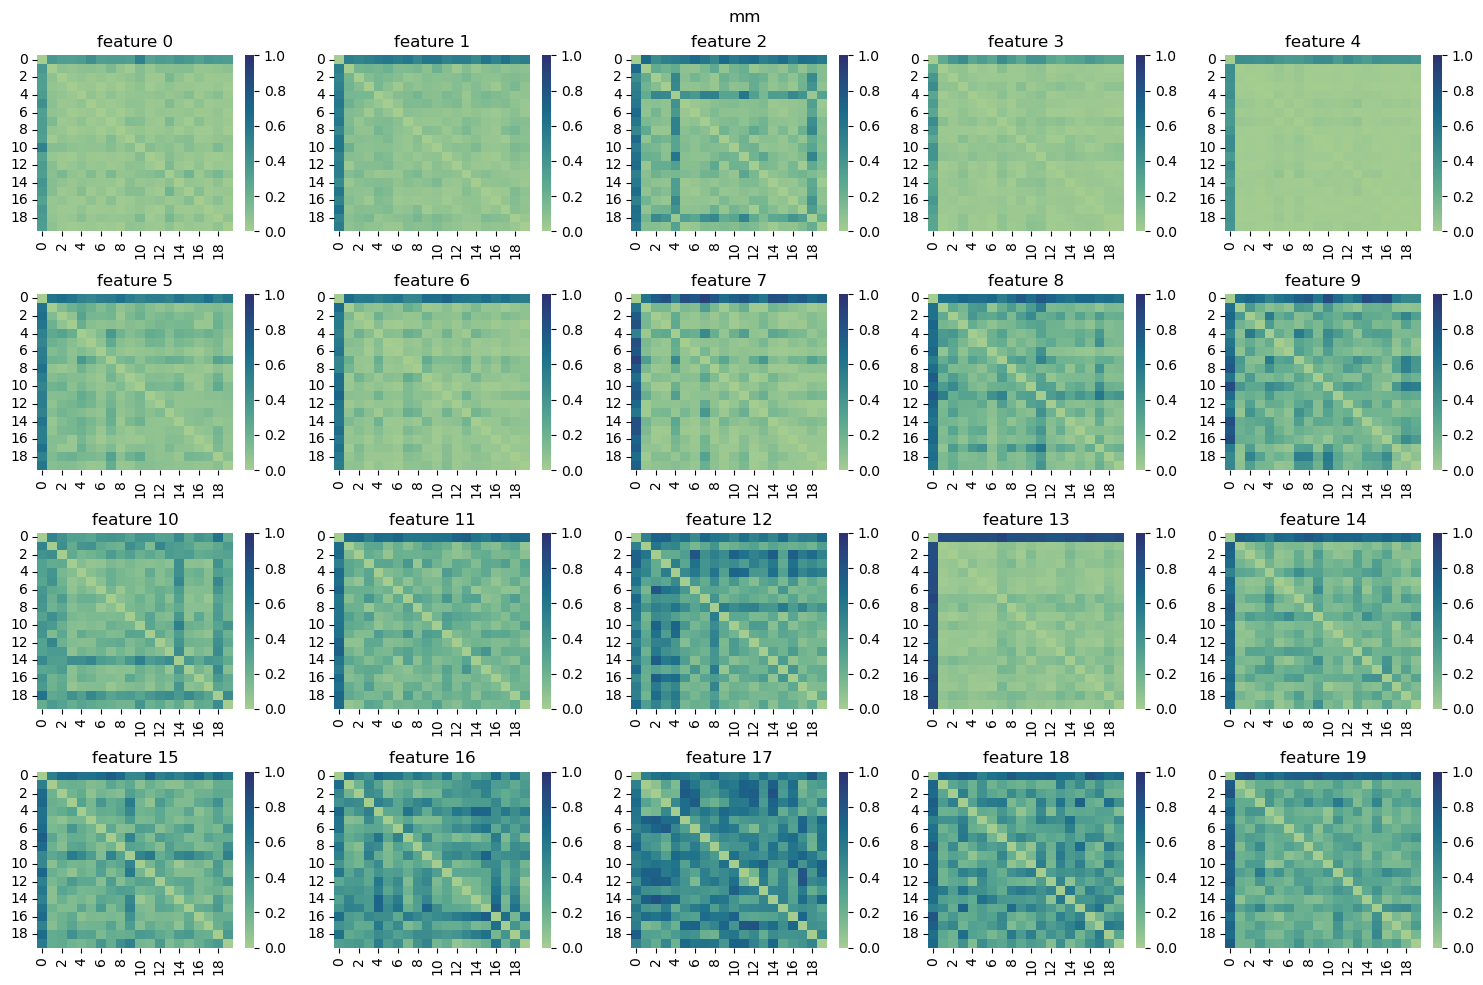

In [820]:
vis_local_model_sim(tracker3, iteration = 1, model='mm')

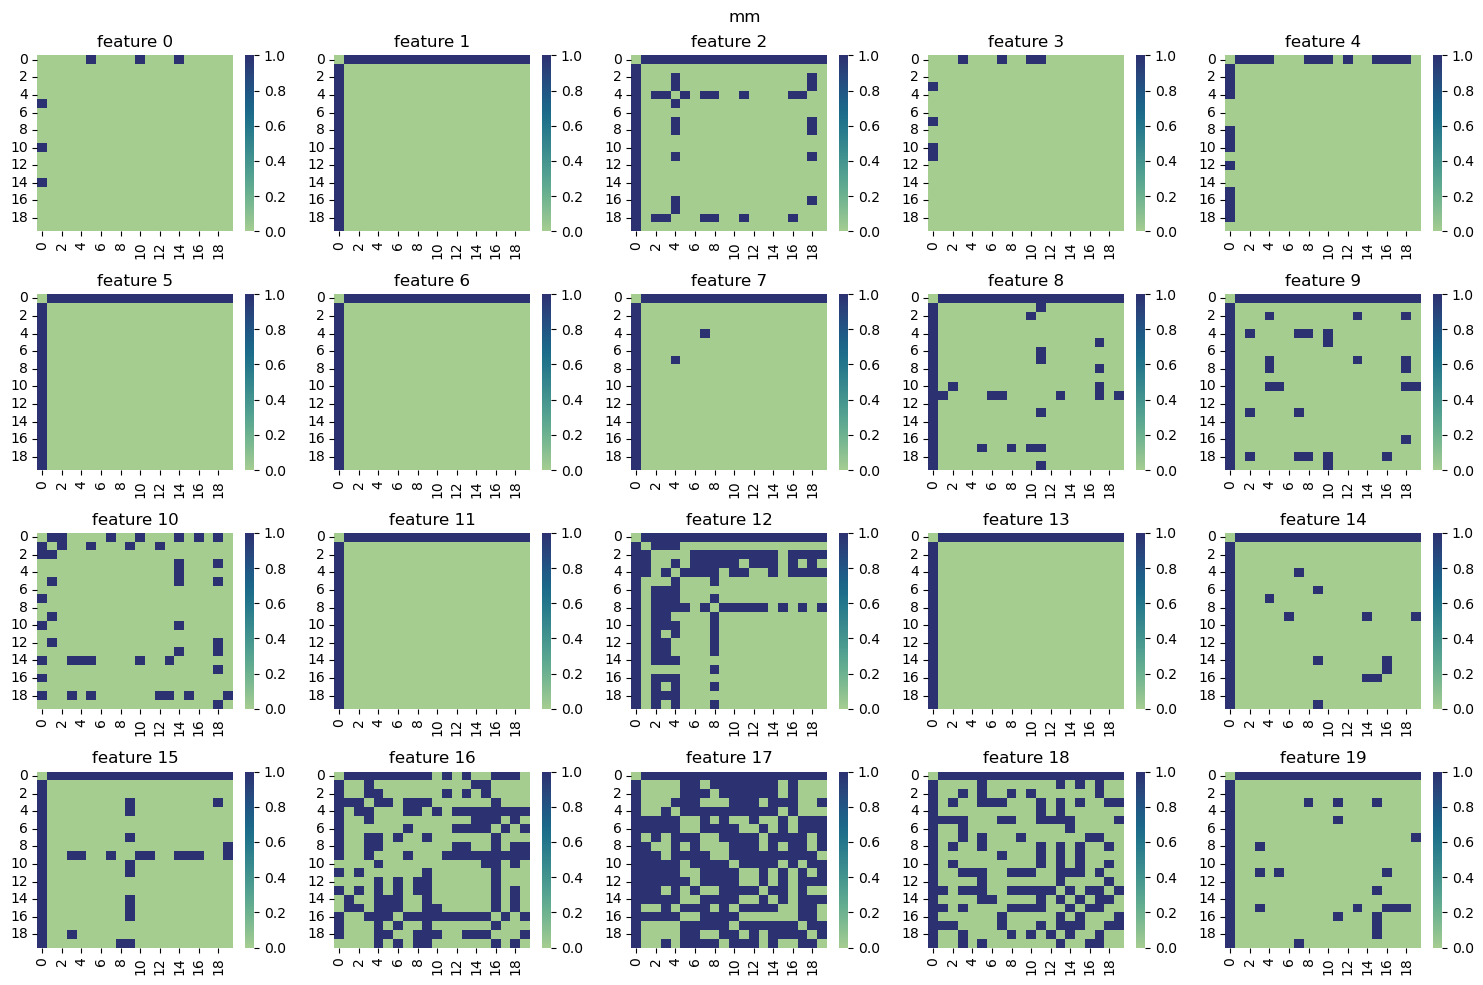

In [821]:
vis_local_model_sim_t(tracker3, iteration = 1, model='mm')

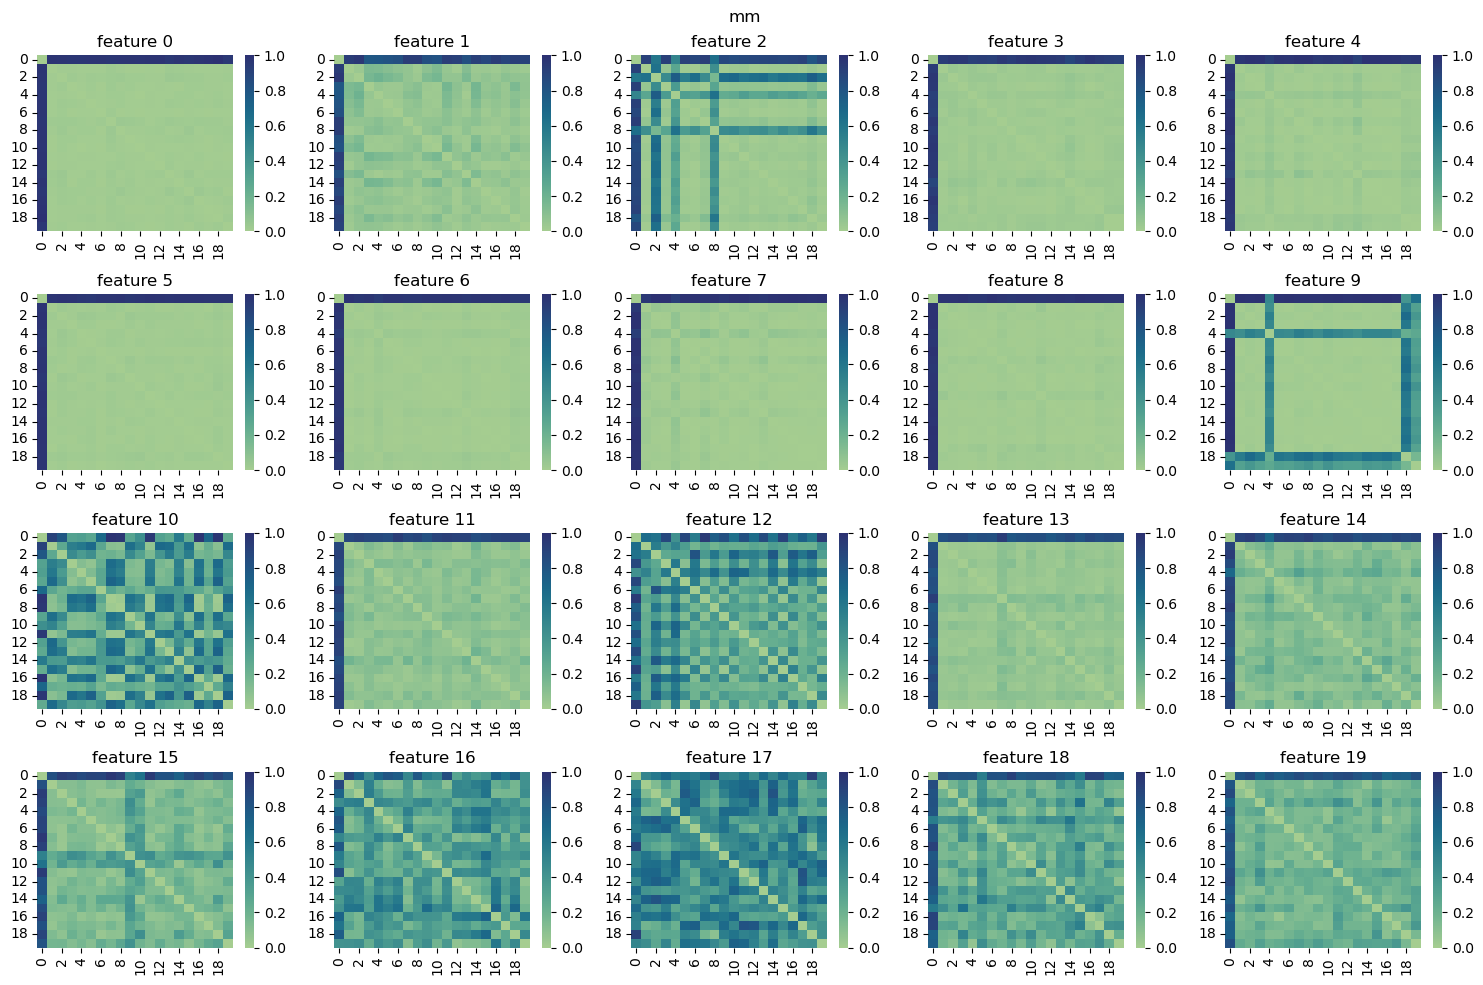

In [822]:
vis_local_model_sim(tracker3, iteration = 2, model='mm')

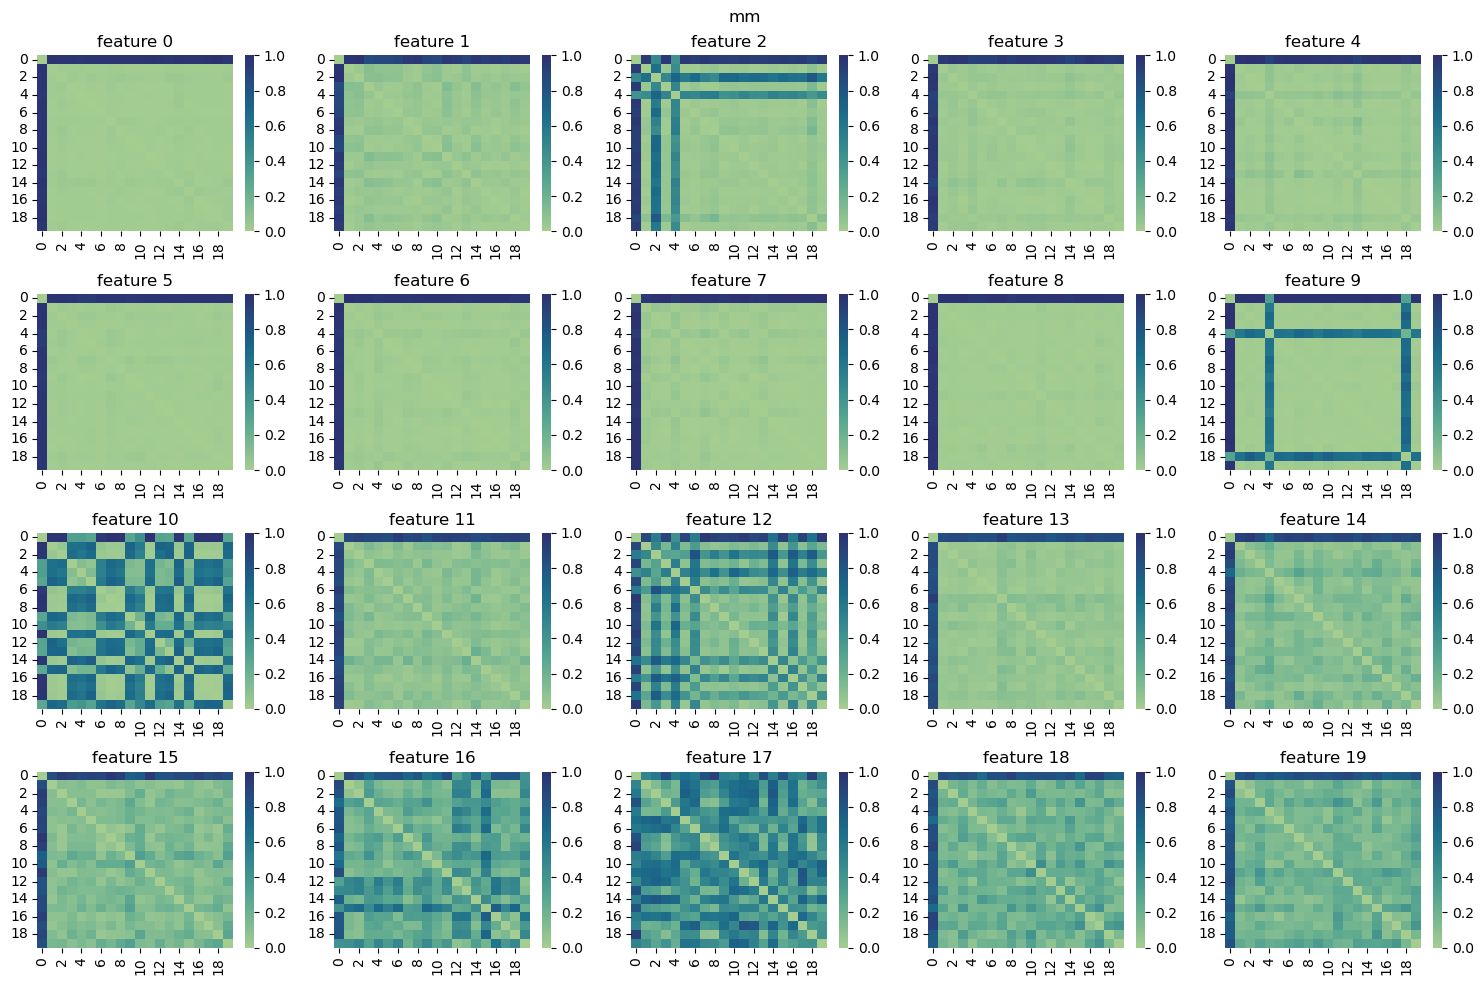

In [823]:
vis_local_model_sim(tracker3, iteration = 20, model='mm')

### MARY

In [824]:
trackery0 = trackers['mary_sigmoid_lr_local']
trackery1 = trackers['mary_sigmoid_lr_simpleavg']
trackery2 = trackers['mary_sigmoid_lr_complementary']
trackery3 = trackers['mary_sigmoid_lr_fedmechw']

#### Local

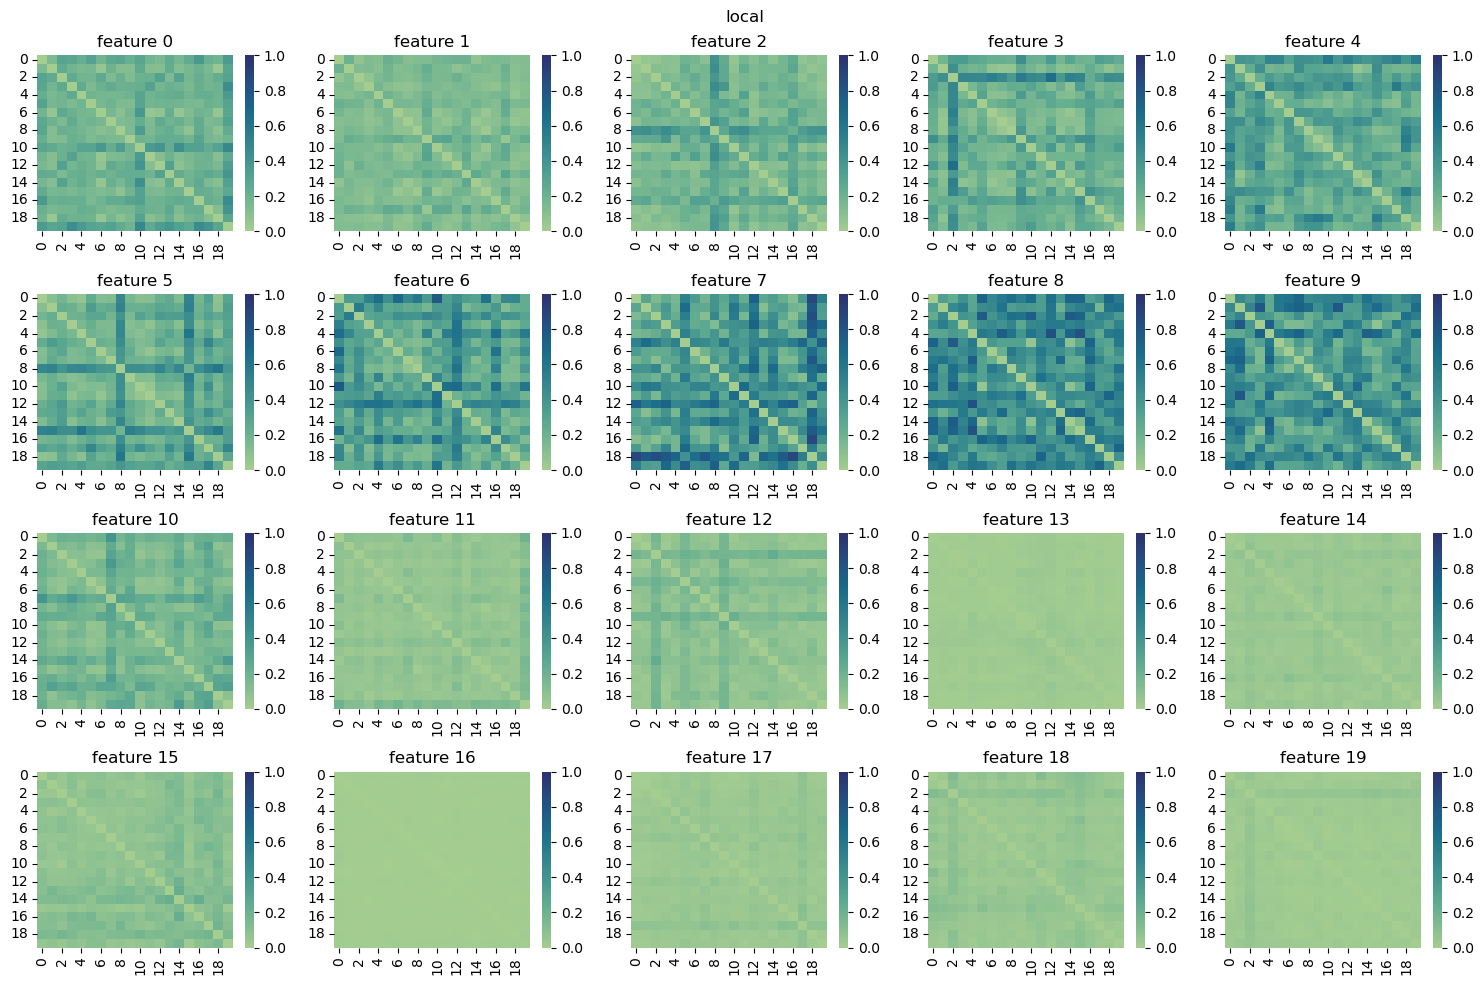

In [825]:
vis_local_model_sim(trackery0, iteration = 1, model='local')

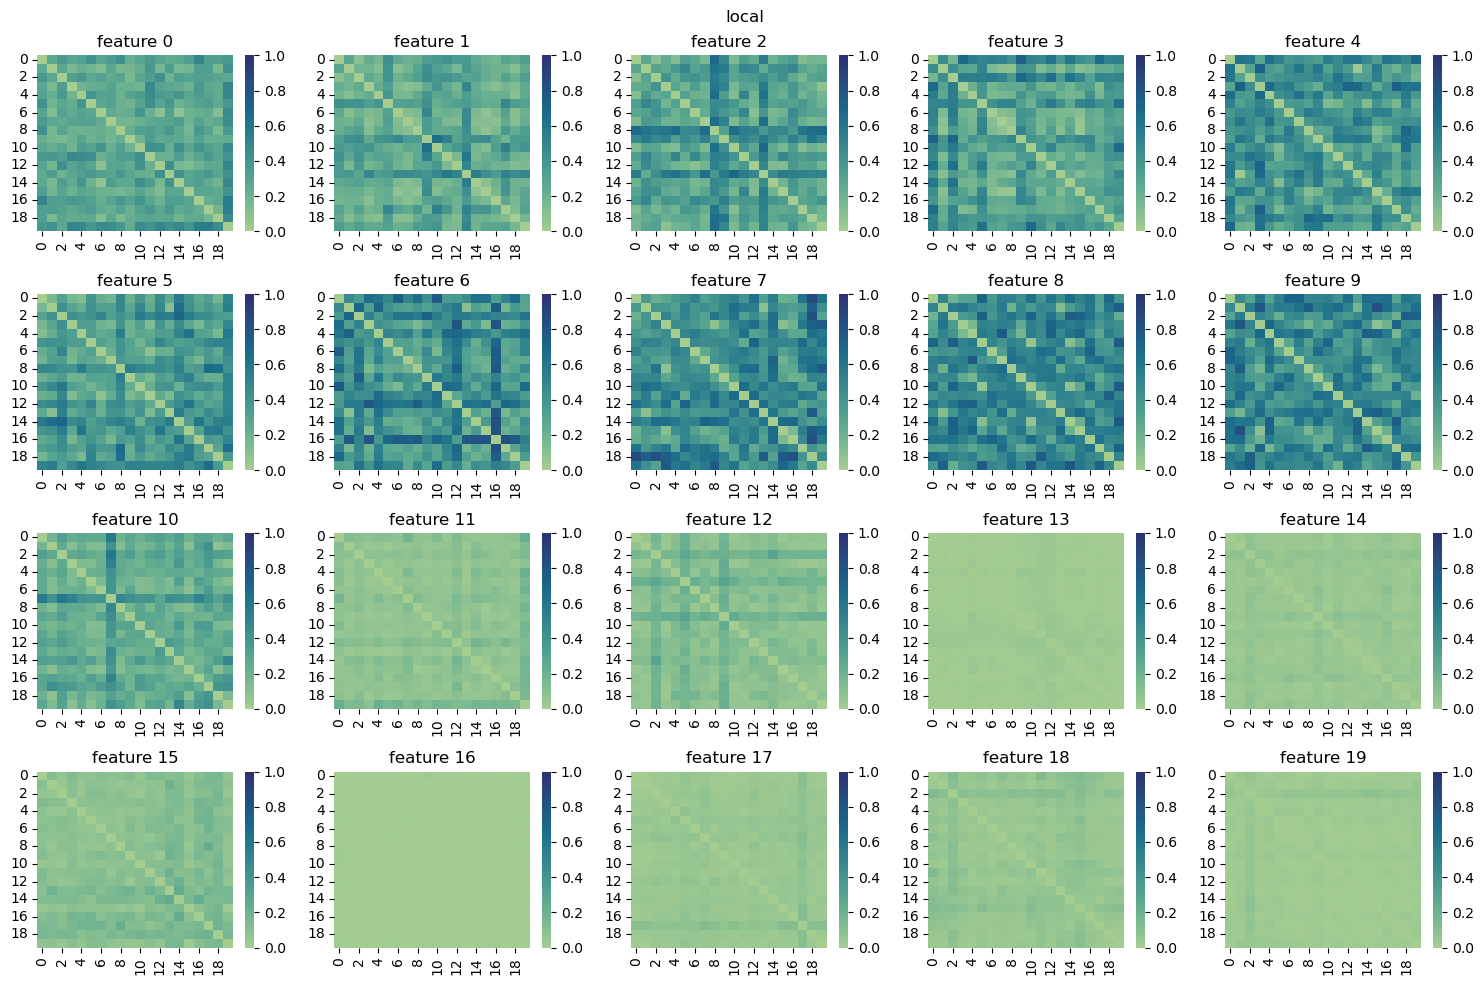

In [826]:
vis_local_model_sim(trackery0, iteration = 20, model='local')

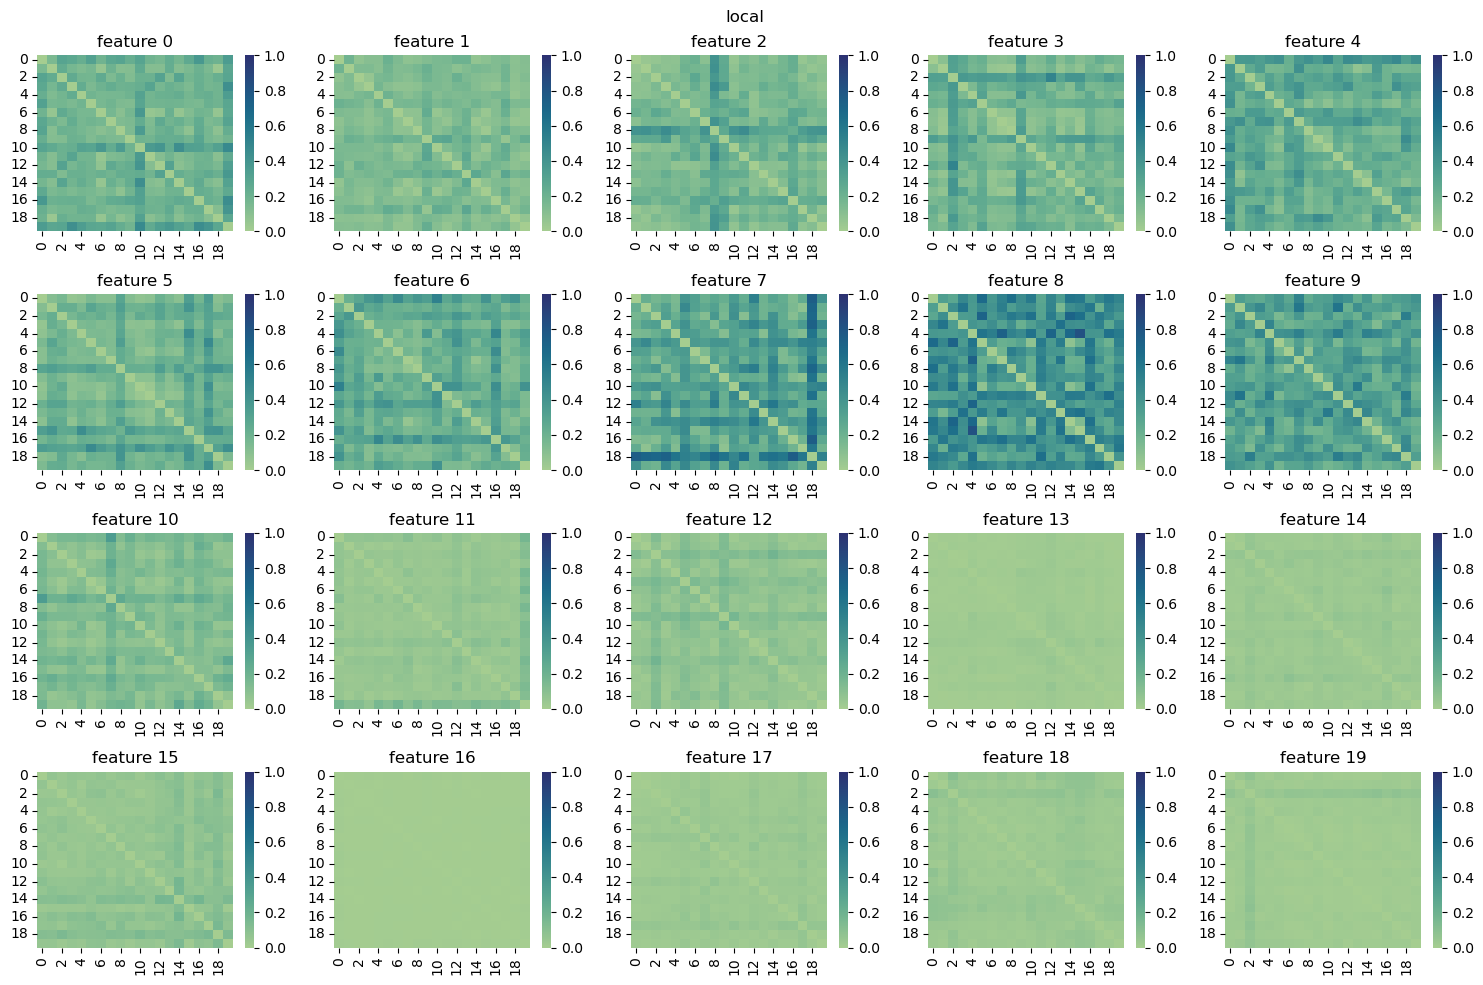

In [827]:
vis_local_model_sim(trackery1, iteration = 1, model='local')

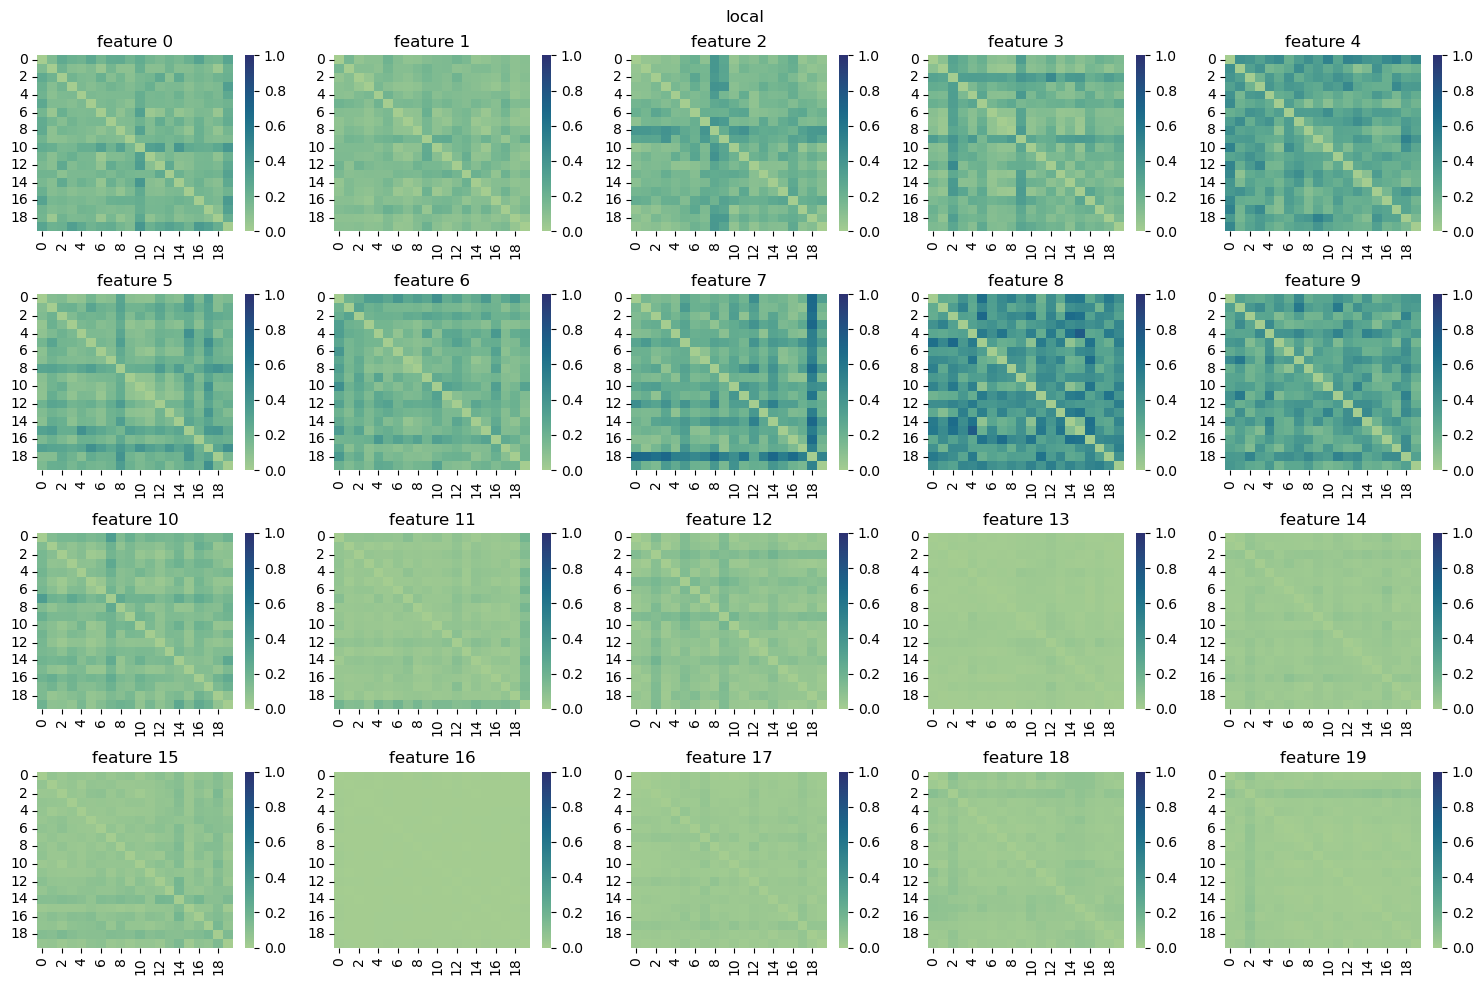

In [828]:
vis_local_model_sim(trackery1, iteration = 20, model='local')

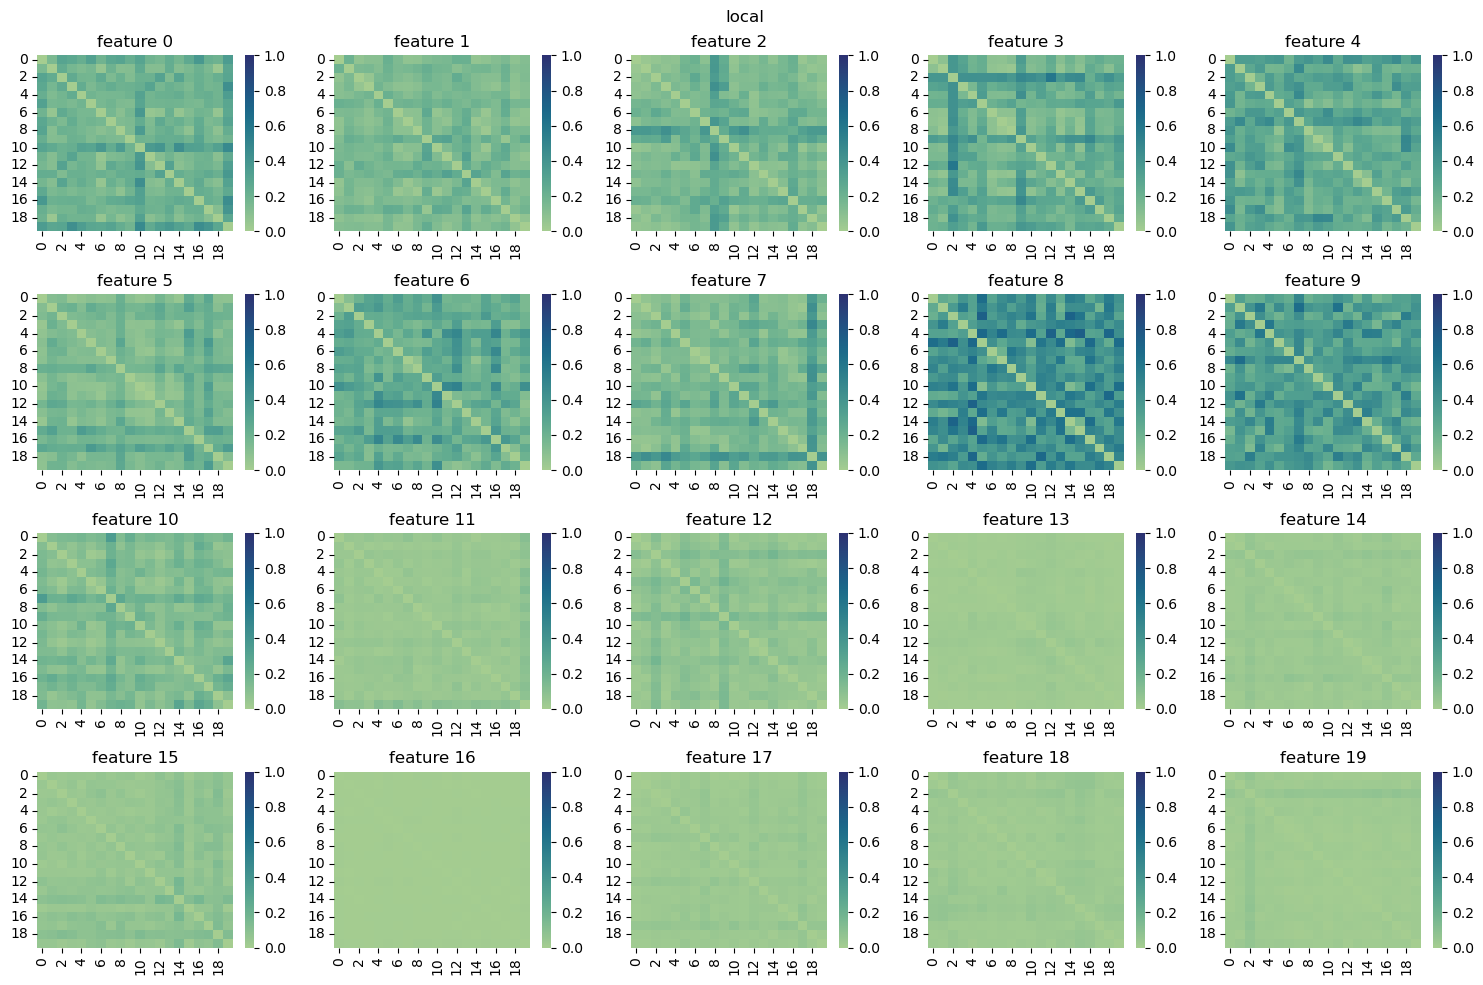

In [829]:
vis_local_model_sim(trackery2, iteration = 1, model='local')

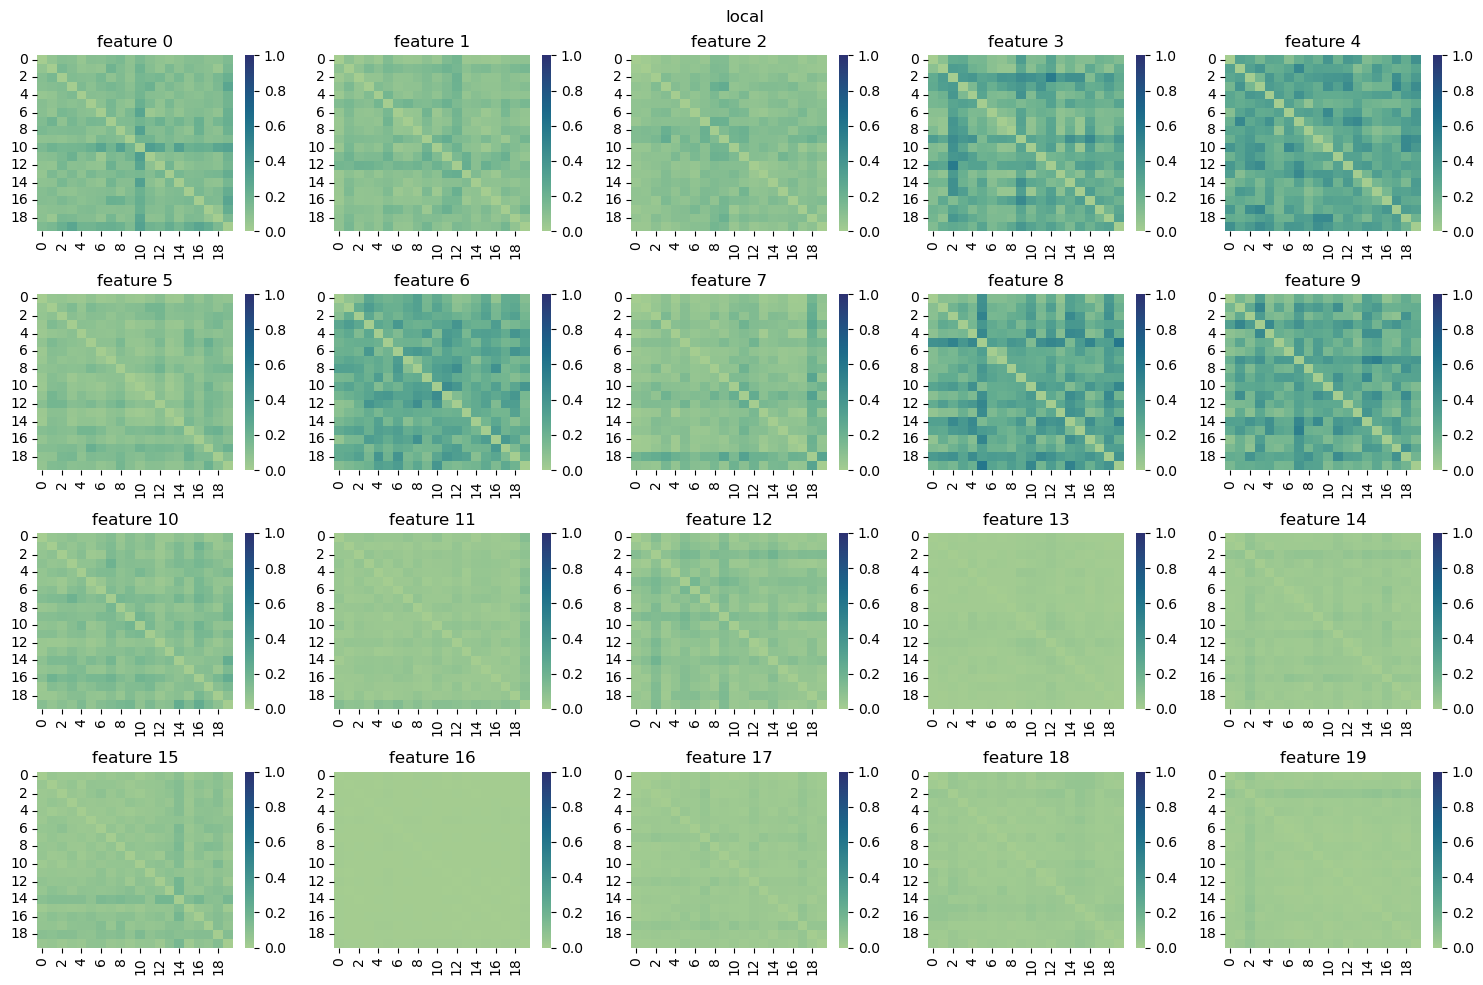

In [830]:
vis_local_model_sim(trackery2, iteration = 20, model='local')

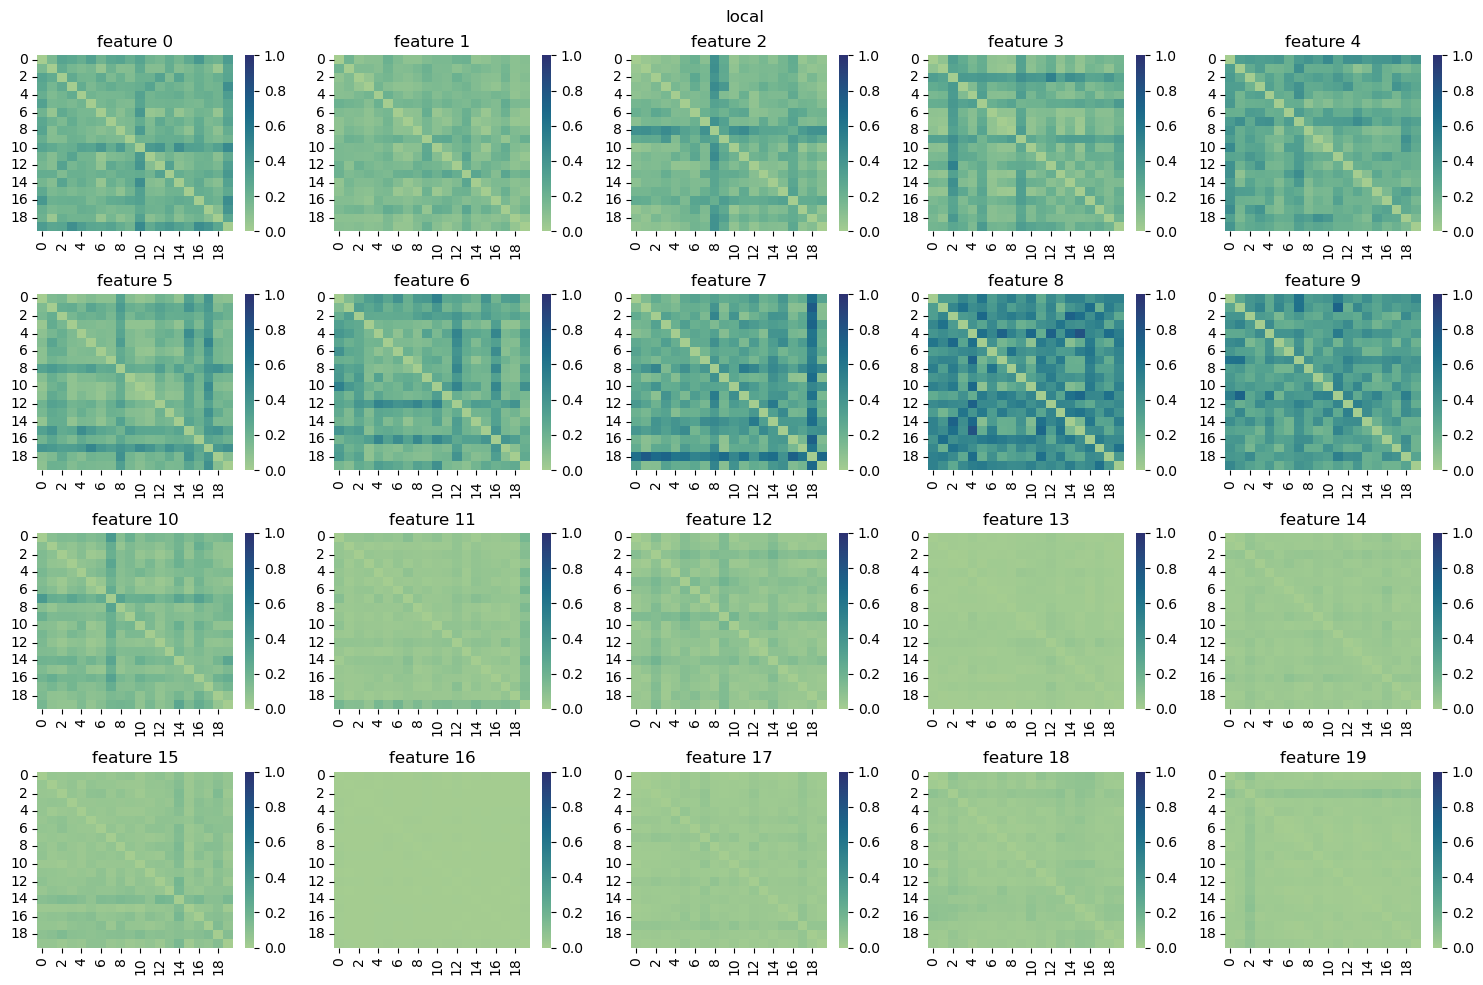

In [831]:
vis_local_model_sim(trackery3, iteration = 1, model='local')

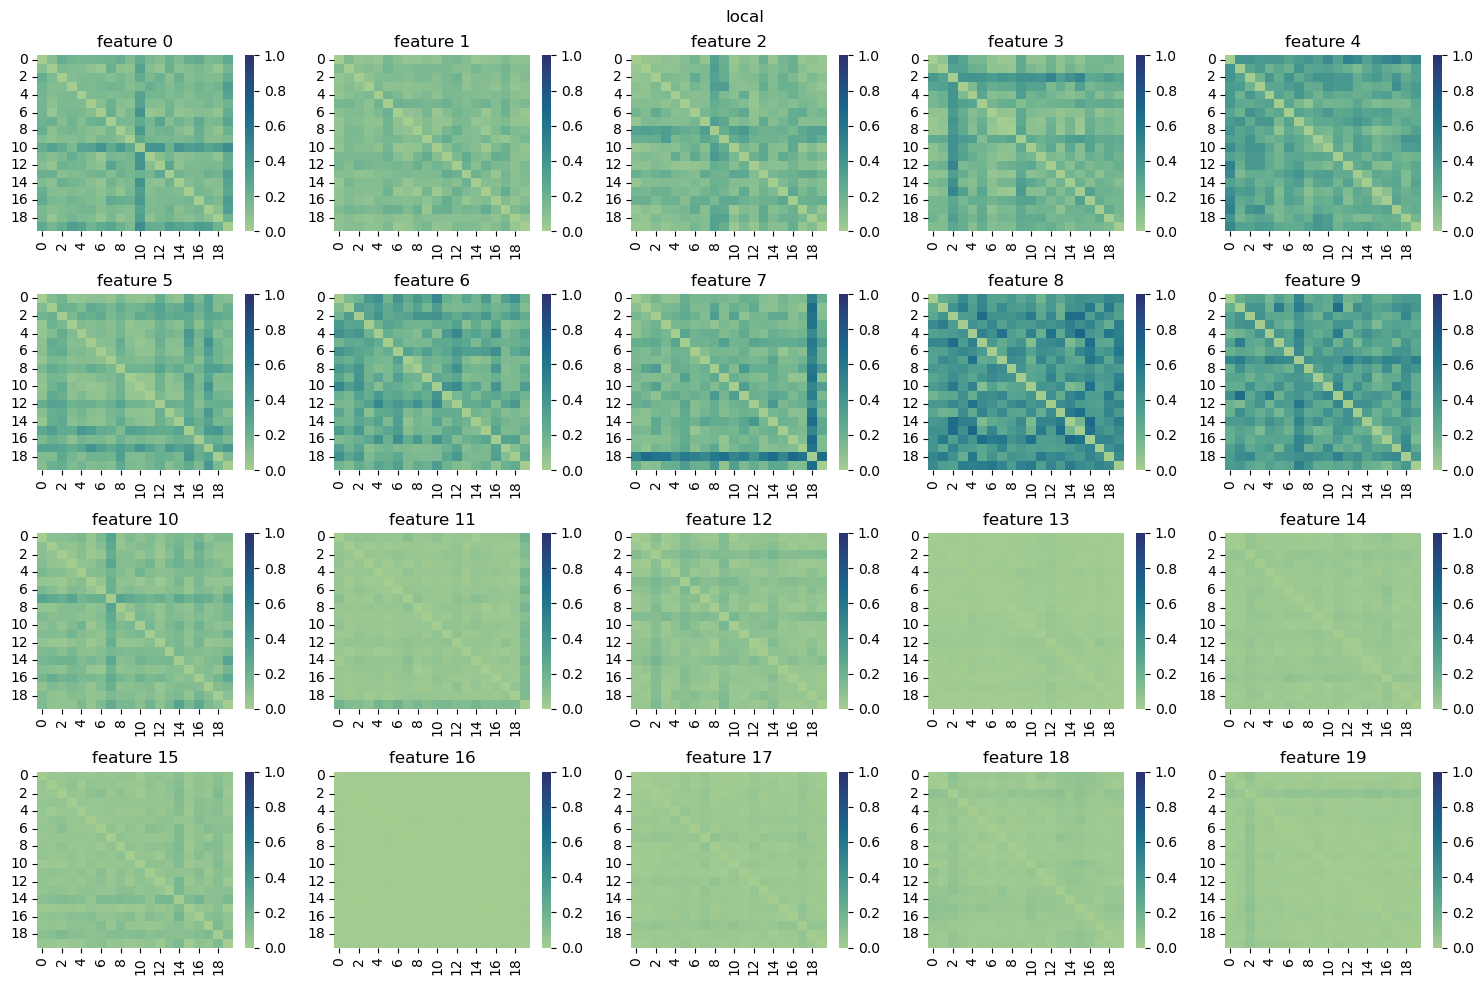

In [832]:
vis_local_model_sim(trackery3, iteration = 20, model='local')

#### Mechanism

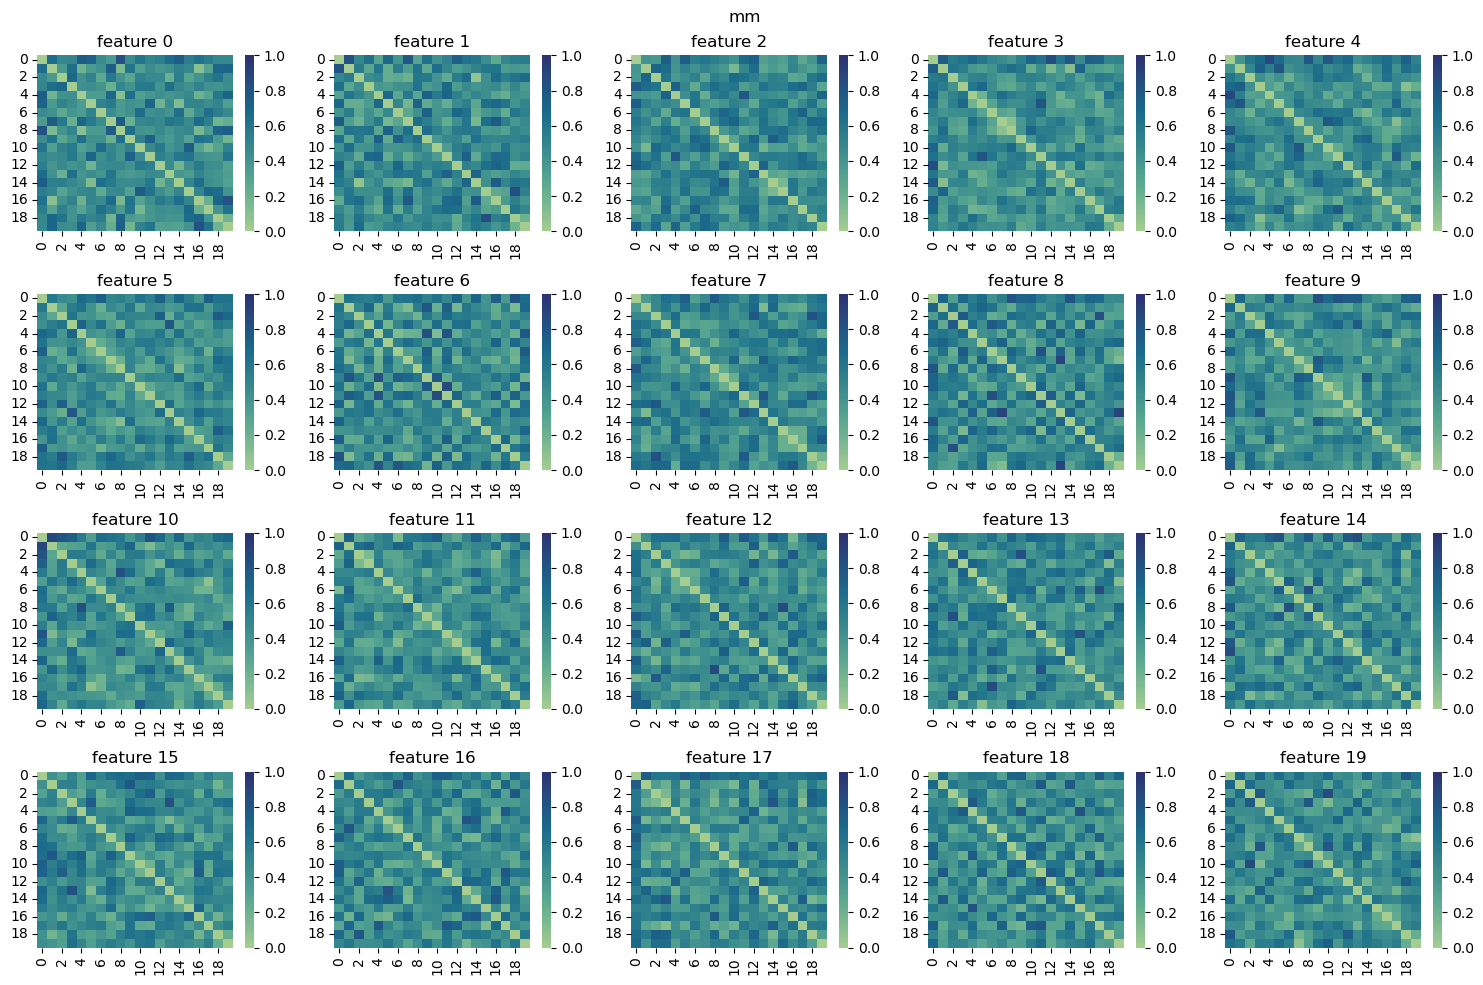

In [833]:
vis_local_model_sim(trackery1, iteration = 1, model='mm')

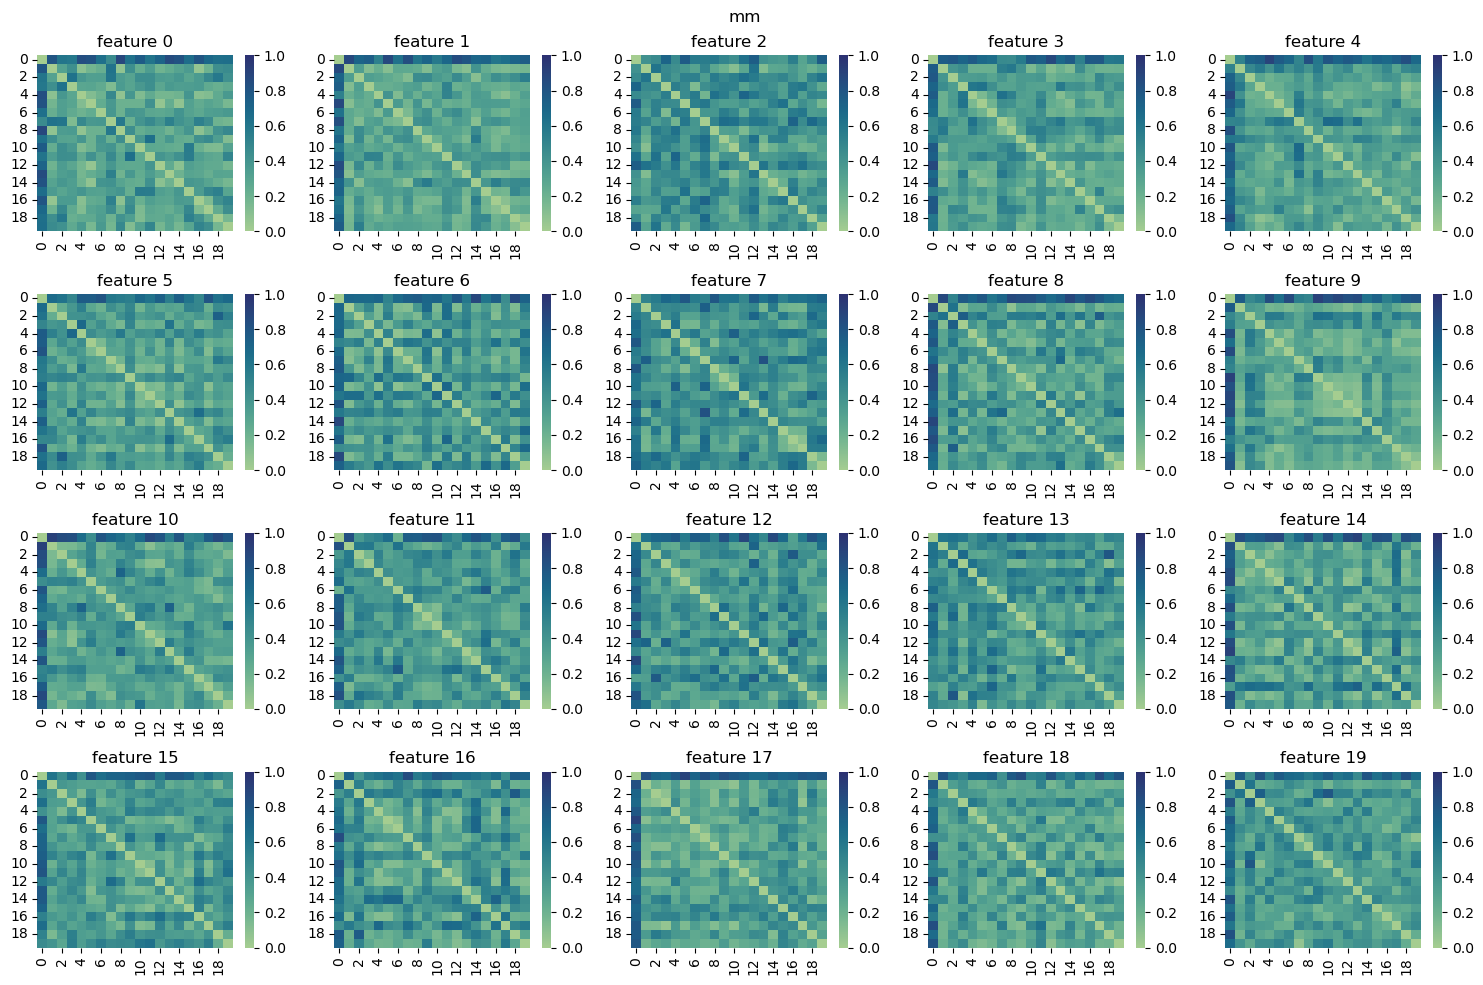

In [835]:
vis_local_model_sim(trackery2, iteration = 20, model='mm')

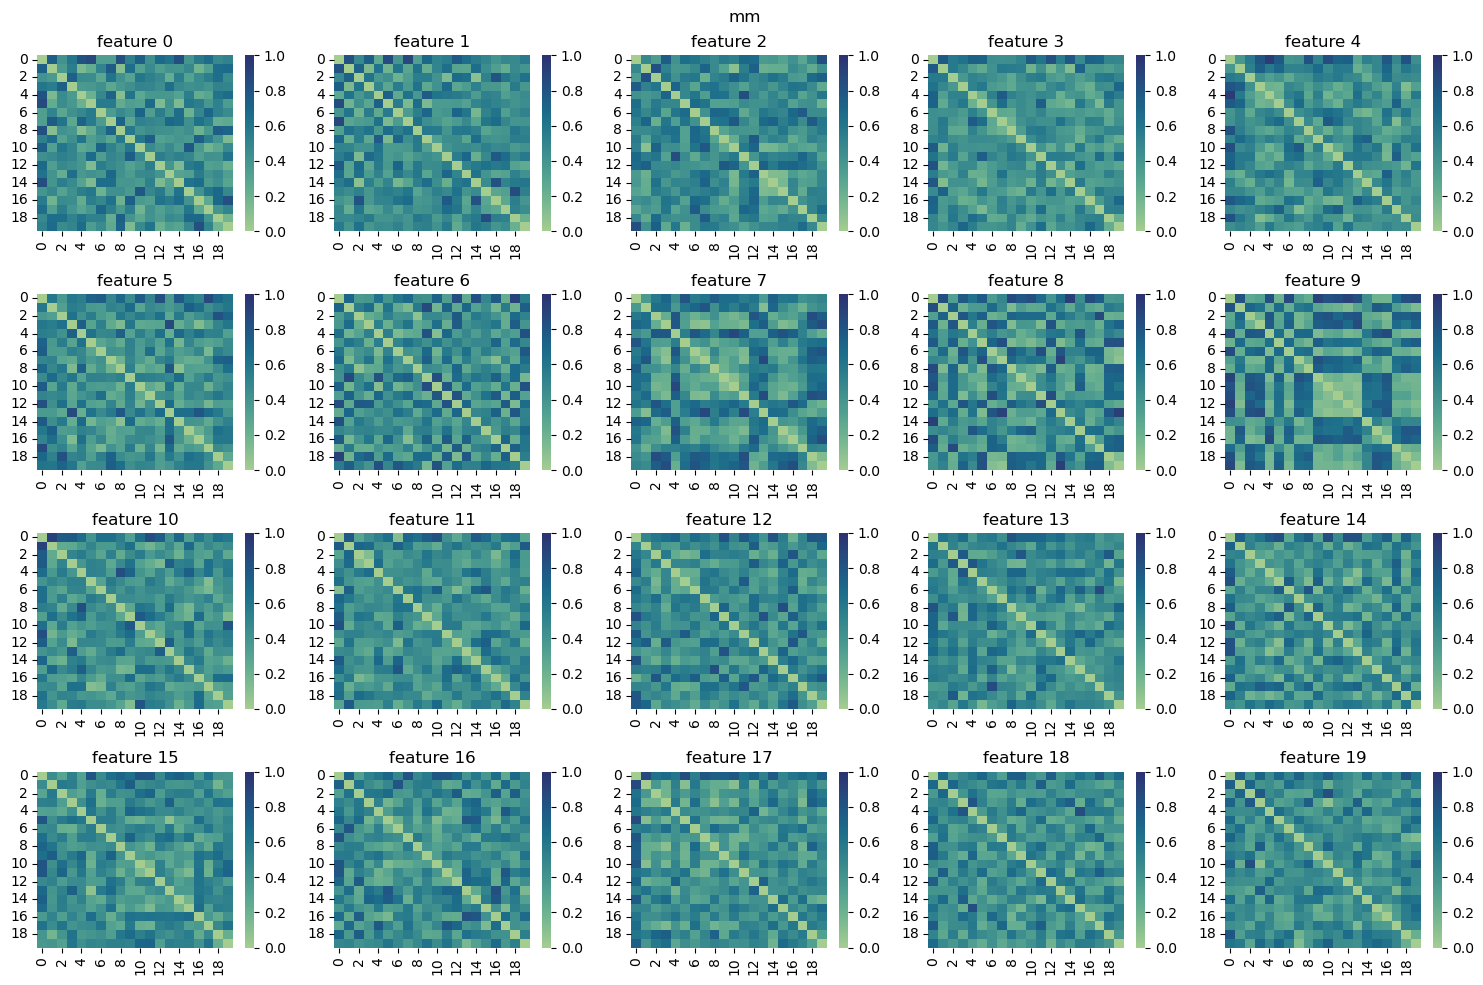

In [834]:
vis_local_model_sim(trackery3, iteration = 20, model='mm')